# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
## Tuning PArameters:
gauss_kernel = 5
Ymax = 539

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


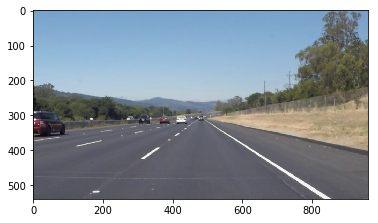

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
Right_Lane_Markings = []
Right_Lane_Markings.append((20,20))
Right_Lane_Markings.append((40,35))
np.array(Right_Lane_Markings)
print(np.array(Right_Lane_Markings))

[[20 20]
 [40 35]]


In [28]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[0, 255, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
#     print("Unfilteres: ", lines)
    lines = filter_lines(lines)
#     print("line filtered: ",lines)
    for line in lines:
        print("lineeee", line)
        x1 = line[0]
        y1 = line[1]
        x2 = line[2]
        y2 = line[3]
        
        # Y = MX + C
        M = (y2-y1)/(x2-x1)
        print('M: ', M)
        C = y2-M*x2
        print('C: ', C)
        X3 = (Ymax - y2 + M*x2)/M
        print('X3', X3)
        
        
#         print("Hello", (int(line[0]), int(line[1])), (int(X3), Ymax))
#         vx,vy,X,Y = cv2.fitLine(np.array([(20, 20), (40, 35)]),cv2.DIST_L2,0,0.01,0.01)
#         print("Points: ", vx, vy, X, Y)
 
        if M<0:
            print('less', M)
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
            cv2.line(img, (int(x1), int(y1)), (int(X3), Ymax), color, thickness)
        else:
            print('more: ', M)
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
            cv2.line(img, (int(X3), Ymax), (int(x2), int(y2)), color, thickness)
            
#         cv2.line(img, 35,45,55,25, color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
#     print("Hough Lines: ", lines.dtype)
#     print("type: ", lines.shape)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def filter_lines(lines):
#     print(lines)
    # remove false positives
    slopes=[]
    flines=[]
    lane_info=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
#             print("x1:",x1,"y1:",y1,"x2:",x2,"y2:",y2,)
#             print("slope: ", slope)
            if (0.5 <= slope) or (-0.5 >= slope) :
                slopes.append((y2-y1)/(x2-x1))
                lane_info.append([x1,y1,x2,y2,slope])
#                 print("slope inside: ", slope)
#                 print("lane info:: ", lane_info)
    lane_info = np.array(lane_info)
#     print("lane_info_shape:", lane_info[:,:])
    hist, bins = np.histogram(slopes, bins=3, density=False)
#     print("Hist", hist)
#     print("bins", bins)
    sort_hist = np.argsort(hist)
#     print("Sorted Hist: ", sort_hist)
    left_lane_slope = bins[sort_hist[-1]+1]
    print("left_lane_slope ",left_lane_slope)
    idx = np.absolute((lane_info[:,4]-left_lane_slope)).argmin()
#     print("idx ", idx)
    flines.append([lane_info[idx,0], lane_info[idx,1], lane_info[idx,2], lane_info[idx,3] ])
    right_lane_slope = bins[sort_hist[-2]]
    idx = np.absolute((lane_info[:,4]-right_lane_slope)).argmin()
#     print("error ", lane_info-right_lane_slope)
#     print("idx",idx)
#     print("right_lane_slope", right_lane_slope)
#     print(lane_info[:,4])
    flines.append([lane_info[idx,0], lane_info[idx,1], lane_info[idx,2], lane_info[idx,3] ])
#     plt.show(plt.hist(slopes))
    
    print(type(flines))
    return flines

left_lane_slope  0.650887573964
<class 'list'>
lineeee [475.0, 304.0, 644.0, 414.0]
M:  0.650887573964
C:  -5.17159763314
X3 836.045454545
more:  0.650887573964
lineeee [187.0, 521.0, 489.0, 302.0]
M:  -0.725165562914
C:  656.605960265
X3 162.178082192
less -0.725165562914


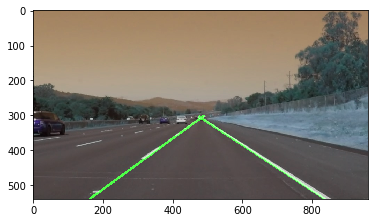

In [29]:
img_raw = cv2.imread('./test_images/solidWhiteRight.jpg')
img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
img_canny = canny(gaussian_blur(img, gauss_kernel), low_threshold=70, high_threshold=80)

left_bottom = [0,img_raw.shape[0]]
left_top = [470, 300]
right_top = [500, 300]
right_bottom = [img_raw.shape[1], img_raw.shape[0]]

vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
img_roi = region_of_interest(img_canny, vertices)

overlay = hough_lines(img_roi, 1, (np.pi)/180, 20, 50, 500)

plt.imshow(weighted_img(overlay,img_raw))

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [30]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [31]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
#     img = img[300:,:]
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = gaussian_blur(img, gauss_kernel)
#     img_canny = canny(img, low_threshold=150, high_threshold=155)
#     # hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
#     overlay = hough_lines(img_canny, 1, (np.pi)/180, 150, 50, 100)
#     plt.imshow(weighted_img(overlay, img))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_canny = canny(gaussian_blur(img, gauss_kernel), low_threshold=70, high_threshold=80)

    left_bottom = [0,img_raw.shape[0]]
    left_top = [470, 300]
    right_top = [500, 300]
    right_bottom = [img_raw.shape[1], img_raw.shape[0]]

    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    img_roi = region_of_interest(img_canny, vertices)

    overlay = hough_lines(img_roi, 1, (np.pi)/180, 20, 50, 500)
    return weighted_img(overlay, img)

Let's try the one with the solid white lane on the right first ...

In [34]:
clip1 = VideoFileClip('./test_videos/solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

left_lane_slope  0.627551020408
<class 'list'>
lineeee [478.0, 304.0, 674.0, 427.0]
M:  0.627551020408
C:  4.0306122449
X3 852.471544715
more:  0.627551020408
lineeee [203.0, 514.0, 464.0, 303.0]
M:  -0.808429118774
C:  678.111111111
X3 172.075829384
less -0.808429118774


In [35]:
## ONLY TO WRITE VIDEO
white_output = './output_videos/solidWhiteRight.mp4'
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/solidWhiteRight.mp4
[MoviePy] Writing video ./output_videos/solidWhiteRight.mp4


  1%|▏         | 3/222 [00:00<00:09, 23.48it/s]

left_lane_slope  0.627551020408
<class 'list'>
lineeee [478.0, 304.0, 674.0, 427.0]
M:  0.627551020408
C:  4.0306122449
X3 852.471544715
more:  0.627551020408
lineeee [203.0, 514.0, 464.0, 303.0]
M:  -0.808429118774
C:  678.111111111
X3 172.075829384
less -0.808429118774
left_lane_slope  -0.329650420268
<class 'list'>
lineeee [150.0, 538.0, 502.0, 301.0]
M:  -0.673295454545
C:  638.994318182
X3 148.514767932
less -0.673295454545
lineeee [479.0, 305.0, 868.0, 538.0]
M:  0.598971722365
C:  18.0925449871
X3 869.669527897
more:  0.598971722365
left_lane_slope  0.650273224044
<class 'list'>
lineeee [480.0, 301.0, 846.0, 539.0]
M:  0.650273224044
C:  -11.131147541
X3 846.0
more:  0.650273224044
lineeee [170.0, 538.0, 484.0, 301.0]
M:  -0.754777070064
C:  666.312101911
X3 168.675105485
less -0.754777070064
left_lane_slope  -0.329081969179
<class 'list'>
lineeee [199.0, 503.0, 478.0, 301.0]
M:  -0.724014336918
C:  647.078853047
X3 149.277227723
less -0.724014336918
lineeee [477.0, 302.0, 833.0

  4%|▎         | 8/222 [00:00<00:09, 22.06it/s]

 -0.329942764713
<class 'list'>
lineeee [301.0, 428.0, 485.0, 300.0]
M:  -0.695652173913
C:  637.391304348
X3 141.4375
less -0.695652173913
lineeee [481.0, 305.0, 870.0, 538.0]
M:  0.598971722365
C:  16.8946015424
X3 871.669527897
more:  0.598971722365
left_lane_slope  0.626373626374
<class 'list'>
lineeee [478.0, 305.0, 751.0, 476.0]
M:  0.626373626374
C:  5.59340659341
X3 851.578947368
more:  0.626373626374
lineeee [360.0, 394.0, 473.0, 306.0]
M:  -0.778761061947
C:  674.353982301
X3 173.806818182
less -0.778761061947
left_lane_slope  0.62582781457
<class 'list'>
lineeee [482.0, 307.0, 784.0, 496.0]
M:  0.62582781457
C:  5.35099337748
X3 852.708994709
more:  0.62582781457
lineeee [262.0, 463.0, 487.0, 300.0]
M:  -0.724444444444
C:  652.804444444
X3 157.09202454
less -0.724444444444
left_lane_slope  0.624338624339
<class 'list'>
lineeee [472.0, 303.0, 850.0, 539.0]
M:  0.624338624339
C:  8.31216931217
X3 850.0
more:  0.624338624339
lineeee [228.0, 488.0, 487.0, 300.0]
M:  -0.725868725

  7%|▋         | 16/222 [00:00<00:07, 26.57it/s]

left_lane_slope  0.700854700855
<class 'list'>
lineeee [481.0, 305.0, 598.0, 387.0]
M:  0.700854700855
C:  -32.1111111111
X3 814.87804878
more:  0.700854700855
lineeee [239.0, 485.0, 488.0, 304.0]
M:  -0.726907630522
C:  658.730923695
X3 164.712707182
less -0.726907630522
left_lane_slope  -0.285194927829
<class 'list'>
lineeee [356.0, 391.0, 490.0, 304.0]
M:  -0.649253731343
C:  622.134328358
X3 128.045977011
less -0.649253731343
lineeee [491.0, 313.0, 797.0, 504.0]
M:  0.624183006536
C:  6.52614379085
X3 853.073298429
more:  0.624183006536
left_lane_slope  0.65034965035
<class 'list'>
lineeee [478.0, 306.0, 621.0, 399.0]
M:  0.65034965035
C:  -4.86713286713
X3 836.268817204
more:  0.65034965035
lineeee [163.0, 538.0, 486.0, 303.0]
M:  -0.727554179567
C:  656.591331269
X3 161.625531915
less -0.727554179567
left_lane_slope  0.652694610778
<class 'list'>
lineeee [478.0, 304.0, 645.0, 413.0]
M:  0.652694610778
C:  -7.9880239521
X3 838.04587156
more:  0.652694610778
lineeee [257.0, 466.0, 

 10%|█         | 23/222 [00:00<00:07, 27.17it/s]

left_lane_slope  0.686274509804
<class 'list'>
lineeee [479.0, 304.0, 530.0, 339.0]
M:  0.686274509804
C:  -24.7254901961
X3 821.428571429
more:  0.686274509804
lineeee [348.0, 401.0, 475.0, 302.0]
M:  -0.779527559055
C:  672.275590551
X3 170.96969697
less -0.779527559055
left_lane_slope  -0.264714212882
<class 'list'>
lineeee [325.0, 410.0, 482.0, 305.0]
M:  -0.668789808917
C:  627.356687898
X3 132.114285714
less -0.668789808917
lineeee [480.0, 305.0, 854.0, 538.0]
M:  0.622994652406
C:  5.96256684492
X3 855.605150215
more:  0.622994652406
left_lane_slope  0.652694610778
<class 'list'>
lineeee [474.0, 303.0, 641.0, 412.0]
M:  0.652694610778
C:  -6.37724550898
X3 835.577981651
more:  0.652694610778
lineeee [189.0, 520.0, 489.0, 302.0]
M:  -0.726666666667
C:  657.34
X3 162.853211009
less -0.726666666667
left_lane_slope  0.651162790698
<class 'list'>
lineeee [475.0, 304.0, 647.0, 416.0]
M:  0.651162790698
C:  -5.3023255814
X3 835.892857143
more:  0.651162790698
lineeee [300.0, 439.0, 487

 12%|█▏        | 26/222 [00:01<00:08, 24.07it/s]

 -0.30189012542
<class 'list'>
lineeee [232.0, 479.0, 497.0, 301.0]
M:  -0.671698113208
C:  634.833962264
X3 142.674157303
less -0.671698113208
lineeee [480.0, 305.0, 854.0, 538.0]
M:  0.622994652406
C:  5.96256684492
X3 855.605150215
more:  0.622994652406
left_lane_slope  0.650442477876
<class 'list'>
lineeee [473.0, 302.0, 699.0, 449.0]
M:  0.650442477876
C:  -5.6592920354
X3 837.367346939
more:  0.650442477876
lineeee [200.0, 510.0, 488.0, 301.0]
M:  -0.725694444444
C:  655.138888889
X3 160.038277512
less -0.725694444444
left_lane_slope  0.651851851852
<class 'list'>
lineeee [473.0, 302.0, 743.0, 478.0]
M:  0.651851851852
C:  -6.32592592593
X3 836.579545455
more:  0.651851851852
lineeee [258.0, 470.0, 483.0, 301.0]
M:  -0.751111111111
C:  663.786666667
X3 166.136094675
less -0.751111111111
left_lane_slope  0.650602409639
<class 'list'>
lineeee [473.0, 303.0, 805.0, 519.0]
M:  0.650602409639
C:  -4.73493975904
X3 835.740740741
more:  0.650602409639
lineeee [218.0, 500.0, 477.0, 305.0

 14%|█▍        | 32/222 [00:01<00:08, 23.20it/s]

left_lane_slope  0.650793650794
<class 'list'>
lineeee [474.0, 302.0, 537.0, 343.0]
M:  0.650793650794
C:  -6.47619047619
X3 838.170731707
more:  0.650793650794
lineeee [164.0, 538.0, 490.0, 301.0]
M:  -0.726993865031
C:  657.226993865
X3 162.624472574
less -0.726993865031
left_lane_slope  -0.284936054089
<class 'list'>
lineeee [288.0, 442.0, 490.0, 301.0]
M:  -0.69801980198
C:  643.02970297
X3 149.035460993
less -0.69801980198
lineeee [477.0, 301.0, 857.0, 538.0]
M:  0.623684210526
C:  3.50263157895
X3 858.603375527
more:  0.623684210526
left_lane_slope  0.649546827795
<class 'list'>
lineeee [473.0, 302.0, 804.0, 517.0]
M:  0.649546827795
C:  -5.23564954683
X3 837.869767442
more:  0.649546827795
lineeee [270.0, 459.0, 489.0, 300.0]
M:  -0.72602739726
C:  655.02739726
X3 159.811320755
less -0.72602739726
left_lane_slope  0.652777777778
<class 'list'>
lineeee [474.0, 301.0, 762.0, 489.0]
M:  0.652777777778
C:  -8.41666666667
X3 838.595744681
more:  0.652777777778
lineeee [413.0, 355.0, 

 17%|█▋        | 38/222 [00:01<00:08, 21.91it/s]


lineeee [299.0, 437.0, 482.0, 304.0]
M:  -0.726775956284
C:  654.306010929
X3 158.654135338
less -0.726775956284
left_lane_slope  0.651810584958
<class 'list'>
lineeee [474.0, 303.0, 833.0, 537.0]
M:  0.651810584958
C:  -5.9582172702
X3 836.068376068
more:  0.651810584958
lineeee [272.0, 455.0, 484.0, 301.0]
M:  -0.72641509434
C:  652.58490566
X3 156.363636364
less -0.72641509434
left_lane_slope  0.651162790698
<class 'list'>
lineeee [474.0, 303.0, 560.0, 359.0]
M:  0.651162790698
C:  -5.6511627907
X3 836.428571429
more:  0.651162790698
lineeee [236.0, 478.0, 471.0, 307.0]
M:  -0.727659574468
C:  649.727659574
X3 152.169590643
less -0.727659574468
left_lane_slope  0.650704225352
<class 'list'>
lineeee [474.0, 304.0, 829.0, 535.0]
M:  0.650704225352
C:  -4.4338028169
X3 835.147186147
more:  0.650704225352
lineeee [205.0, 509.0, 490.0, 302.0]
M:  -0.726315789474
C:  657.894736842
X3 163.695652174
less -0.726315789474
left_lane_slope  -0.2667006456
<class 'list'>
lineeee [147.0, 538.0, 4

 20%|█▉        | 44/222 [00:01<00:07, 23.23it/s]

left_lane_slope  0.650137741047
<class 'list'>
lineeee [470.0, 303.0, 833.0, 539.0]
M:  0.650137741047
C:  -2.56473829201
X3 833.0
more:  0.650137741047
lineeee [257.0, 472.0, 471.0, 305.0]
M:  -0.780373831776
C:  672.556074766
X3 171.143712575
less -0.780373831776
left_lane_slope  -0.283219529077
<class 'list'>
lineeee [371.0, 380.0, 490.0, 300.0]
M:  -0.672268907563
C:  629.411764706
X3 134.4875
less -0.672268907563
lineeee [483.0, 306.0, 855.0, 538.0]
M:  0.623655913978
C:  4.77419354839
X3 856.603448276
more:  0.623655913978
left_lane_slope  0.65
<class 'list'>
lineeee [471.0, 301.0, 711.0, 457.0]
M:  0.65
C:  -5.15
X3 837.153846154
more:  0.65
lineeee [164.0, 539.0, 467.0, 302.0]
M:  -0.782178217822
C:  667.277227723
X3 164.0
less -0.782178217822
left_lane_slope  0.752727272727
<class 'list'>
lineeee [487.0, 300.0, 762.0, 507.0]
M:  0.752727272727
C:  -66.5781818182
X3 804.512077295
more:  0.752727272727
lineeee [360.0, 393.0, 468.0, 309.0]
M:  -0.777777777778
C:  673.0
X3 172.285

 21%|██        | 47/222 [00:01<00:08, 21.81it/s]

left_lane_slope  0.700305810398
<class 'list'>
lineeee [502.0, 308.0, 829.0, 537.0]
M:  0.700305810398
C:  -43.5535168196
X3 831.855895197
more:  0.700305810398
lineeee [344.0, 405.0, 472.0, 305.0]
M:  -0.78125
C:  673.75
X3 172.48
less -0.78125
left_lane_slope  0.675516224189
<class 'list'>
lineeee [493.0, 309.0, 832.0, 538.0]
M:  0.675516224189
C:  -24.0294985251
X3 833.480349345
more:  0.675516224189
lineeee [337.0, 410.0, 466.0, 302.0]
M:  -0.837209302326
C:  692.139534884
X3 182.916666667
less -0.837209302326
left_lane_slope  0.69756097561
<class 'list'>
lineeee [582.0, 366.0, 787.0, 509.0]
M:  0.69756097561
C:  -39.9804878049
X3 830.006993007
more:  0.69756097561
lineeee [281.0, 450.0, 488.0, 300.0]
M:  -0.724637681159
C:  653.623188406
X3 158.18
less -0.724637681159
left_lane_slope  0.675287356322
<class 'list'>
lineeee [483.0, 303.0, 831.0, 538.0]
M:  0.675287356322
C:  -23.1637931034
X3 832.480851064
more:  0.675287356322
lineeee [252.0, 472.0, 474.0, 305.0]
M:  -0.75225225225

 24%|██▍       | 53/222 [00:02<00:07, 21.29it/s]

 -0.31477592787
<class 'list'>
lineeee [357.0, 387.0, 489.0, 301.0]
M:  -0.651515151515
C:  619.590909091
X3 123.697674419
less -0.651515151515
lineeee [479.0, 304.0, 854.0, 538.0]
M:  0.624
C:  5.104
X3 855.602564103
more:  0.624
left_lane_slope  0.675141242938
<class 'list'>
lineeee [476.0, 300.0, 830.0, 539.0]
M:  0.675141242938
C:  -21.3672316384
X3 830.0
more:  0.675141242938
lineeee [215.0, 497.0, 486.0, 300.0]
M:  -0.726937269373
C:  653.291512915
X3 157.223350254
less -0.726937269373
left_lane_slope  0.675141242938
<class 'list'>
lineeee [477.0, 300.0, 831.0, 539.0]
M:  0.675141242938
C:  -22.0423728814
X3 831.0
more:  0.675141242938
lineeee [266.0, 459.0, 484.0, 300.0]
M:  -0.729357798165
C:  653.009174312
X3 156.314465409
less -0.729357798165
left_lane_slope  0.7
<class 'list'>
lineeee [501.0, 307.0, 831.0, 538.0]
M:  0.7
C:  -43.7
X3 832.428571429
more:  0.7
lineeee [158.0, 539.0, 470.0, 303.0]
M:  -0.75641025641
C:  658.512820513
X3 158.0
less -0.75641025641
left_lane_slope

 25%|██▌       | 56/222 [00:02<00:09, 17.18it/s]

left_lane_slope  0.67323943662
<class 'list'>
lineeee [476.0, 300.0, 831.0, 539.0]
M:  0.67323943662
C:  -20.461971831
X3 831.0
more:  0.67323943662
lineeee [163.0, 523.0, 479.0, 301.0]
M:  -0.70253164557
C:  637.512658228
X3 140.225225225
less -0.70253164557
left_lane_slope  0.675213675214
<class 'list'>
lineeee [479.0, 300.0, 830.0, 537.0]
M:  0.675213675214
C:  -23.4273504274
X3 832.962025316
more:  0.675213675214
lineeee [265.0, 455.0, 486.0, 300.0]
M:  -0.701357466063
C:  640.859728507
X3 145.232258065
less -0.701357466063
left_lane_slope  0.651090342679
<class 'list'>
lineeee [474.0, 305.0, 795.0, 514.0]
M:  0.651090342679
C:  -3.61682242991
X3 833.397129187
more:  0.651090342679
lineeee [235.0, 480.0, 482.0, 301.0]
M:  -0.724696356275
C:  650.303643725
X3 153.586592179
less -0.724696356275


 27%|██▋       | 60/222 [00:02<00:09, 17.11it/s]

left_lane_slope  0.65306122449
<class 'list'>
lineeee [472.0, 303.0, 717.0, 463.0]
M:  0.65306122449
C:  -5.24489795918
X3 833.375
more:  0.65306122449
lineeee [182.0, 513.0, 460.0, 318.0]
M:  -0.701438848921
C:  640.661870504
X3 144.933333333
less -0.701438848921
left_lane_slope  0.698884758364
<class 'list'>
lineeee [485.0, 302.0, 754.0, 490.0]
M:  0.698884758364
C:  -36.9591078067
X3 824.111702128
more:  0.698884758364
lineeee [294.0, 437.0, 488.0, 301.0]
M:  -0.701030927835
C:  643.103092784
X3 148.5
less -0.701030927835
left_lane_slope  0.672364672365
<class 'list'>
lineeee [476.0, 303.0, 827.0, 539.0]
M:  0.672364672365
C:  -17.0455840456
X3 827.0
more:  0.672364672365
lineeee [267.0, 455.0, 487.0, 301.0]
M:  -0.7
C:  641.9
X3 147.0
less -0.7
left_lane_slope  0.674285714286
<class 'list'>
lineeee [476.0, 303.0, 826.0, 539.0]
M:  0.674285714286
C:  -17.96
X3 826.0
more:  0.674285714286
lineeee [239.0, 476.0, 489.0, 301.0]
M:  -0.7
C:  643.3
X3 149.0
less -0.7
left_lane_slope 

 30%|██▉       | 66/222 [00:03<00:07, 19.97it/s]

 -0.2422912469
<class 'list'>
lineeee [182.0, 507.0, 452.0, 325.0]
M:  -0.674074074074
C:  629.681481481
X3 134.527472527
less -0.674074074074
lineeee [477.0, 302.0, 761.0, 486.0]
M:  0.647887323944
C:  -7.04225352113
X3 842.804347826
more:  0.647887323944
left_lane_slope  0.674418604651
<class 'list'>
lineeee [479.0, 307.0, 823.0, 539.0]
M:  0.674418604651
C:  -16.0465116279
X3 823.0
more:  0.674418604651
lineeee [209.0, 496.0, 488.0, 300.0]
M:  -0.702508960573
C:  642.82437276
X3 147.790816327
less -0.702508960573
left_lane_slope  0.686274509804
<class 'list'>
lineeee [493.0, 317.0, 544.0, 352.0]
M:  0.686274509804
C:  -21.3333333333
X3 816.485714286
more:  0.686274509804
lineeee [151.0, 539.0, 477.0, 302.0]
M:  -0.726993865031
C:  648.77607362
X3 151.0
less -0.726993865031
left_lane_slope  0.674418604651
<class 'list'>
lineeee [478.0, 306.0, 822.0, 538.0]
M:  0.674418604651
C:  -16.3720930233
X3 823.482758621
more:  0.674418604651
lineeee [154.0, 535.0, 489.0, 300.0]
M:  -0.70149253

 31%|███       | 69/222 [00:03<00:07, 20.52it/s]

left_lane_slope  0.698630136986
<class 'list'>
lineeee [493.0, 301.0, 712.0, 454.0]
M:  0.698630136986
C:  -43.4246575342
X3 833.666666667
more:  0.698630136986
lineeee [365.0, 385.0, 470.0, 303.0]
M:  -0.780952380952
C:  670.047619048
X3 167.804878049
less -0.780952380952
left_lane_slope  0.676217765043
<class 'list'>
lineeee [475.0, 303.0, 824.0, 539.0]
M:  0.676217765043
C:  -18.2034383954
X3 824.0
more:  0.676217765043
lineeee [331.0, 408.0, 479.0, 301.0]
M:  -0.722972972973
C:  647.304054054
X3 149.803738318
less -0.722972972973
left_lane_slope  0.674351585014
<class 'list'>
lineeee [477.0, 305.0, 824.0, 539.0]
M:  0.674351585014
C:  -16.6657060519
X3 824.0
more:  0.674351585014
lineeee [315.0, 419.0, 478.0, 301.0]
M:  -0.723926380368
C:  647.036809816
X3 149.237288136
less -0.723926380368
left_lane_slope  0.675438596491
<class 'list'>
lineeee [480.0, 308.0, 822.0, 539.0]
M:  0.675438596491
C:  -16.2105263158
X3 822.0
more:  0.675438596491
lineeee [310.0, 424.0, 486.0, 301.0]
M:  

 34%|███▍      | 75/222 [00:03<00:07, 20.98it/s]


C:  616.455252918
X3 119.19760479
less -0.649805447471
lineeee [474.0, 301.0, 641.0, 409.0]
M:  0.646706586826
C:  -5.53892215569
X3 842.018518519
more:  0.646706586826
left_lane_slope  0.675362318841
<class 'list'>
lineeee [476.0, 305.0, 821.0, 538.0]
M:  0.675362318841
C:  -16.4724637681
X3 822.480686695
more:  0.675362318841
lineeee [199.0, 499.0, 493.0, 301.0]
M:  -0.673469387755
C:  633.020408163
X3 139.606060606
less -0.673469387755
left_lane_slope  -0.242080628932
<class 'list'>
lineeee [132.0, 532.0, 488.0, 301.0]
M:  -0.648876404494
C:  617.651685393
X3 121.212121212
less -0.648876404494
lineeee [474.0, 302.0, 664.0, 425.0]
M:  0.647368421053
C:  -4.85263157895
X3 840.097560976
more:  0.647368421053
left_lane_slope  0.678571428571
<class 'list'>
lineeee [474.0, 303.0, 586.0, 379.0]
M:  0.678571428571
C:  -18.6428571429
X3 821.789473684
more:  0.678571428571
lineeee [143.0, 539.0, 482.0, 301.0]
M:  -0.702064896755
C:  639.395280236
X3 143.0
less -0.702064896755
left_lane_slope

 38%|███▊      | 84/222 [00:03<00:05, 23.68it/s]

 0.7
<class 'list'>
lineeee [477.0, 304.0, 647.0, 423.0]
M:  0.7
C:  -29.9
X3 812.714285714
more:  0.7
lineeee [353.0, 391.0, 474.0, 303.0]
M:  -0.727272727273
C:  647.727272727
X3 149.5
less -0.727272727273
left_lane_slope  0.67615658363
<class 'list'>
lineeee [470.0, 304.0, 751.0, 494.0]
M:  0.67615658363
C:  -13.793594306
X3 817.552631579
more:  0.67615658363
lineeee [260.0, 454.0, 488.0, 300.0]
M:  -0.675438596491
C:  629.614035088
X3 134.155844156
less -0.675438596491
left_lane_slope  0.697247706422
<class 'list'>
lineeee [472.0, 302.0, 690.0, 454.0]
M:  0.697247706422
C:  -27.1009174312
X3 811.907894737
more:  0.697247706422
lineeee [226.0, 477.0, 488.0, 300.0]
M:  -0.675572519084
C:  629.679389313
X3 134.225988701
less -0.675572519084
left_lane_slope  0.7
<class 'list'>
lineeee [474.0, 300.0, 814.0, 538.0]
M:  0.7
C:  -31.8
X3 815.428571429
more:  0.7
lineeee [182.0, 508.0, 478.0, 301.0]
M:  -0.699324324324
C:  635.277027027
X3 137.671497585
less -0.699324324324
left_lane_slope 

 39%|███▉      | 87/222 [00:03<00:05, 23.61it/s]

left_lane_slope  0.701807228916
<class 'list'>
lineeee [479.0, 305.0, 811.0, 538.0]
M:  0.701807228916
C:  -31.1656626506
X3 812.424892704
more:  0.701807228916
lineeee [192.0, 498.0, 475.0, 307.0]
M:  -0.674911660777
C:  627.583038869
X3 131.251308901
less -0.674911660777
left_lane_slope  0.708333333333
<class 'list'>
lineeee [474.0, 301.0, 546.0, 352.0]
M:  0.708333333333
C:  -34.75
X3 810.0
more:  0.708333333333
lineeee [134.0, 537.0, 479.0, 304.0]
M:  -0.675362318841
C:  627.498550725
X3 131.038626609
less -0.675362318841
left_lane_slope  0.701257861635
<class 'list'>
lineeee [491.0, 314.0, 809.0, 537.0]
M:  0.701257861635
C:  -30.3176100629
X3 811.852017937
more:  0.701257861635
lineeee [116.0, 538.0, 461.0, 305.0]
M:  -0.675362318841
C:  616.342028986
X3 114.519313305
less -0.675362318841
left_lane_slope  0.710843373494
<class 'list'>
lineeee [475.0, 302.0, 558.0, 361.0]
M:  0.710843373494
C:  -35.6506024096
X3 808.406779661
more:  0.710843373494
lineeee [137.0, 538.0, 488.0, 301

 43%|████▎     | 96/222 [00:04<00:05, 24.13it/s]

 0.705479452055
<class 'list'>
lineeee [489.0, 312.0, 635.0, 415.0]
M:  0.705479452055
C:  -32.9794520548
X3 810.766990291
more:  0.705479452055
lineeee [287.0, 437.0, 482.0, 301.0]
M:  -0.697435897436
C:  637.164102564
X3 140.75
less -0.697435897436
left_lane_slope  0.703703703704
<class 'list'>
lineeee [476.0, 304.0, 665.0, 437.0]
M:  0.703703703704
C:  -30.962962963
X3 809.947368421
more:  0.703703703704
lineeee [261.0, 456.0, 491.0, 301.0]
M:  -0.673913043478
C:  631.891304348
X3 137.838709677
less -0.673913043478
left_lane_slope  0.701807228916
<class 'list'>
lineeee [476.0, 305.0, 808.0, 538.0]
M:  0.701807228916
C:  -29.0602409639
X3 809.424892704
more:  0.701807228916
lineeee [229.0, 478.0, 491.0, 301.0]
M:  -0.675572519084
C:  632.70610687
X3 138.706214689
less -0.675572519084
left_lane_slope  0.727554179567
<class 'list'>
lineeee [483.0, 302.0, 806.0, 537.0]
M:  0.727554179567
C:  -49.4086687307
X3 808.74893617
more:  0.727554179567
lineeee [183.0, 509.0, 492.0, 301.0]
M:  -0

 45%|████▍     | 99/222 [00:04<00:05, 24.31it/s]

left_lane_slope  0.702127659574
<class 'list'>
lineeee [483.0, 308.0, 812.0, 539.0]
M:  0.702127659574
C:  -31.1276595745
X3 812.0
more:  0.702127659574
lineeee [202.0, 495.0, 491.0, 300.0]
M:  -0.674740484429
C:  631.297577855
X3 136.78974359
less -0.674740484429
left_lane_slope  0.753164556962
<class 'list'>
lineeee [495.0, 301.0, 811.0, 539.0]
M:  0.753164556962
C:  -71.8164556962
X3 811.0
more:  0.753164556962
lineeee [147.0, 532.0, 491.0, 300.0]
M:  -0.674418604651
C:  631.139534884
X3 136.620689655
less -0.674418604651
left_lane_slope  0.725856697819
<class 'list'>
lineeee [510.0, 306.0, 831.0, 539.0]
M:  0.725856697819
C:  -64.1869158879
X3 831.0
more:  0.725856697819
lineeee [137.0, 538.0, 488.0, 301.0]
M:  -0.675213675214
C:  630.504273504
X3 135.518987342
less -0.675213675214
left_lane_slope  0.724458204334
<class 'list'>
lineeee [490.0, 305.0, 813.0, 539.0]
M:  0.724458204334
C:  -49.9845201238
X3 813.0
more:  0.724458204334
lineeee [136.0, 538.0, 488.0, 300.0]
M:  -0.676136

 49%|████▊     | 108/222 [00:04<00:04, 24.42it/s]

 0.726443768997
<class 'list'>
lineeee [482.0, 300.0, 811.0, 539.0]
M:  0.726443768997
C:  -50.1458966565
X3 811.0
more:  0.726443768997
lineeee [359.0, 391.0, 470.0, 308.0]
M:  -0.747747747748
C:  659.441441441
X3 161.072289157
less -0.747747747748
left_lane_slope  0.705479452055
<class 'list'>
lineeee [478.0, 301.0, 624.0, 404.0]
M:  0.705479452055
C:  -36.2191780822
X3 815.359223301
more:  0.705479452055
lineeee [260.0, 454.0, 482.0, 305.0]
M:  -0.671171171171
C:  628.504504505
X3 133.355704698
less -0.671171171171
left_lane_slope  0.702127659574
<class 'list'>
lineeee [478.0, 302.0, 666.0, 434.0]
M:  0.702127659574
C:  -33.6170212766
X3 815.545454545
more:  0.702127659574
lineeee [359.0, 394.0, 489.0, 303.0]
M:  -0.7
C:  645.3
X3 151.857142857
less -0.7
left_lane_slope  0.700296735905
<class 'list'>
lineeee [478.0, 302.0, 815.0, 538.0]
M:  0.700296735905
C:  -32.7418397626
X3 816.427966102
more:  0.700296735905
lineeee [182.0, 507.0, 487.0, 301.0]
M:  -0.675409836066
C:  629.924590

 51%|█████▏    | 114/222 [00:05<00:04, 24.48it/s]

left_lane_slope  -0.215547551668
<class 'list'>
lineeee [197.0, 493.0, 492.0, 302.0]
M:  -0.647457627119
C:  620.549152542
X3 125.952879581
less -0.647457627119
lineeee [484.0, 301.0, 820.0, 527.0]
M:  0.672619047619
C:  -24.5476190476
X3 837.840707965
more:  0.672619047619
left_lane_slope  0.703389830508
<class 'list'>
lineeee [482.0, 301.0, 600.0, 384.0]
M:  0.703389830508
C:  -38.0338983051
X3 820.361445783
more:  0.703389830508
lineeee [152.0, 534.0, 484.0, 310.0]
M:  -0.674698795181
C:  636.554216867
X3 144.589285714
less -0.674698795181
left_lane_slope  -0.215908215908
<class 'list'>
lineeee [338.0, 401.0, 491.0, 302.0]
M:  -0.647058823529
C:  619.705882353
X3 124.727272727
less -0.647058823529
lineeee [482.0, 301.0, 711.0, 455.0]
M:  0.672489082969
C:  -23.1397379913
X3 835.909090909
more:  0.672489082969
left_lane_slope  0.701923076923
<class 'list'>
lineeee [486.0, 304.0, 590.0, 377.0]
M:  0.701923076923
C:  -37.1346153846
X3 820.794520548
more:  0.701923076923
lineeee [168.0,

 53%|█████▎    | 117/222 [00:05<00:04, 24.15it/s]

left_lane_slope  0.706896551724
<class 'list'>
lineeee [478.0, 300.0, 536.0, 341.0]
M:  0.706896551724
C:  -37.8965517241
X3 816.097560976
more:  0.706896551724
lineeee [263.0, 454.0, 488.0, 302.0]
M:  -0.675555555556
C:  631.671111111
X3 137.177631579
less -0.675555555556
left_lane_slope  0.700879765396
<class 'list'>
lineeee [482.0, 300.0, 823.0, 539.0]
M:  0.700879765396
C:  -37.8240469208
X3 823.0
more:  0.700879765396
lineeee [246.0, 473.0, 473.0, 308.0]
M:  -0.726872246696
C:  651.810572687
X3 155.2
less -0.726872246696
left_lane_slope  0.677142857143
<class 'list'>
lineeee [474.0, 300.0, 824.0, 537.0]
M:  0.677142857143
C:  -20.9657142857
X3 826.953586498
more:  0.677142857143
lineeee [199.0, 503.0, 487.0, 301.0]
M:  -0.701388888889
C:  642.576388889
X3 147.673267327
less -0.701388888889
left_lane_slope  0.7
<class 'list'>
lineeee [494.0, 307.0, 824.0, 538.0]
M:  0.7
C:  -38.8
X3 825.428571429
more:  0.7
lineeee [144.0, 537.0, 492.0, 302.0]
M:  -0.675287356322
C:  634.24137931
X

 55%|█████▌    | 123/222 [00:05<00:04, 22.94it/s]

left_lane_slope  0.675213675214
<class 'list'>
lineeee [478.0, 301.0, 712.0, 459.0]
M:  0.675213675214
C:  -21.7521367521
X3 830.481012658
more:  0.675213675214
lineeee [255.0, 464.0, 480.0, 306.0]
M:  -0.702222222222
C:  643.066666667
X3 148.196202532
less -0.702222222222
left_lane_slope  0.676258992806
<class 'list'>
lineeee [489.0, 308.0, 628.0, 402.0]
M:  0.676258992806
C:  -22.690647482
X3 830.585106383
more:  0.676258992806
lineeee [227.0, 486.0, 472.0, 308.0]
M:  -0.726530612245
C:  650.92244898
X3 154.050561798
less -0.726530612245
left_lane_slope  -0.242329390355
<class 'list'>
lineeee [152.0, 526.0, 492.0, 305.0]
M:  -0.65
C:  624.8
X3 132.0
less -0.65
lineeee [473.0, 302.0, 851.0, 538.0]
M:  0.624338624339
C:  6.68783068783
X3 852.601694915
more:  0.624338624339
left_lane_slope  -0.24289978678
<class 'list'>
lineeee [132.0, 539.0, 482.0, 303.0]
M:  -0.674285714286
C:  628.005714286
X3 132.0
less -0.674285714286
lineeee [473.0, 302.0, 852.0, 538.0]
M:  0.622691292876
C:  7.46

 58%|█████▊    | 129/222 [00:05<00:03, 24.25it/s]

left_lane_slope  0.673295454545
<class 'list'>
lineeee [480.0, 301.0, 832.0, 538.0]
M:  0.673295454545
C:  -22.1818181818
X3 833.485232068
more:  0.673295454545
lineeee [150.0, 538.0, 458.0, 306.0]
M:  -0.753246753247
C:  650.987012987
X3 148.672413793
less -0.753246753247
left_lane_slope  0.674285714286
<class 'list'>
lineeee [484.0, 302.0, 834.0, 538.0]
M:  0.674285714286
C:  -24.3542857143
X3 835.483050847
more:  0.674285714286
lineeee [302.0, 434.0, 491.0, 302.0]
M:  -0.698412698413
C:  644.920634921
X3 151.659090909
less -0.698412698413
left_lane_slope  0.65191740413
<class 'list'>
lineeee [485.0, 309.0, 824.0, 530.0]
M:  0.65191740413
C:  -7.17994100295
X3 837.805429864
more:  0.65191740413
lineeee [354.0, 399.0, 483.0, 302.0]
M:  -0.751937984496
C:  665.186046512
X3 167.81443299
less -0.751937984496
left_lane_slope  -0.301282051282
<class 'list'>
lineeee [335.0, 406.0, 499.0, 304.0]
M:  -0.621951219512
C:  614.353658537
X3 121.156862745
less -0.621951219512
lineeee [478.0, 301.0

 59%|█████▉    | 132/222 [00:05<00:03, 23.29it/s]

left_lane_slope  0.651006711409
<class 'list'>
lineeee [479.0, 304.0, 777.0, 498.0]
M:  0.651006711409
C:  -7.8322147651
X3 839.979381443
more:  0.651006711409
lineeee [311.0, 431.0, 484.0, 306.0]
M:  -0.722543352601
C:  655.710982659
X3 161.528
less -0.722543352601
left_lane_slope  0.650837988827
<class 'list'>
lineeee [479.0, 304.0, 837.0, 537.0]
M:  0.650837988827
C:  -7.75139664804
X3 840.072961373
more:  0.650837988827
lineeee [339.0, 413.0, 487.0, 302.0]
M:  -0.75
C:  667.25
X3 171.0
less -0.75
left_lane_slope  -0.249030298441
<class 'list'>
lineeee [252.0, 464.0, 490.0, 304.0]
M:  -0.672268907563
C:  633.411764706
X3 140.4375
less -0.672268907563
lineeee [479.0, 304.0, 721.0, 455.0]
M:  0.623966942149
C:  5.11983471074
X3 855.622516556
more:  0.623966942149
left_lane_slope  -0.26804270412
<class 'list'>
lineeee [216.0, 493.0, 483.0, 306.0]
M:  -0.700374531835
C:  644.280898876
X3 150.320855615
less -0.700374531835
lineeee [479.0, 302.0, 859.0, 539.0]
M:  0.623684210526
C:  3.255

 62%|██████▏   | 138/222 [00:06<00:03, 21.96it/s]

left_lane_slope  0.651315789474
<class 'list'>
lineeee [478.0, 302.0, 782.0, 500.0]
M:  0.651315789474
C:  -9.32894736842
X3 841.878787879
more:  0.651315789474
lineeee [144.0, 538.0, 459.0, 309.0]
M:  -0.726984126984
C:  642.685714286
X3 142.624454148
less -0.726984126984
left_lane_slope  0.653846153846
<class 'list'>
lineeee [483.0, 303.0, 587.0, 371.0]
M:  0.653846153846
C:  -12.8076923077
X3 843.941176471
more:  0.653846153846
lineeee [161.0, 539.0, 490.0, 300.0]
M:  -0.726443768997
C:  655.957446809
X3 161.0
less -0.726443768997
left_lane_slope  0.654205607477
<class 'list'>
lineeee [494.0, 310.0, 601.0, 380.0]
M:  0.654205607477
C:  -13.1775700935
X3 844.042857143
more:  0.654205607477
lineeee [161.0, 539.0, 490.0, 300.0]
M:  -0.726443768997
C:  655.957446809
X3 161.0
less -0.726443768997
left_lane_slope  0.650137741047
<class 'list'>
lineeee [481.0, 303.0, 844.0, 539.0]
M:  0.650137741047
C:  -9.71625344353
X3 844.0
more:  0.650137741047
lineeee [170.0, 532.0, 477.0, 309.0]
M:  

 65%|██████▍   | 144/222 [00:06<00:03, 22.85it/s]

 0.649025069638
<class 'list'>
lineeee [504.0, 305.0, 863.0, 538.0]
M:  0.649025069638
C:  -22.1086350975
X3 864.540772532
more:  0.649025069638
lineeee [284.0, 449.0, 477.0, 309.0]
M:  -0.725388601036
C:  655.010362694
X3 159.928571429
less -0.725388601036
left_lane_slope  -0.267157502035
<class 'list'>
lineeee [241.0, 474.0, 483.0, 305.0]
M:  -0.698347107438
C:  642.301652893
X3 147.923076923
less -0.698347107438
lineeee [480.0, 302.0, 773.0, 485.0]
M:  0.62457337884
C:  2.204778157
X3 859.459016393
more:  0.62457337884
left_lane_slope  0.649859943978
<class 'list'>
lineeee [504.0, 307.0, 861.0, 539.0]
M:  0.649859943978
C:  -20.5294117647
X3 861.0
more:  0.649859943978
lineeee [216.0, 501.0, 480.0, 309.0]
M:  -0.727272727273
C:  658.090909091
X3 163.75
less -0.727272727273
left_lane_slope  0.653333333333
<class 'list'>
lineeee [480.0, 304.0, 630.0, 402.0]
M:  0.653333333333
C:  -9.6
X3 839.693877551
more:  0.653333333333
lineeee [169.0, 537.0, 490.0, 304.0]
M:  -0.725856697819
C:  6

 68%|██████▊   | 150/222 [00:06<00:03, 22.45it/s]

 0.653179190751
<class 'list'>
lineeee [480.0, 303.0, 653.0, 416.0]
M:  0.653179190751
C:  -10.5260115607
X3 841.309734513
more:  0.653179190751
lineeee [372.0, 390.0, 486.0, 304.0]
M:  -0.754385964912
C:  670.631578947
X3 174.488372093
less -0.754385964912
left_lane_slope  0.650289017341
<class 'list'>
lineeee [495.0, 314.0, 841.0, 539.0]
M:  0.650289017341
C:  -7.89306358382
X3 841.0
more:  0.650289017341
lineeee [191.0, 524.0, 486.0, 302.0]
M:  -0.752542372881
C:  667.73559322
X3 171.067567568
less -0.752542372881
left_lane_slope  -0.47015610652
<class 'list'>
lineeee [152.0, 538.0, 500.0, 304.0]
M:  -0.672413793103
C:  640.206896552
X3 150.512820513
less -0.672413793103
lineeee [493.0, 309.0, 652.0, 408.0]
M:  0.622641509434
C:  2.03773584906
X3 862.393939394
more:  0.622641509434
left_lane_slope  -0.269171705538
<class 'list'>
lineeee [152.0, 539.0, 469.0, 317.0]
M:  -0.700315457413
C:  645.447949527
X3 152.0
less -0.700315457413
lineeee [482.0, 301.0, 683.0, 426.0]
M:  0.62189054

 70%|███████   | 156/222 [00:06<00:02, 23.39it/s]

left_lane_slope  0.672364672365
<class 'list'>
lineeee [499.0, 303.0, 850.0, 539.0]
M:  0.672364672365
C:  -32.50997151
X3 850.0
more:  0.672364672365
lineeee [291.0, 451.0, 486.0, 304.0]
M:  -0.753846153846
C:  670.369230769
X3 174.265306122
less -0.753846153846
left_lane_slope  0.649350649351
<class 'list'>
lineeee [481.0, 302.0, 789.0, 502.0]
M:  0.649350649351
C:  -10.3376623377
X3 845.98
more:  0.649350649351
lineeee [248.0, 482.0, 479.0, 308.0]
M:  -0.753246753247
C:  668.805194805
X3 172.327586207
less -0.753246753247
left_lane_slope  0.675287356322
<class 'list'>
lineeee [499.0, 303.0, 847.0, 538.0]
M:  0.675287356322
C:  -33.9683908046
X3 848.480851064
more:  0.675287356322
lineeee [335.0, 418.0, 483.0, 302.0]
M:  -0.783783783784
C:  680.567567568
X3 180.620689655
less -0.783783783784
left_lane_slope  0.648501362398
<class 'list'>
lineeee [481.0, 301.0, 848.0, 539.0]
M:  0.648501362398
C:  -10.9291553134
X3 848.0
more:  0.648501362398
lineeee [320.0, 429.0, 480.0, 304.0]
M:  -

 73%|███████▎  | 162/222 [00:07<00:02, 24.30it/s]

left_lane_slope  0.628205128205
<class 'list'>
lineeee [479.0, 302.0, 713.0, 449.0]
M:  0.628205128205
C:  1.08974358974
X3 856.265306122
more:  0.628205128205
lineeee [240.0, 489.0, 466.0, 306.0]
M:  -0.809734513274
C:  683.336283186
X3 178.25136612
less -0.809734513274
left_lane_slope  0.626728110599
<class 'list'>
lineeee [480.0, 302.0, 697.0, 438.0]
M:  0.626728110599
C:  1.17050691244
X3 858.154411765
more:  0.626728110599
lineeee [367.0, 392.0, 465.0, 310.0]
M:  -0.836734693878
C:  699.081632653
X3 191.317073171
less -0.836734693878
left_lane_slope  0.628712871287
<class 'list'>
lineeee [481.0, 301.0, 683.0, 428.0]
M:  0.628712871287
C:  -1.41089108911
X3 859.551181102
more:  0.628712871287
lineeee [176.0, 539.0, 491.0, 301.0]
M:  -0.755555555556
C:  671.977777778
X3 176.0
less -0.755555555556
left_lane_slope  -0.293353694008
<class 'list'>
lineeee [252.0, 473.0, 483.0, 306.0]
M:  -0.722943722944
C:  655.181818182
X3 160.706586826
less -0.722943722944
lineeee [486.0, 302.0, 880.0

 74%|███████▍  | 165/222 [00:07<00:02, 22.36it/s]

left_lane_slope  0.602094240838
<class 'list'>
lineeee [481.0, 309.0, 863.0, 539.0]
M:  0.602094240838
C:  19.3926701571
X3 863.0
more:  0.602094240838
lineeee [300.0, 449.0, 480.0, 309.0]
M:  -0.777777777778
C:  682.333333333
X3 184.285714286
less -0.777777777778
left_lane_slope  0.603238866397
<class 'list'>
lineeee [480.0, 304.0, 727.0, 453.0]
M:  0.603238866397
C:  14.4453441296
X3 869.563758389
more:  0.603238866397
lineeee [273.0, 471.0, 489.0, 302.0]
M:  -0.782407407407
C:  684.597222222
X3 186.088757396
less -0.782407407407
left_lane_slope  0.601941747573
<class 'list'>
lineeee [480.0, 305.0, 789.0, 491.0]
M:  0.601941747573
C:  16.067961165
X3 868.741935484
more:  0.601941747573
lineeee [232.0, 500.0, 484.0, 303.0]
M:  -0.781746031746
C:  681.365079365
X3 182.111675127
less -0.781746031746
left_lane_slope  -0.319086757991
<class 'list'>
lineeee [177.0, 535.0, 484.0, 304.0]
M:  -0.752442996743
C:  668.182410423
X3 171.683982684
less -0.752442996743
lineeee [480.0, 304.0, 886.0,

 77%|███████▋  | 171/222 [00:07<00:02, 22.17it/s]

 0.603448275862
<class 'list'>
lineeee [479.0, 305.0, 827.0, 515.0]
M:  0.603448275862
C:  15.9482758621
X3 866.771428571
more:  0.603448275862
lineeee [283.0, 464.0, 488.0, 304.0]
M:  -0.780487804878
C:  684.87804878
X3 186.90625
less -0.780487804878
left_lane_slope  0.601823708207
<class 'list'>
lineeee [479.0, 306.0, 808.0, 504.0]
M:  0.601823708207
C:  17.726443769
X3 866.156565657
more:  0.601823708207
lineeee [255.0, 488.0, 492.0, 303.0]
M:  -0.7805907173
C:  687.050632911
X3 189.664864865
less -0.7805907173
left_lane_slope  0.602597402597
<class 'list'>
lineeee [479.0, 306.0, 864.0, 538.0]
M:  0.602597402597
C:  17.3558441558
X3 865.659482759
more:  0.602597402597
lineeee [209.0, 524.0, 492.0, 303.0]
M:  -0.780918727915
C:  687.212014134
X3 189.791855204
less -0.780918727915
left_lane_slope  -0.338264633917
<class 'list'>
lineeee [282.0, 456.0, 497.0, 305.0]
M:  -0.702325581395
C:  654.055813953
X3 163.821192053
less -0.702325581395
lineeee [479.0, 305.0, 884.0, 538.0]
M:  0.575

 80%|███████▉  | 177/222 [00:07<00:01, 23.37it/s]

X3 157.306666667
less -0.700934579439
lineeee [479.0, 304.0, 540.0, 338.0]
M:  0.55737704918
C:  37.0163934426
X3 900.617647059
more:  0.55737704918
left_lane_slope  -0.339150262925
<class 'list'>
lineeee [379.0, 385.0, 493.0, 302.0]
M:  -0.728070175439
C:  660.938596491
X3 167.481927711
less -0.728070175439
lineeee [480.0, 303.0, 546.0, 341.0]
M:  0.575757575758
C:  26.6363636364
X3 889.894736842
more:  0.575757575758
left_lane_slope  0.6
<class 'list'>
lineeee [484.0, 310.0, 864.0, 538.0]
M:  0.6
C:  19.6
X3 865.666666667
more:  0.6
lineeee [326.0, 432.0, 485.0, 303.0]
M:  -0.811320754717
C:  696.490566038
X3 194.11627907
less -0.811320754717
left_lane_slope  0.6015625
<class 'list'>
lineeee [481.0, 308.0, 865.0, 539.0]
M:  0.6015625
C:  18.6484375
X3 865.0
more:  0.6015625
lineeee [306.0, 448.0, 485.0, 303.0]
M:  -0.810055865922
C:  695.877094972
X3 193.662068966
less -0.810055865922
left_lane_slope  0.600522193211
<class 'list'>
lineeee [481.0, 308.0, 864.0, 538.0]
M:  0.6005221932

 81%|████████  | 180/222 [00:07<00:01, 22.56it/s]

left_lane_slope  0.603133159269
<class 'list'>
lineeee [480.0, 306.0, 863.0, 537.0]
M:  0.603133159269
C:  16.4960835509
X3 866.316017316
more:  0.603133159269
lineeee [203.0, 533.0, 486.0, 304.0]
M:  -0.809187279152
C:  697.265017668
X3 195.585152838
less -0.809187279152
left_lane_slope  0.602305475504
<class 'list'>
lineeee [480.0, 306.0, 827.0, 515.0]
M:  0.602305475504
C:  16.8933717579
X3 866.846889952
more:  0.602305475504
lineeee [322.0, 439.0, 484.0, 303.0]
M:  -0.83950617284
C:  709.320987654
X3 202.882352941
less -0.83950617284
left_lane_slope  0.603053435115
<class 'list'>
lineeee [481.0, 304.0, 612.0, 383.0]
M:  0.603053435115
C:  13.9312977099
X3 870.683544304
more:  0.603053435115
lineeee [356.0, 411.0, 486.0, 302.0]
M:  -0.838461538462
C:  709.492307692
X3 203.339449541
less -0.838461538462
left_lane_slope  -0.466321243523
<class 'list'>
lineeee [251.0, 484.0, 495.0, 300.0]
M:  -0.754098360656
C:  673.278688525
X3 178.065217391
less -0.754098360656
lineeee [481.0, 303.0,

 84%|████████▍ | 186/222 [00:08<00:01, 21.02it/s]

less -0.837606837607
left_lane_slope  0.698795180723
<class 'list'>
lineeee [487.0, 301.0, 819.0, 533.0]
M:  0.698795180723
C:  -39.313253012
X3 827.586206897
more:  0.698795180723
lineeee [200.0, 539.0, 493.0, 301.0]
M:  -0.81228668942
C:  701.457337884
X3 200.0
less -0.81228668942
left_lane_slope  0.671641791045
<class 'list'>
lineeee [494.0, 303.0, 628.0, 393.0]
M:  0.671641791045
C:  -28.7910447761
X3 845.377777778
more:  0.671641791045
lineeee [200.0, 539.0, 468.0, 314.0]
M:  -0.839552238806
C:  706.910447761
X3 200.0
less -0.839552238806
left_lane_slope  0.624
<class 'list'>
lineeee [504.0, 316.0, 629.0, 394.0]
M:  0.624
C:  1.504
X3 861.371794872
more:  0.624
lineeee [190.0, 537.0, 494.0, 300.0]
M:  -0.779605263158
C:  685.125
X3 187.434599156
less -0.779605263158
left_lane_slope  0.602339181287
<class 'list'>
lineeee [480.0, 305.0, 822.0, 511.0]
M:  0.602339181287
C:  15.8771929825
X3 868.485436893
more:  0.602339181287
lineeee [378.0, 391.0, 472.0, 307.0]
M:  -0.893617021277
C

 85%|████████▌ | 189/222 [00:08<00:01, 22.11it/s]

left_lane_slope  0.601208459215
<class 'list'>
lineeee [507.0, 319.0, 838.0, 518.0]
M:  0.601208459215
C:  14.1873111782
X3 872.929648241
more:  0.601208459215
lineeee [284.0, 466.0, 472.0, 308.0]
M:  -0.840425531915
C:  704.680851064
X3 197.139240506
less -0.840425531915
left_lane_slope  0.60101010101
<class 'list'>
lineeee [480.0, 300.0, 876.0, 538.0]
M:  0.60101010101
C:  11.5151515152
X3 877.663865546
more:  0.60101010101
lineeee [253.0, 492.0, 479.0, 302.0]
M:  -0.840707964602
C:  704.699115044
X3 197.094736842
less -0.840707964602
left_lane_slope  0.6
<class 'list'>
lineeee [487.0, 301.0, 882.0, 538.0]
M:  0.6
C:  8.8
X3 883.666666667
more:  0.6
lineeee [201.0, 529.0, 480.0, 303.0]
M:  -0.810035842294
C:  691.817204301
X3 188.654867257
less -0.810035842294
left_lane_slope  0.600760456274
<class 'list'>
lineeee [483.0, 300.0, 746.0, 458.0]
M:  0.600760456274
C:  9.83269961977
X3 880.829113924
more:  0.600760456274
lineeee [317.0, 438.0, 470.0, 310.0]
M:  -0.83660130719
C:  703.202

 89%|████████▉ | 198/222 [00:08<00:01, 22.74it/s]


lineeee [301.0, 453.0, 482.0, 301.0]
M:  -0.839779005525
C:  705.773480663
X3 198.592105263
less -0.839779005525
left_lane_slope  0.602702702703
<class 'list'>
lineeee [508.0, 316.0, 878.0, 539.0]
M:  0.602702702703
C:  9.82702702703
X3 878.0
more:  0.602702702703
lineeee [263.0, 486.0, 489.0, 303.0]
M:  -0.809734513274
C:  698.960176991
X3 197.546448087
less -0.809734513274
left_lane_slope  0.601023017903
<class 'list'>
lineeee [481.0, 304.0, 872.0, 539.0]
M:  0.601023017903
C:  14.9079283887
X3 872.0
more:  0.601023017903
lineeee [219.0, 521.0, 487.0, 304.0]
M:  -0.809701492537
C:  698.324626866
X3 196.769585253
less -0.809701492537
left_lane_slope  -0.358651708106
<class 'list'>
lineeee [301.0, 449.0, 496.0, 302.0]
M:  -0.753846153846
C:  675.907692308
X3 181.612244898
less -0.753846153846
lineeee [484.0, 305.0, 889.0, 538.0]
M:  0.575308641975
C:  26.550617284
X3 890.738197425
more:  0.575308641975
left_lane_slope  -0.332252564497
<class 'list'>
lineeee [387.0, 378.0, 500.0, 302.0

 92%|█████████▏| 204/222 [00:09<00:00, 23.63it/s]

left_lane_slope  0.60103626943
<class 'list'>
lineeee [485.0, 307.0, 871.0, 539.0]
M:  0.60103626943
C:  15.4974093264
X3 871.0
more:  0.60103626943
lineeee [303.0, 447.0, 489.0, 302.0]
M:  -0.779569892473
C:  683.209677419
X3 184.986206897
less -0.779569892473
left_lane_slope  0.6
<class 'list'>
lineeee [472.0, 301.0, 687.0, 430.0]
M:  0.6
C:  17.8
X3 868.666666667
more:  0.6
lineeee [286.0, 468.0, 471.0, 313.0]
M:  -0.837837837838
C:  707.621621622
X3 201.258064516
less -0.837837837838
left_lane_slope  0.601023017903
<class 'list'>
lineeee [481.0, 303.0, 872.0, 538.0]
M:  0.601023017903
C:  13.9079283887
X3 873.663829787
more:  0.601023017903
lineeee [253.0, 495.0, 471.0, 312.0]
M:  -0.839449541284
C:  707.380733945
X3 200.584699454
less -0.839449541284
left_lane_slope  0.600502512563
<class 'list'>
lineeee [476.0, 300.0, 874.0, 539.0]
M:  0.600502512563
C:  14.1608040201
X3 874.0
more:  0.600502512563
lineeee [206.0, 533.0, 482.0, 301.0]
M:  -0.840579710145
C:  706.15942029
X3 198.8

 95%|█████████▍| 210/222 [00:09<00:00, 23.84it/s]

left_lane_slope  0.700787401575
<class 'list'>
lineeee [499.0, 301.0, 626.0, 390.0]
M:  0.700787401575
C:  -48.6929133858
X3 838.617977528
more:  0.700787401575
lineeee [261.0, 485.0, 489.0, 300.0]
M:  -0.811403508772
C:  696.776315789
X3 194.448648649
less -0.811403508772
left_lane_slope  0.622754491018
<class 'list'>
lineeee [509.0, 310.0, 843.0, 518.0]
M:  0.622754491018
C:  -6.98203592814
X3 876.721153846
more:  0.622754491018
lineeee [211.0, 519.0, 450.0, 319.0]
M:  -0.836820083682
C:  695.569037657
X3 187.1
less -0.836820083682
left_lane_slope  0.58064516129
<class 'list'>
lineeee [482.0, 305.0, 761.0, 467.0]
M:  0.58064516129
C:  25.1290322581
X3 885.0
more:  0.58064516129
lineeee [197.0, 537.0, 489.0, 300.0]
M:  -0.811643835616
C:  696.893835616
X3 194.535864979
less -0.811643835616
left_lane_slope  0.578947368421
<class 'list'>
lineeee [488.0, 309.0, 811.0, 496.0]
M:  0.578947368421
C:  26.4736842105
X3 885.272727273
more:  0.578947368421
lineeee [198.0, 538.0, 446.0, 315.0]
M

 97%|█████████▋| 216/222 [00:09<00:00, 24.40it/s]

left_lane_slope  0.57855361596
<class 'list'>
lineeee [483.0, 307.0, 884.0, 539.0]
M:  0.57855361596
C:  27.5586034913
X3 884.0
more:  0.57855361596
lineeee [304.0, 446.0, 490.0, 301.0]
M:  -0.779569892473
C:  682.989247312
X3 184.703448276
less -0.779569892473
left_lane_slope  0.57614213198
<class 'list'>
lineeee [489.0, 311.0, 883.0, 538.0]
M:  0.57614213198
C:  29.2664974619
X3 884.735682819
more:  0.57614213198
lineeee [279.0, 468.0, 484.0, 302.0]
M:  -0.809756097561
C:  693.92195122
X3 191.319277108
less -0.809756097561
left_lane_slope  -0.32870356689
<class 'list'>
lineeee [340.0, 413.0, 495.0, 304.0]
M:  -0.703225806452
C:  652.096774194
X3 160.825688073
less -0.703225806452
lineeee [472.0, 301.0, 902.0, 539.0]
M:  0.553488372093
C:  39.7534883721
X3 902.0
more:  0.553488372093
left_lane_slope  -0.408154673571
<class 'list'>
lineeee [325.0, 426.0, 496.0, 301.0]
M:  -0.730994152047
C:  663.573099415
X3 170.416
less -0.730994152047
lineeee [484.0, 308.0, 900.0, 538.0]
M:  0.552884

100%|█████████▉| 221/222 [00:09<00:00, 22.71it/s]

left_lane_slope  -0.348993582903
<class 'list'>
lineeee [401.0, 367.0, 499.0, 304.0]
M:  -0.642857142857
C:  624.785714286
X3 133.444444444
less -0.642857142857
lineeee [490.0, 312.0, 898.0, 538.0]
M:  0.553921568627
C:  40.5784313725
X3 899.805309735
more:  0.553921568627
left_lane_slope  -0.366456192481
<class 'list'>
lineeee [398.0, 368.0, 501.0, 303.0]
M:  -0.631067961165
C:  619.165048544
X3 127.030769231
less -0.631067961165
lineeee [483.0, 309.0, 897.0, 538.0]
M:  0.553140096618
C:  41.8333333333
X3 898.807860262
more:  0.553140096618
left_lane_slope  -0.347770974701
<class 'list'>
lineeee [358.0, 398.0, 489.0, 303.0]
M:  -0.725190839695
C:  657.618320611
X3 163.568421053
less -0.725190839695
lineeee [490.0, 312.0, 898.0, 538.0]
M:  0.553921568627
C:  40.5784313725
X3 899.805309735
more:  0.553921568627
left_lane_slope  0.578680203046
<class 'list'>
lineeee [481.0, 310.0, 875.0, 538.0]
M:  0.578680203046
C:  31.654822335
X3 876.728070175
more:  0.578680203046
lineeee [196.0, 538

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/solidWhiteRight.mp4 

CPU times: user 6.86 s, sys: 2.33 s, total: 9.2 s
Wall time: 10.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [37]:
yellow_output = './output_videos/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

left_lane_slope  -0.0642532020747
<class 'list'>
lineeee [166.0, 512.0, 507.0, 315.0]
M:  -0.577712609971
C:  607.900293255
X3 119.263959391
less -0.577712609971
lineeee [166.0, 512.0, 507.0, 315.0]
M:  -0.577712609971
C:  607.900293255
X3 119.263959391
less -0.577712609971
[MoviePy] >>>> Building video ./output_videos/solidYellowLeft.mp4
[MoviePy] Writing video ./output_videos/solidYellowLeft.mp4


  0%|          | 3/682 [00:00<00:27, 24.27it/s]

left_lane_slope  -0.0642532020747
<class 'list'>
lineeee [166.0, 512.0, 507.0, 315.0]
M:  -0.577712609971
C:  607.900293255
X3 119.263959391
less -0.577712609971
lineeee [166.0, 512.0, 507.0, 315.0]
M:  -0.577712609971
C:  607.900293255
X3 119.263959391
less -0.577712609971
left_lane_slope  0.811320754717
<class 'list'>
lineeee [531.0, 319.0, 796.0, 534.0]
M:  0.811320754717
C:  -111.811320755
X3 802.162790698
more:  0.811320754717
lineeee [193.0, 495.0, 501.0, 302.0]
M:  -0.626623376623
C:  615.938311688
X3 122.78238342
less -0.626623376623
left_lane_slope  0.725190839695
<class 'list'>
lineeee [532.0, 319.0, 794.0, 509.0]
M:  0.725190839695
C:  -66.8015267176
X3 835.368421053
more:  0.725190839695
lineeee [315.0, 418.0, 441.0, 339.0]
M:  -0.626984126984
C:  615.5
X3 122.012658228
less -0.626984126984
left_lane_slope  0.725239616613
<class 'list'>
lineeee [499.0, 306.0, 812.0, 533.0]
M:  0.725239616613
C:  -55.8945686901
X3 820.273127753
more:  0.725239616613
lineeee [132.0, 539.0, 50

  1%|          | 5/682 [00:00<00:31, 21.36it/s]

left_lane_slope  0.807881773399
<class 'list'>
lineeee [504.0, 303.0, 707.0, 467.0]
M:  0.807881773399
C:  -104.172413793
X3 796.12195122
more:  0.807881773399
lineeee [389.0, 374.0, 469.0, 312.0]
M:  -0.775
C:  675.475
X3 176.096774194
less -0.775
left_lane_slope  -0.52568321513
<class 'list'>
lineeee [117.0, 538.0, 497.0, 301.0]
M:  -0.623684210526
C:  610.971052632
X3 115.396624473
less -0.623684210526
lineeee [507.0, 317.0, 684.0, 436.0]
M:  0.672316384181
C:  -23.8644067797
X3 837.201680672
more:  0.672316384181
left_lane_slope  -0.417445482866
<class 'list'>
lineeee [400.0, 362.0, 506.0, 303.0]
M:  -0.556603773585
C:  584.641509434
X3 82.0
less -0.556603773585
lineeee [475.0, 301.0, 630.0, 398.0]
M:  0.625806451613
C:  3.74193548387
X3 855.309278351
more:  0.625806451613
left_lane_slope  -0.506594399277
<class 'list'>
lineeee [403.0, 359.0, 504.0, 305.0]
M:  -0.534653465347
C:  

  1%|          | 8/682 [00:00<00:31, 21.63it/s]

574.465346535
X3 66.3333333333
less -0.534653465347
lineeee [512.0, 320.0, 742.0, 469.0]
M:  0.647826086957
C:  -11.6869565217
X3 850.053691275
more:  0.647826086957


  2%|▏         | 12/682 [00:00<00:33, 19.95it/s]

left_lane_slope  -0.429621909559
<class 'list'>
lineeee [202.0, 497.0, 510.0, 312.0]
M:  -0.600649350649
C:  618.331168831
X3 132.075675676
less -0.600649350649
lineeee [511.0, 319.0, 785.0, 497.0]
M:  0.649635036496
C:  -12.9635036496
X3 849.651685393
more:  0.649635036496
left_lane_slope  -0.401340176789
<class 'list'>
lineeee [121.0, 538.0, 501.0, 301.0]
M:  -0.623684210526
C:  613.465789474
X3 119.396624473
less -0.623684210526
lineeee [474.0, 301.0, 844.0, 532.0]
M:  0.624324324324
C:  5.07027027027
X3 855.212121212
more:  0.624324324324
left_lane_slope  0.75593220339
<class 'list'>
lineeee [507.0, 314.0, 802.0, 537.0]
M:  0.75593220339
C:  -69.2576271186
X3 804.64573991
more:  0.75593220339
lineeee [144.0, 539.0, 440.0, 339.0]
M:  -0.675675675676
C:  636.297297297
X3 144.0
less -0.675675675676
left_lane_slope  -0.280715068724
<class 'list'>
lineeee [302.0, 426.0, 447.0, 332.0]
M:  -0.648275862069
C:  621.779310345
X3 127.691489362
less -0.648275862069
lineeee [518.0, 324.0, 605.0

  3%|▎         | 20/682 [00:00<00:25, 25.53it/s]


less -0.9375
left_lane_slope  0.811594202899
<class 'list'>
lineeee [500.0, 306.0, 569.0, 362.0]
M:  0.811594202899
C:  -99.7971014493
X3 787.089285714
more:  0.811594202899
lineeee [325.0, 427.0, 450.0, 329.0]
M:  -0.784
C:  681.8
X3 182.142857143
less -0.784
left_lane_slope  -0.354462659381
<class 'list'>
lineeee [160.0, 523.0, 502.0, 301.0]
M:  -0.649122807018
C:  626.859649123
X3 135.351351351
less -0.649122807018
lineeee [523.0, 329.0, 858.0, 538.0]
M:  0.623880597015
C:  2.71044776119
X3 859.602870813
more:  0.623880597015
left_lane_slope  -0.327561327561
<class 'list'>
lineeee [131.0, 538.0, 497.0, 301.0]
M:  -0.647540983607
C:  622.827868852
X3 129.455696203
less -0.647540983607
lineeee [516.0, 324.0, 860.0, 539.0]
M:  0.625
C:  1.5
X3 860.0
more:  0.625
left_lane_slope  -0.260096361311
<class 'list'>
lineeee [132.0, 538.0, 497.0, 301.0]
M:  -0.649315068493
C:  623.709589041
X3 130.459915612
less -0.649315068493
lineeee [472.0, 301.0, 781.0, 494.0]
M:  0.624595469256
C:  6.190

  4%|▍         | 27/682 [00:01<00:22, 28.68it/s]

left_lane_slope  -0.355311355311
<class 'list'>
lineeee [239.0, 469.0, 445.0, 330.0]
M:  -0.674757281553
C:  630.266990291
X3 135.258992806
less -0.674757281553
lineeee [517.0, 323.0, 767.0, 479.0]
M:  0.624
C:  0.392
X3 863.153846154
more:  0.624
left_lane_slope  -0.452222222222
<class 'list'>
lineeee [202.0, 493.0, 444.0, 330.0]
M:  -0.673553719008
C:  629.05785124
X3 133.705521472
less -0.673553719008
lineeee [515.0, 321.0, 825.0, 515.0]
M:  0.625806451613
C:  -1.29032258065
X3 863.350515464
more:  0.625806451613
left_lane_slope  0.70325203252
<class 'list'>
lineeee [503.0, 309.0, 749.0, 482.0]
M:  0.70325203252
C:  -44.7357723577
X3 830.052023121
more:  0.70325203252
lineeee [366.0, 392.0, 467.0, 304.0]
M:  -0.871287128713
C:  710.891089109
X3 197.284090909
less -0.871287128713
left_lane_slope  0.865384615385
<class 'list'>
lineeee [496.0, 300.0, 548.0, 345.0]
M:  0.865384615385
C:  -129.230769231
X3 772.177777778
more:  0.865384615385
lineeee [152.0, 538.0, 424.0, 347.0]
M:  -0.70

  5%|▍         | 31/682 [00:01<00:21, 29.74it/s]

left_lane_slope  -0.387096774194
<class 'list'>
lineeee [139.0, 538.0, 434.0, 339.0]
M:  -0.674576271186
C:  631.766101695
X3 137.51758794
less -0.674576271186
lineeee [539.0, 338.0, 872.0, 538.0]
M:  0.600600600601
C:  14.2762762763
X3 873.665
more:  0.600600600601
left_lane_slope  -0.394871794872
<class 'list'>
lineeee [140.0, 538.0, 430.0, 342.0]
M:  -0.675862068966
C:  632.620689655
X3 138.520408163
less -0.675862068966
lineeee [541.0, 339.0, 778.0, 481.0]
M:  0.599156118143
C:  14.8565400844
X3 874.802816901
more:  0.599156118143
left_lane_slope  0.752293577982
<class 'list'>
lineeee [498.0, 301.0, 607.0, 383.0]
M:  0.752293577982
C:  -73.6422018349
X3 814.365853659
more:  0.752293577982
lineeee [407.0, 366.0, 466.0, 307.0]
M:  -1.0
C:  773.0
X3 234.0
less -1.0
left_lane_slope  -0.396825396825
<class 'list'>
lineeee [141.0, 538.0, 421.0, 349.0]
M:  -0.675
C:  633.175
X3 139.518518519
less -0.675
lineeee [508.0, 311.0, 627.0, 388.0]
M:  0.647058823529
C:  -17.7058823529
X3 860.3636

  6%|▌         | 39/682 [00:01<00:20, 30.90it/s]

left_lane_slope  -0.476420033944
<class 'list'>
lineeee [145.0, 538.0, 438.0, 333.0]
M:  -0.699658703072
C:  639.450511945
X3 143.570731707
less -0.699658703072
lineeee [503.0, 306.0, 878.0, 532.0]
M:  0.602666666667
C:  2.85866666667
X3 889.615044248
more:  0.602666666667
left_lane_slope  -0.396293027361
<class 'list'>
lineeee [178.0, 517.0, 411.0, 354.0]
M:  -0.699570815451
C:  641.52360515
X3 146.552147239
less -0.699570815451
lineeee [510.0, 314.0, 714.0, 441.0]
M:  0.622549019608
C:  -3.5
X3 871.417322835
more:  0.622549019608
left_lane_slope  -0.436538461538
<class 'list'>
lineeee [293.0, 435.0, 412.0, 354.0]
M:  -0.680672268908
C:  634.43697479
X3 140.209876543
less -0.680672268908
lineeee [527.0, 327.0, 745.0, 458.0]
M:  0.600917431193
C:  10.3165137615
X3 879.79389313
more:  0.600917431193
left_lane_slope  -0.348518443862
<class 'list'>
lineeee [147.0, 538.0, 424.0, 344.0]
M:  -0.70036101083
C:  640.953068592
X3 145.572164948
less -0.70036101083
lineeee [528.0, 328.0, 786.0, 4

  7%|▋         | 47/682 [00:01<00:21, 30.10it/s]

X3 885.734463277
more:  0.57654723127
left_lane_slope  -0.457943925234
<class 'list'>
lineeee [144.0, 538.0, 424.0, 342.0]
M:  -0.7
C:  638.8
X3 142.571428571
less -0.7
lineeee [518.0, 321.0, 833.0, 510.0]
M:  0.6
C:  10.2
X3 881.333333333
more:  0.6
left_lane_slope  -0.347121626697
<class 'list'>
lineeee [147.0, 536.0, 425.0, 341.0]
M:  -0.701438848921
C:  639.111510791
X3 142.723076923
less -0.701438848921
lineeee [587.0, 368.0, 883.0, 539.0]
M:  0.577702702703
C:  28.8885135135
X3 883.0
more:  0.577702702703
left_lane_slope  -0.472372428367
<class 'list'>
lineeee [149.0, 535.0, 464.0, 307.0]
M:  -0.72380952381
C:  642.847619048
X3 143.473684211
less -0.72380952381
lineeee [514.0, 319.0, 707.0, 439.0]
M:  0.621761658031
C:  -0.585492227979
X3 867.833333333
more:  0.621761658031
left_lane_slope  -0.403141905951
<class 'list'>
lineeee [145.0, 538.0, 436.0, 334.0]
M:  -0.701030927835
C:  639.649484536
X3 143.573529412
less -0.701030927835
lineeee [510.0, 317.0, 738.0, 459.0]
M:  0.62280

  7%|▋         | 51/682 [00:01<00:24, 26.03it/s]

left_lane_slope  -0.260560492139
<class 'list'>
lineeee [223.0, 485.0, 460.0, 313.0]
M:  -0.725738396624
C:  646.839662447
X3 148.593023256
less -0.725738396624
lineeee [469.0, 301.0, 570.0, 355.0]
M:  0.534653465347
C:  50.2475247525
X3 914.148148148
more:  0.534653465347
left_lane_slope  -0.319013846673
<class 'list'>
lineeee [146.0, 538.0, 423.0, 344.0]
M:  -0.70036101083
C:  640.252707581
X3 144.572164948
less -0.70036101083
lineeee [557.0, 352.0, 716.0, 451.0]
M:  0.622641509434
C:  5.18867924528
X3 857.333333333
more:  0.622641509434
left_lane_slope  -0.261694571284
<class 'list'>
lineeee [347.0, 394.0, 438.0, 332.0]
M:  -0.681318681319
C:  630.417582418
X3 134.177419355
less -0.681318681319
lineeee [560.0, 353.0, 761.0, 469.0]
M:  0.577114427861
C:  29.815920398
X3 882.293103448
more:  0.577114427861
left_lane_slope  -0.413728013728
<class 'list'>
lineeee [144.0, 538.0, 441.0, 330.0]
M:  -0.700336700337
C:  638.848484848
X3 142.572115385
less -0.700336700337
lineeee [515.0, 322.

  8%|▊         | 54/682 [00:02<00:31, 19.64it/s]

[518.0, 325.0, 870.0, 536.0]
M:  0.599431818182
C:  14.4943181818
X3 875.004739336
more:  0.599431818182
left_lane_slope  0.776470588235
<class 'list'>
lineeee [493.0, 300.0, 578.0, 366.0]
M:  0.776470588235
C:  -82.8
X3 800.803030303
more:  0.776470588235
lineeee [275.0, 461.0, 418.0, 353.0]
M:  -0.755244755245
C:  668.692307692
X3 171.722222222
less -0.755244755245
left_lane_slope  0.785714285714
<class 'list'>
lineeee [491.0, 300.0, 547.0, 344.0]
M:  0.785714285714
C:  -85.7857142857
X3 795.181818182
more:  0.785714285714
lineeee [409.0, 360.0, 464.0, 303.0]
M:  -1.03636363636
C:  783.872727273
X3 236.280701754
less -1.03636363636
left_lane_slope  0.771739130435
<class 'list'>
lineeee [492.0, 300.0, 584.0, 371.0]
M:  0.771739130435
C:  -79.6956521739
X3 801.690140845
more:  0.771739130435
lineeee [242.0, 486.0, 413.0, 357.0]
M:  -0.754385964912
C:  668.561403509
X3 171.744186047
less -0.754385964912


  9%|▉         | 60/682 [00:02<00:31, 20.03it/s]

left_lane_slope  -0.396562168711
<class 'list'>
lineeee [142.0, 539.0, 450.0, 323.0]
M:  -0.701298701299
C:  638.584415584
X3 142.0
less -0.701298701299
lineeee [470.0, 302.0, 693.0, 430.0]
M:  0.57399103139
C:  32.2242152466
X3 882.8984375
more:  0.57399103139
left_lane_slope  -0.440961337513
<class 'list'>
lineeee [153.0, 531.0, 449.0, 324.0]
M:  -0.699324324324
C:  637.996621622
X3 141.560386473
less -0.699324324324
lineeee [523.0, 330.0, 747.0, 481.0]
M:  0.674107142857
C:  -22.5580357143
X3 833.039735099
more:  0.674107142857
left_lane_slope  0.7
<class 'list'>
lineeee [490.0, 301.0, 640.0, 406.0]
M:  0.7
C:  -42.0
X3 830.0
more:  0.7
lineeee [387.0, 379.0, 466.0, 302.0]
M:  -0.974683544304
C:  756.202531646
X3 222.844155844
less -0.974683544304
left_lane_slope  -0.387846517918
<class 'list'>
lineeee [141.0, 539.0, 452.0, 321.0]
M:  -0.700964630225
C:  637.836012862
X3 141.0
less -0.700964630225
lineeee [500.0, 312.0, 786.0, 491.0]
M:  0.625874125874
C:  -0.937062937063
X3 862.692

  9%|▉         | 63/682 [00:02<00:29, 20.74it/s]

left_lane_slope  -0.274444444444
<class 'list'>
lineeee [146.0, 535.0, 456.0, 318.0]
M:  -0.7
C:  637.2
X3 140.285714286
less -0.7
lineeee [465.0, 304.0, 655.0, 409.0]
M:  0.552631578947
C:  47.0263157895
X3 890.238095238
more:  0.552631578947
left_lane_slope  -0.352653399668
<class 'list'>
lineeee [201.0, 495.0, 459.0, 315.0]
M:  -0.697674418605
C:  635.23255814
X3 137.933333333
less -0.697674418605
lineeee [502.0, 313.0, 728.0, 454.0]
M:  0.62389380531
C:  -0.194690265487
X3 864.241134752
more:  0.62389380531
left_lane_slope  -0.249441597688
<class 'list'>
lineeee [135.0, 538.0, 468.0, 305.0]
M:  -0.6996996997
C:  632.459459459
X3 133.570815451
less -0.6996996997
lineeee [466.0, 302.0, 771.0, 478.0]
M:  0.577049180328
C:  33.0950819672
X3 876.710227273
more:  0.577049180328
left_lane_slope  0.777777777778
<class 'list'>
lineeee [489.0, 300.0, 570.0, 363.0]
M:  0.777777777778
C:  -80.3333333333
X3 796.285714286
more:  0.777777777778
lineeee [327.0, 423.0, 468.0, 301.0]
M:  -0.86524822

 10%|█         | 69/682 [00:02<00:30, 20.00it/s]

 -0.243371796955
<class 'list'>
lineeee [260.0, 455.0, 459.0, 316.0]
M:  -0.698492462312
C:  636.608040201
X3 139.741007194
less -0.698492462312
lineeee [466.0, 303.0, 869.0, 536.0]
M:  0.578163771712
C:  33.5756823821
X3 874.188841202
more:  0.578163771712
left_lane_slope  0.720720720721
<class 'list'>
lineeee [488.0, 302.0, 599.0, 382.0]
M:  0.720720720721
C:  -49.7117117117
X3 816.8375
more:  0.720720720721
lineeee [158.0, 538.0, 445.0, 329.0]
M:  -0.728222996516
C:  653.059233449
X3 156.626794258
less -0.728222996516
left_lane_slope  -0.340438871473
<class 'list'>
lineeee [138.0, 538.0, 491.0, 300.0]
M:  -0.674220963173
C:  631.042492918
X3 136.516806723
less -0.674220963173
lineeee [467.0, 304.0, 613.0, 385.0]
M:  0.554794520548
C:  44.9109589041
X3 890.580246914
more:  0.554794520548
left_lane_slope  -0.42196420729
<class 'list'>
lineeee [253.0, 459.0, 489.0, 300.0]
M:  -0.673728813559
C:  629.453389831
X3 134.257861635
less -0.673728813559
lineeee [524.0, 333.0, 603.0, 386.0]
M:

 11%|█         | 75/682 [00:03<00:28, 21.03it/s]

left_lane_slope  -0.333605067371
<class 'list'>
lineeee [137.0, 539.0, 489.0, 301.0]
M:  -0.676136363636
C:  631.630681818
X3 137.0
less -0.676136363636
lineeee [468.0, 303.0, 812.0, 502.0]
M:  0.578488372093
C:  32.2674418605
X3 875.959798995
more:  0.578488372093
left_lane_slope  -0.303862215029
<class 'list'>
lineeee [137.0, 539.0, 490.0, 301.0]
M:  -0.674220963173
C:  631.368271955
X3 137.0
less -0.674220963173
lineeee [481.0, 302.0, 686.0, 430.0]
M:  0.624390243902
C:  1.66829268293
X3 860.5703125
more:  0.624390243902
left_lane_slope  -0.35636485132
<class 'list'>
lineeee [137.0, 538.0, 489.0, 301.0]
M:  -0.673295454545
C:  630.241477273
X3 135.514767932
less -0.673295454545
lineeee [503.0, 317.0, 708.0, 445.0]
M:  0.624390243902
C:  2.93170731707
X3 858.546875
more:  0.624390243902
left_lane_slope  -0.296628498728
<class 'list'>
lineeee [138.0, 538.0, 488.0, 302.0]
M:  -0.674285714286
C:  631.051428571
X3 136.516949153
less -0.674285714286
lineeee [464.0, 303.0, 701.0, 440.0]
M:

 12%|█▏        | 81/682 [00:03<00:26, 22.31it/s]

left_lane_slope  0.78021978022
<class 'list'>
lineeee [487.0, 300.0, 578.0, 371.0]
M:  0.78021978022
C:  -79.967032967
X3 793.323943662
more:  0.78021978022
lineeee [159.0, 539.0, 482.0, 304.0]
M:  -0.727554179567
C:  654.681114551
X3 159.0
less -0.727554179567
left_lane_slope  -0.259833103358
<class 'list'>
lineeee [220.0, 484.0, 484.0, 300.0]
M:  -0.69696969697
C:  637.333333333
X3 141.086956522
less -0.69696969697
lineeee [472.0, 304.0, 861.0, 538.0]
M:  0.601542416452
C:  20.0719794344
X3 862.662393162
more:  0.601542416452
left_lane_slope  -0.267973856209
<class 'list'>
lineeee [138.0, 538.0, 497.0, 305.0]
M:  -0.649025069638
C:  627.56545961
X3 136.459227468
less -0.649025069638
lineeee [552.0, 353.0, 861.0, 538.0]
M:  0.598705501618
C:  22.5145631068
X3 862.67027027
more:  0.598705501618
left_lane_slope  -0.251989029959
<class 'list'>
lineeee [201.0, 496.0, 482.0, 300.0]
M:  -0.697508896797
C:  636.199288256
X3 139.352040816
less -0.697508896797
lineeee [501.0, 315.0, 842.0, 528

 13%|█▎        | 87/682 [00:03<00:25, 23.72it/s]

left_lane_slope  -0.235125750751
<class 'list'>
lineeee [236.0, 471.0, 481.0, 300.0]
M:  -0.697959183673
C:  635.718367347
X3 138.573099415
less -0.697959183673
lineeee [506.0, 320.0, 691.0, 440.0]
M:  0.648648648649
C:  -8.21621621622
X3 843.625
more:  0.648648648649
left_lane_slope  -0.259206288669
<class 'list'>
lineeee [224.0, 479.0, 480.0, 300.0]
M:  -0.69921875
C:  635.625
X3 138.189944134
less -0.69921875
lineeee [499.0, 313.0, 721.0, 457.0]
M:  0.648648648649
C:  -10.6756756757
X3 847.416666667
more:  0.648648648649
left_lane_slope  -0.195614894659
<class 'list'>
lineeee [270.0, 447.0, 481.0, 300.0]
M:  -0.696682464455
C:  635.104265403
X3 137.945578231
less -0.696682464455
lineeee [505.0, 319.0, 761.0, 479.0]
M:  0.625
C:  3.375
X3 857.0
more:  0.625
left_lane_slope  -0.260245452553
<class 'list'>
lineeee [297.0, 428.0, 481.0, 300.0]
M:  -0.695652173913
C:  634.608695652
X3 137.4375
less -0.695652173913
lineeee [479.0, 300.0, 802.0, 509.0]
M:  0.647058823529
C:  -9.94117647059

 13%|█▎        | 90/682 [00:03<00:25, 23.57it/s]

left_lane_slope  0.777777777778
<class 'list'>
lineeee [487.0, 300.0, 568.0, 363.0]
M:  0.777777777778
C:  -78.7777777778
X3 794.285714286
more:  0.777777777778
lineeee [346.0, 410.0, 471.0, 302.0]
M:  -0.864
C:  708.944
X3 196.694444444
less -0.864
left_lane_slope  0.802816901408
<class 'list'>
lineeee [496.0, 306.0, 567.0, 363.0]
M:  0.802816901408
C:  -92.1971830986
X3 786.228070175
more:  0.802816901408
lineeee [319.0, 418.0, 487.0, 300.0]
M:  -0.702380952381
C:  642.05952381
X3 146.728813559
less -0.702380952381
left_lane_slope  -0.250743040953
<class 'list'>
lineeee [311.0, 418.0, 485.0, 301.0]
M:  -0.672413793103
C:  627.120689655
X3 131.051282051
less -0.672413793103
lineeee [500.0, 315.0, 859.0, 539.0]
M:  0.623955431755
C:  3.02228412256
X3 859.0
more:  0.623955431755
left_lane_slope  0.651098901099
<class 'list'>
lineeee [471.0, 302.0, 835.0, 539.0]
M:  0.651098901099
C:  -4.66758241758
X3 835.0
more:  0.651098901099
lineeee [289.0, 450.0, 409.0, 363.0]
M:  -0.725
C:  659.52

 14%|█▍        | 96/682 [00:04<00:26, 22.50it/s]

 -0.258701298701
<class 'list'>
lineeee [133.0, 504.0, 497.0, 302.0]
M:  -0.554945054945
C:  577.807692308
X3 69.9306930693
less -0.554945054945
lineeee [473.0, 301.0, 853.0, 538.0]
M:  0.623684210526
C:  5.99736842105
X3 854.603375527
more:  0.623684210526
left_lane_slope  -0.305673758865
<class 'list'>
lineeee [229.0, 477.0, 488.0, 303.0]
M:  -0.671814671815
C:  630.845559846
X3 136.712643678
less -0.671814671815
lineeee [481.0, 303.0, 673.0, 432.0]
M:  0.671875
C:  -20.171875
X3 832.255813953
more:  0.671875
left_lane_slope  -0.251792157424
<class 'list'>
lineeee [199.0, 516.0, 506.0, 324.0]
M:  -0.625407166124
C:  640.456026059
X3 162.223958333
less -0.625407166124
lineeee [480.0, 304.0, 693.0, 447.0]
M:  0.671361502347
C:  -18.2535211268
X3 830.034965035
more:  0.671361502347
left_lane_slope  -0.221446871629
<class 'list'>
lineeee [182.0, 509.0, 488.0, 303.0]
M:  -0.673202614379
C:  631.522875817
X3 137.436893204
less -0.673202614379
lineeee [472.0, 304.0, 729.0, 465.0]
M:  0.6264

 15%|█▍        | 102/682 [00:04<00:24, 23.41it/s]

 631.0
X3 136.87804878
less -0.672131147541
lineeee [474.0, 300.0, 647.0, 412.0]
M:  0.647398843931
C:  -6.86705202312
X3 843.169642857
more:  0.647398843931
left_lane_slope  -0.351
<class 'list'>
lineeee [137.0, 538.0, 488.0, 302.0]
M:  -0.672364672365
C:  630.113960114
X3 135.512711864
less -0.672364672365
lineeee [474.0, 300.0, 812.0, 519.0]
M:  0.647928994083
C:  -7.11834319527
X3 842.867579909
more:  0.647928994083
left_lane_slope  -0.311918409886
<class 'list'>
lineeee [138.0, 538.0, 488.0, 302.0]
M:  -0.674285714286
C:  631.051428571
X3 136.516949153
less -0.674285714286
lineeee [475.0, 300.0, 683.0, 435.0]
M:  0.649038461538
C:  -8.29326923077
X3 843.237037037
more:  0.649038461538
left_lane_slope  -0.27614379085
<class 'list'>
lineeee [243.0, 482.0, 506.0, 305.0]
M:  -0.673003802281
C:  645.539923954
X3 158.305084746
less -0.673003802281
lineeee [473.0, 301.0, 709.0, 448.0]
M:  0.622881355932
C:  6.37711864407
X3 855.095238095
more:  0.622881355932
left_lane_slope  -0.33906006

 15%|█▌        | 105/682 [00:04<00:25, 22.73it/s]

left_lane_slope  -0.26827598014
<class 'list'>
lineeee [156.0, 539.0, 506.0, 320.0]
M:  -0.625714285714
C:  636.611428571
X3 156.0
less -0.625714285714
lineeee [516.0, 329.0, 838.0, 530.0]
M:  0.624223602484
C:  6.90062111801
X3 852.417910448
more:  0.624223602484
left_lane_slope  -0.279061000188
<class 'list'>
lineeee [177.0, 527.0, 514.0, 308.0]
M:  -0.649851632047
C:  642.023738872
X3 158.534246575
less -0.649851632047
lineeee [471.0, 302.0, 718.0, 456.0]
M:  0.623481781377
C:  8.34008097166
X3 851.123376623
more:  0.623481781377
left_lane_slope  -0.222970335675
<class 'list'>
lineeee [182.0, 506.0, 487.0, 301.0]
M:  -0.672131147541
C:  628.327868852
X3 132.902439024
less -0.672131147541
lineeee [472.0, 301.0, 808.0, 510.0]
M:  0.622023809524
C:  7.40476190476
X3 854.622009569
more:  0.622023809524
left_lane_slope  -0.264435100448
<class 'list'>
lineeee [152.0, 538.0, 238.0, 494.0]
M:  -0.511627906977
C:  615.76744186
X3 150.045454545
less -0.511627906977
lineeee [577.0, 371.0, 855.

 17%|█▋        | 114/682 [00:04<00:24, 23.63it/s]

-0.672316384181
C:  627.745762712
X3 132.0
less -0.672316384181
lineeee [475.0, 301.0, 704.0, 449.0]
M:  0.646288209607
C:  -5.98689956332
X3 843.256756757
more:  0.646288209607
left_lane_slope  -0.227177656181
<class 'list'>
lineeee [88.0, 516.0, 500.0, 306.0]
M:  -0.509708737864
C:  560.854368932
X3 42.8761904762
less -0.509708737864
lineeee [473.0, 302.0, 741.0, 469.0]
M:  0.623134328358
C:  7.25746268657
X3 853.335329341
more:  0.623134328358
left_lane_slope  -0.226493159826
<class 'list'>
lineeee [246.0, 464.0, 508.0, 306.0]
M:  -0.603053435115
C:  612.351145038
X3 121.632911392
less -0.603053435115
lineeee [467.0, 303.0, 784.0, 493.0]
M:  0.599369085174
C:  23.094637224
X3 860.747368421
more:  0.599369085174
left_lane_slope  -0.239772727273
<class 'list'>
lineeee [275.0, 445.0, 504.0, 302.0]
M:  -0.624454148472
C:  616.72489083
X3 124.468531469
less -0.624454148472
lineeee [483.0, 304.0, 832.0, 530.0]
M:  0.647564469914
C:  -8.77363896848
X3 845.898230088
more:  0.647564469914
le

 17%|█▋        | 117/682 [00:04<00:24, 23.12it/s]

left_lane_slope  -0.237852206273
<class 'list'>
lineeee [185.0, 507.0, 488.0, 303.0]
M:  -0.673267326733
C:  631.554455446
X3 137.470588235
less -0.673267326733
lineeee [482.0, 305.0, 804.0, 506.0]
M:  0.624223602484
C:  4.12422360248
X3 856.865671642
more:  0.624223602484
left_lane_slope  -0.2512361376
<class 'list'>
lineeee [137.0, 538.0, 485.0, 304.0]
M:  -0.672413793103
C:  630.120689655
X3 135.512820513
less -0.672413793103
lineeee [477.0, 303.0, 784.0, 494.0]
M:  0.622149837134
C:  6.2345276873
X3 856.329842932
more:  0.622149837134
left_lane_slope  -0.244343127322
<class 'list'>
lineeee [136.0, 538.0, 488.0, 301.0]
M:  -0.673295454545
C:  629.568181818
X3 134.514767932
less -0.673295454545
lineeee [461.0, 309.0, 856.0, 537.0]
M:  0.577215189873
C:  42.9037974684
X3 859.464912281
more:  0.577215189873
left_lane_slope  0.651810584958
<class 'list'>
lineeee [479.0, 305.0, 838.0, 539.0]
M:  0.651810584958
C:  -7.21727019499
X3 838.0
more:  0.651810584958
lineeee [372.0, 386.0, 490.0

 18%|█▊        | 123/682 [00:05<00:25, 21.81it/s]

 -0.210515112814
<class 'list'>
lineeee [329.0, 411.0, 482.0, 308.0]
M:  -0.673202614379
C:  632.483660131
X3 138.86407767
less -0.673202614379
lineeee [475.0, 302.0, 700.0, 442.0]
M:  0.622222222222
C:  6.44444444444
X3 855.892857143
more:  0.622222222222
left_lane_slope  -0.288096150299
<class 'list'>
lineeee [384.0, 371.0, 491.0, 304.0]
M:  -0.626168224299
C:  611.448598131
X3 115.701492537
less -0.626168224299
lineeee [481.0, 305.0, 722.0, 455.0]
M:  0.622406639004
C:  5.622406639
X3 856.96
more:  0.622406639004
left_lane_slope  -0.234853013096
<class 'list'>
lineeee [139.0, 538.0, 483.0, 306.0]
M:  -0.674418604651
C:  631.744186047
X3 137.517241379
less -0.674418604651
lineeee [481.0, 305.0, 763.0, 481.0]
M:  0.624113475177
C:  4.80141843972
X3 855.931818182
more:  0.624113475177
left_lane_slope  -0.252721335269
<class 'list'>
lineeee [146.0, 539.0, 502.0, 308.0]
M:  -0.648876404494
C:  633.735955056
X3 146.0
less -0.648876404494
lineeee [476.0, 304.0, 799.0, 513.0]
M:  0.64705882

 18%|█▊        | 126/682 [00:05<00:30, 18.39it/s]

left_lane_slope  -0.267827208253
<class 'list'>
lineeee [411.0, 330.0, 468.0, 301.0]
M:  -0.508771929825
C:  539.105263158
X3 0.206896551724
less -0.508771929825
lineeee [487.0, 308.0, 717.0, 451.0]
M:  0.621739130435
C:  5.21304347826
X3 858.538461538
more:  0.621739130435
left_lane_slope  -0.252432582708
<class 'list'>
lineeee [328.0, 412.0, 479.0, 307.0]
M:  -0.695364238411
C:  640.079470199
X3 145.361904762
less -0.695364238411
lineeee [486.0, 308.0, 750.0, 473.0]
M:  0.625
C:  4.25
X3 855.6
more:  0.625
left_lane_slope  -0.269132221416
<class 'list'>
lineeee [264.0, 428.0, 459.0, 306.0]
M:  -0.625641025641
C:  593.169230769
X3 86.5819672131
less -0.625641025641
lineeee [488.0, 309.0, 794.0, 500.0]
M:  0.624183006536
C:  4.39869281046
X3 856.481675393
more:  0.624183006536


 19%|█▉        | 130/682 [00:05<00:33, 16.63it/s]

left_lane_slope  0.649315068493
<class 'list'>
lineeee [471.0, 301.0, 836.0, 538.0]
M:  0.649315068493
C:  -4.82739726027
X3 837.540084388
more:  0.649315068493
lineeee [165.0, 538.0, 470.0, 309.0]
M:  -0.750819672131
C:  661.885245902
X3 163.668122271
less -0.750819672131
left_lane_slope  0.7
<class 'list'>
lineeee [496.0, 308.0, 716.0, 462.0]
M:  0.7
C:  -39.2
X3 826.0
more:  0.7
lineeee [165.0, 538.0, 474.0, 305.0]
M:  -0.754045307443
C:  662.417475728
X3 163.673819742
less -0.754045307443
left_lane_slope  0.699029126214
<class 'list'>
lineeee [491.0, 310.0, 594.0, 382.0]
M:  0.699029126214
C:  -33.2233009709
X3 818.597222222
more:  0.699029126214
lineeee [164.0, 539.0, 482.0, 308.0]
M:  -0.72641509434
C:  658.132075472
X3 164.0
less -0.72641509434
left_lane_slope  0.647058823529
<class 'list'>
lineeee [470.0, 301.0, 810.0, 521.0]
M:  0.647058823529
C:  -3.11764705882
X3 837.818181818
more:  0.647058823529
lineeee [164.0, 538.0, 472.0, 306.0]
M:  -0.753246753247
C:  661.532467532
X3

 20%|█▉        | 135/682 [00:05<00:32, 16.90it/s]

left_lane_slope  0.649484536082
<class 'list'>
lineeee [486.0, 310.0, 680.0, 436.0]
M:  0.649484536082
C:  -5.64948453608
X3 838.587301587
more:  0.649484536082
lineeee [167.0, 537.0, 481.0, 309.0]
M:  -0.726114649682
C:  658.261146497
X3 164.245614035
less -0.726114649682
left_lane_slope  -0.283901066859
<class 'list'>
lineeee [141.0, 538.0, 482.0, 308.0]
M:  -0.674486803519
C:  633.102639296
X3 139.517391304
less -0.674486803519
lineeee [468.0, 302.0, 714.0, 449.0]
M:  0.59756097561
C:  22.3414634146
X3 864.612244898
more:  0.59756097561
left_lane_slope  -0.268243788763
<class 'list'>
lineeee [389.0, 370.0, 475.0, 312.0]
M:  -0.674418604651
C:  632.348837209
X3 138.413793103
less -0.674418604651
lineeee [469.0, 302.0, 746.0, 468.0]
M:  0.599277978339
C:  20.9386281588
X3 864.475903614
more:  0.599277978339
left_lane_slope  -0.285239112147
<class 'list'>
lineeee [203.0, 502.0, 477.0, 311.0]
M:  -0.697080291971
C:  643.50729927
X3 149.921465969
less -0.697080291971
lineeee [472.0, 300.

 21%|██        | 140/682 [00:06<00:28, 18.90it/s]

left_lane_slope  -0.286481481481
<class 'list'>
lineeee [394.0, 367.0, 468.0, 319.0]
M:  -0.648648648649
C:  622.567567568
X3 128.833333333
less -0.648648648649
lineeee [473.0, 301.0, 841.0, 530.0]
M:  0.622282608696
C:  6.66032608696
X3 855.462882096
more:  0.622282608696
left_lane_slope  -0.267989417989
<class 'list'>
lineeee [143.0, 538.0, 486.0, 307.0]
M:  -0.673469387755
C:  634.306122449
X3 141.515151515
less -0.673469387755
lineeee [473.0, 301.0, 701.0, 443.0]
M:  0.622807017544
C:  6.41228070175
X3 855.14084507
more:  0.622807017544
left_lane_slope  -0.268731658205
<class 'list'>
lineeee [144.0, 539.0, 482.0, 311.0]
M:  -0.674556213018
C:  636.136094675
X3 144.0
less -0.674556213018
lineeee [474.0, 300.0, 729.0, 459.0]
M:  0.623529411765
C:  4.44705882353
X3 857.301886792
more:  0.623529411765
left_lane_slope  -0.242231842232
<class 'list'>
lineeee [143.0, 538.0, 484.0, 308.0]
M:  -0.674486803519
C:  634.451612903
X3 141.517391304
less -0.674486803519
lineeee [489.0, 308.0, 766

 21%|██        | 144/682 [00:06<00:29, 18.35it/s]

left_lane_slope  -0.284397072226
<class 'list'>
lineeee [260.0, 459.0, 475.0, 309.0]
M:  -0.697674418605
C:  640.395348837
X3 145.333333333
less -0.697674418605
lineeee [467.0, 303.0, 859.0, 538.0]
M:  0.599489795918
C:  23.0382653061
X3 860.668085106
more:  0.599489795918
left_lane_slope  -0.266894977169
<class 'list'>
lineeee [411.0, 333.0, 470.0, 301.0]
M:  -0.542372881356
C:  555.915254237
X3 31.1875
less -0.542372881356
lineeee [464.0, 306.0, 758.0, 476.0]
M:  0.578231292517
C:  37.7006802721
X3 866.952941176
more:  0.578231292517
left_lane_slope  -0.259438742124
<class 'list'>
lineeee [142.0, 538.0, 485.0, 307.0]
M:  -0.673469387755
C:  633.632653061
X3 140.515151515
less -0.673469387755
lineeee [468.0, 302.0, 859.0, 537.0]
M:  0.601023017903
C:  20.7212276215
X3 862.327659574
more:  0.601023017903
left_lane_slope  0.649700598802
<class 'list'>
lineeee [491.0, 309.0, 825.0, 526.0]
M:  0.649700598802
C:  -10.002994012
X3 845.00921659
more:  0.649700598802
lineeee [164.0, 538.0, 47

 22%|██▏       | 147/682 [00:06<00:26, 19.89it/s]

left_lane_slope  -0.267162290414
<class 'list'>
lineeee [145.0, 538.0, 501.0, 307.0]
M:  -0.648876404494
C:  632.087078652
X3 143.458874459
less -0.648876404494
lineeee [468.0, 303.0, 700.0, 442.0]
M:  0.599137931034
C:  22.6034482759
X3 861.899280576
more:  0.599137931034
left_lane_slope  -0.259348661316
<class 'list'>
lineeee [143.0, 539.0, 498.0, 300.0]
M:  -0.67323943662
C:  635.273239437
X3 143.0
less -0.67323943662
lineeee [466.0, 304.0, 729.0, 456.0]
M:  0.577946768061
C:  34.6768060837
X3 872.611842105
more:  0.577946768061
left_lane_slope  -0.268622209081
<class 'list'>
lineeee [141.0, 538.0, 483.0, 307.0]
M:  -0.675438596491
C:  633.236842105
X3 139.519480519
less -0.675438596491
lineeee [466.0, 304.0, 652.0, 411.0]
M:  0.575268817204
C:  35.9247311828
X3 874.504672897
more:  0.575268817204
left_lane_slope  -0.240840385668
<class 'list'>
lineeee [209.0, 494.0, 471.0, 311.0]
M:  -0.698473282443
C:  639.980916031
X3 144.573770492
less -0.698473282443
lineeee [466.0, 304.0, 669.

 22%|██▏       | 153/682 [00:06<00:26, 19.69it/s]

 0.626126126126
<class 'list'>
lineeee [481.0, 312.0, 703.0, 451.0]
M:  0.626126126126
C:  10.8333333333
X3 843.54676259
more:  0.626126126126
lineeee [163.0, 539.0, 481.0, 308.0]
M:  -0.72641509434
C:  657.405660377
X3 163.0
less -0.72641509434
left_lane_slope  -0.25975177305
<class 'list'>
lineeee [420.0, 329.0, 476.0, 300.0]
M:  -0.517857142857
C:  546.5
X3 14.4827586207
less -0.517857142857
lineeee [470.0, 302.0, 749.0, 470.0]
M:  0.602150537634
C:  18.9892473118
X3 863.589285714
more:  0.602150537634
left_lane_slope  0.650165016502
<class 'list'>
lineeee [474.0, 301.0, 777.0, 498.0]
M:  0.650165016502
C:  -7.17821782178
X3 840.060913706
more:  0.650165016502
lineeee [323.0, 426.0, 482.0, 310.0]
M:  -0.729559748428
C:  661.647798742
X3 168.112068966
less -0.729559748428
left_lane_slope  0.649025069638
<class 'list'>
lineeee [476.0, 300.0, 835.0, 533.0]
M:  0.649025069638
C:  -8.93593314763
X3 844.244635193
more:  0.649025069638
lineeee [311.0, 442.0, 464.0, 323.0]
M:  -0.7777777777

 23%|██▎       | 156/682 [00:07<00:26, 19.64it/s]

left_lane_slope  -0.292263189357
<class 'list'>
lineeee [144.0, 538.0, 487.0, 307.0]
M:  -0.673469387755
C:  634.979591837
X3 142.515151515
less -0.673469387755
lineeee [472.0, 303.0, 864.0, 538.0]
M:  0.599489795918
C:  20.0408163265
X3 865.668085106
more:  0.599489795918
left_lane_slope  -0.291962174941
<class 'list'>
lineeee [207.0, 496.0, 486.0, 308.0]
M:  -0.673835125448
C:  635.483870968
X3 143.186170213
less -0.673835125448
lineeee [474.0, 303.0, 862.0, 536.0]
M:  0.600515463918
C:  18.3556701031
X3 866.995708155
more:  0.600515463918
left_lane_slope  -0.261076619162
<class 'list'>
lineeee [193.0, 466.0, 480.0, 300.0]
M:  -0.578397212544
C:  577.630662021
X3 66.7891566265
less -0.578397212544
lineeee [487.0, 318.0, 834.0, 518.0]
M:  0.576368876081
C:  37.3083573487
X3 870.435
more:  0.576368876081
left_lane_slope  -0.252506027154
<class 'list'>
lineeee [416.0, 333.0, 481.0, 300.0]
M:  -0.507692307692
C:  544.2
X3 10.2424242424
less -0.507692307692
lineeee [467.0, 307.0, 625.0, 3

 24%|██▎       | 161/682 [00:07<00:27, 19.29it/s]

 -0.275700934579
<class 'list'>
lineeee [161.0, 531.0, 499.0, 311.0]
M:  -0.650887573964
C:  635.792899408
X3 148.709090909
less -0.650887573964
lineeee [471.0, 305.0, 720.0, 454.0]
M:  0.598393574297
C:  23.156626506
X3 862.046979866
more:  0.598393574297
left_lane_slope  -0.2597072094
<class 'list'>
lineeee [291.0, 442.0, 502.0, 310.0]
M:  -0.625592417062
C:  624.047393365
X3 135.946969697
less -0.625592417062
lineeee [467.0, 308.0, 651.0, 410.0]
M:  0.554347826087
C:  49.1195652174
X3 883.705882353
more:  0.554347826087
left_lane_slope  -0.294263185063
<class 'list'>
lineeee [169.0, 528.0, 475.0, 314.0]
M:  -0.699346405229
C:  646.189542484
X3 153.271028037
less -0.699346405229
lineeee [466.0, 309.0, 566.0, 360.0]
M:  0.51
C:  71.34
X3 916.980392157
more:  0.51
left_lane_slope  -0.301994301994
<class 'list'>
lineeee [154.0, 538.0, 518.0, 311.0]
M:  -0.623626373626
C:  634.038461538
X3 152.396475771
less -0.623626373626
lineeee [490.0, 314.0, 860.0, 536.0]
M:  0.6
C:  20.0
X3 865.0
m

 24%|██▍       | 165/682 [00:07<00:28, 18.08it/s]

 -0.285310584786
<class 'list'>
lineeee [373.0, 389.0, 446.0, 338.0]
M:  -0.698630136986
C:  649.589041096
X3 158.294117647
less -0.698630136986
lineeee [469.0, 306.0, 711.0, 445.0]
M:  0.574380165289
C:  36.6157024793
X3 874.654676259
more:  0.574380165289
left_lane_slope  -0.350806451613
<class 'list'>
lineeee [155.0, 537.0, 520.0, 317.0]
M:  -0.602739726027
C:  630.424657534
X3 151.681818182
less -0.602739726027
lineeee [470.0, 306.0, 734.0, 464.0]
M:  0.598484848485
C:  24.7121212121
X3 859.316455696
more:  0.598484848485
left_lane_slope  -0.284219608802
<class 'list'>
lineeee [290.0, 446.0, 485.0, 310.0]
M:  -0.697435897436
C:  648.256410256
X3 156.654411765
less -0.697435897436
lineeee [468.0, 311.0, 772.0, 486.0]
M:  0.575657894737
C:  41.5921052632
X3 864.068571429
more:  0.575657894737
left_lane_slope  -0.284662576687
<class 'list'>
lineeee [191.0, 513.0, 504.0, 302.0]
M:  -0.674121405751
C:  641.757188498
X3 152.431279621
less -0.674121405751
lineeee [470.0, 305.0, 827.0, 511

 25%|██▍       | 170/682 [00:07<00:25, 19.91it/s]

left_lane_slope  -0.284697308152
<class 'list'>
lineeee [298.0, 441.0, 489.0, 308.0]
M:  -0.696335078534
C:  648.507853403
X3 157.263157895
less -0.696335078534
lineeee [489.0, 317.0, 721.0, 451.0]
M:  0.577586206897
C:  34.5603448276
X3 873.358208955
more:  0.577586206897
left_lane_slope  -0.284188236283
<class 'list'>
lineeee [288.0, 448.0, 490.0, 307.0]
M:  -0.69801980198
C:  649.02970297
X3 157.631205674
less -0.69801980198
lineeee [472.0, 303.0, 822.0, 505.0]
M:  0.577142857143
C:  30.5885714286
X3 880.910891089
more:  0.577142857143
left_lane_slope  -0.28414843787
<class 'list'>
lineeee [154.0, 502.0, 475.0, 302.0]
M:  -0.623052959502
C:  597.950155763
X3 94.615
less -0.623052959502
lineeee [458.0, 306.0, 671.0, 419.0]
M:  0.530516431925
C:  63.0234741784
X3 897.194690265
more:  0.530516431925
left_lane_slope  0.672514619883
<class 'list'>
lineeee [516.0, 308.0, 858.0, 538.0]
M:  0.672514619883
C:  -39.0175438596
X3 859.486956522
more:  0.672514619883
lineeee [401.0, 374.0, 501.0

 25%|██▌       | 173/682 [00:07<00:25, 20.22it/s]

left_lane_slope  -0.375294867159
<class 'list'>
lineeee [289.0, 449.0, 475.0, 319.0]
M:  -0.698924731183
C:  650.989247312
X3 160.230769231
less -0.698924731183
lineeee [472.0, 303.0, 747.0, 461.0]
M:  0.574545454545
C:  31.8145454545
X3 882.759493671
more:  0.574545454545
left_lane_slope  -0.338411324576
<class 'list'>
lineeee [161.0, 538.0, 490.0, 308.0]
M:  -0.699088145897
C:  650.553191489
X3 159.569565217
less -0.699088145897
lineeee [473.0, 302.0, 787.0, 483.0]
M:  0.576433121019
C:  29.347133758
X3 884.149171271
more:  0.576433121019
left_lane_slope  -0.301694915254
<class 'list'>
lineeee [161.0, 538.0, 465.0, 325.0]
M:  -0.700657894737
C:  650.805921053
X3 159.572769953
less -0.700657894737
lineeee [491.0, 313.0, 838.0, 513.0]
M:  0.576368876081
C:  30.0028818444
X3 883.11
more:  0.576368876081
left_lane_slope  -0.303401360544
<class 'list'>
lineeee [192.0, 518.0, 475.0, 313.0]
M:  -0.724381625442
C:  657.081272085
X3 163.009756098
less -0.724381625442
lineeee [469.0, 304.0, 70

 26%|██▌       | 179/682 [00:08<00:24, 20.76it/s]

left_lane_slope  -0.308591065292
<class 'list'>
lineeee [239.0, 487.0, 488.0, 307.0]
M:  -0.722891566265
C:  659.771084337
X3 167.066666667
less -0.722891566265
lineeee [467.0, 306.0, 620.0, 384.0]
M:  0.509803921569
C:  67.9215686275
X3 924.038461538
more:  0.509803921569
left_lane_slope  -0.313560169166
<class 'list'>
lineeee [168.0, 539.0, 490.0, 306.0]
M:  -0.723602484472
C:  660.565217391
X3 168.0
less -0.723602484472
lineeee [471.0, 303.0, 809.0, 490.0]
M:  0.55325443787
C:  42.4171597633
X3 897.56684492
more:  0.55325443787
left_lane_slope  0.6
<class 'list'>
lineeee [488.0, 311.0, 863.0, 536.0]
M:  0.6
C:  18.2
X3 868.0
more:  0.6
lineeee [241.0, 500.0, 490.0, 306.0]
M:  -0.779116465863
C:  687.767068273
X3 190.943298969
less -0.779116465863
left_lane_slope  0.6
<class 'list'>
lineeee [474.0, 302.0, 869.0, 539.0]
M:  0.6
C:  17.6
X3 869.0
more:  0.6
lineeee [193.0, 537.0, 480.0, 313.0]
M:  -0.780487804878
C:  687.634146341
X3 190.4375
less -0.780487804878
left_lane_slope 

 27%|██▋       | 182/682 [00:08<00:24, 20.78it/s]

 -0.328151050227
<class 'list'>
lineeee [171.0, 539.0, 490.0, 308.0]
M:  -0.724137931034
C:  662.827586207
X3 171.0
less -0.724137931034
lineeee [465.0, 308.0, 860.0, 518.0]
M:  0.53164556962
C:  60.7848101266
X3 899.5
more:  0.53164556962
left_lane_slope  -0.329789673883
<class 'list'>
lineeee [171.0, 538.0, 489.0, 307.0]
M:  -0.72641509434
C:  662.216981132
X3 169.623376623
less -0.72641509434
lineeee [470.0, 304.0, 893.0, 538.0]
M:  0.553191489362
C:  44.0
X3 894.807692308
more:  0.553191489362
left_lane_slope  -0.338178502467
<class 'list'>
lineeee [233.0, 494.0, 473.0, 314.0]
M:  -0.75
C:  668.75
X3 173.0
less -0.75
lineeee [469.0, 304.0, 708.0, 436.0]
M:  0.55230125523
C:  44.9707112971
X3 894.492424242
more:  0.55230125523
left_lane_slope  -0.329779403146
<class 'list'>
lineeee [184.0, 530.0, 474.0, 312.0]
M:  -0.751724137931
C:  668.317241379
X3 172.027522936
less -0.751724137931
lineeee [471.0, 303.0, 733.0, 448.0]
M:  0.553435114504
C:  42.3320610687
X3 897.427586207
more:  0

 27%|██▋       | 187/682 [00:08<00:29, 16.91it/s]

left_lane_slope  -0.393918298284
<class 'list'>
lineeee [173.0, 538.0, 490.0, 308.0]
M:  -0.725552050473
C:  663.520504732
X3 171.62173913
less -0.725552050473
lineeee [469.0, 305.0, 818.0, 498.0]
M:  0.553008595989
C:  45.6389684814
X3 892.139896373
more:  0.553008595989
left_lane_slope  0.644171779141
<class 'list'>
lineeee [496.0, 310.0, 659.0, 415.0]
M:  0.644171779141
C:  -9.50920245399
X3 851.495238095
more:  0.644171779141
lineeee [193.0, 538.0, 487.0, 308.0]
M:  -0.78231292517
C:  688.986394558
X3 191.72173913
less -0.78231292517
left_lane_slope  -0.337292816025
<class 'list'>
lineeee [173.0, 539.0, 501.0, 301.0]
M:  -0.725609756098
C:  664.530487805
X3 173.0
less -0.725609756098
lineeee [467.0, 305.0, 607.0, 379.0]
M:  0.528571428571
C:  58.1571428571
X3 909.702702703
more:  0.528571428571
left_lane_slope  -0.324054621849
<class 'list'>
lineeee [290.0, 453.0, 475.0, 314.0]
M:  -0.751351351351
C:  670.891891892
X3 175.539568345
less -0.751351351351
lineeee [466.0, 307.0, 760.0,

 28%|██▊       | 191/682 [00:08<00:28, 17.50it/s]

left_lane_slope  -0.329631134588
<class 'list'>
lineeee [173.0, 538.0, 475.0, 311.0]
M:  -0.751655629139
C:  668.036423841
X3 171.669603524
less -0.751655629139
lineeee [457.0, 311.0, 803.0, 487.0]
M:  0.508670520231
C:  78.5375722543
X3 905.227272727
more:  0.508670520231
left_lane_slope  -0.359112359112
<class 'list'>
lineeee [182.0, 537.0, 496.0, 309.0]
M:  -0.726114649682
C:  669.152866242
X3 179.245614035
less -0.726114649682
lineeee [463.0, 308.0, 859.0, 518.0]
M:  0.530303030303
C:  62.4696969697
X3 898.6
more:  0.530303030303
left_lane_slope  0.650568181818
<class 'list'>
lineeee [478.0, 300.0, 830.0, 529.0]
M:  0.650568181818
C:  -10.9715909091
X3 845.371179039
more:  0.650568181818
lineeee [196.0, 535.0, 486.0, 308.0]
M:  -0.78275862069
C:  688.420689655
X3 190.889867841
less -0.78275862069
left_lane_slope  -0.329970126813
<class 'list'>
lineeee [224.0, 514.0, 502.0, 312.0]
M:  -0.726618705036
C:  676.762589928
X3 189.594059406
less -0.726618705036
lineeee [463.0, 308.0, 661.

 28%|██▊       | 193/682 [00:09<00:30, 15.87it/s]

left_lane_slope  0.577889447236
<class 'list'>
lineeee [465.0, 305.0, 664.0, 420.0]
M:  0.577889447236
C:  36.2814070352
X3 869.92173913
more:  0.577889447236
lineeee [193.0, 538.0, 468.0, 315.0]
M:  -0.810909090909
C:  694.505454545
X3 191.766816143
less -0.810909090909
left_lane_slope  -0.337733241775
<class 'list'>
lineeee [342.0, 411.0, 461.0, 324.0]
M:  -0.731092436975
C:  661.033613445
X3 166.91954023
less -0.731092436975
lineeee [464.0, 306.0, 699.0, 431.0]
M:  0.531914893617
C:  59.1914893617
X3 902.04
more:  0.531914893617


 29%|██▉       | 197/682 [00:09<00:38, 12.73it/s]

left_lane_slope  -0.332146846105
<class 'list'>
lineeee [171.0, 539.0, 473.0, 312.0]
M:  -0.751655629139
C:  667.533112583
X3 171.0
less -0.751655629139
lineeee [482.0, 316.0, 614.0, 384.0]
M:  0.515151515152
C:  67.696969697
X3 914.882352941
more:  0.515151515152
left_lane_slope  -0.334469266692
<class 'list'>
lineeee [172.0, 538.0, 472.0, 312.0]
M:  -0.753333333333
C:  667.573333333
X3 170.672566372
less -0.753333333333
lineeee [462.0, 306.0, 756.0, 462.0]
M:  0.530612244898
C:  60.8571428571
X3 901.115384615
more:  0.530612244898
left_lane_slope  0.650289017341
<class 'list'>
lineeee [502.0, 304.0, 848.0, 529.0]
M:  0.650289017341
C:  -22.4450867052
X3 863.377777778
more:  0.650289017341
lineeee [234.0, 503.0, 484.0, 307.0]
M:  -0.784
C:  686.456
X3 188.081632653
less -0.784


 30%|██▉       | 202/682 [00:09<00:31, 15.02it/s]

left_lane_slope  -0.330328972488
<class 'list'>
lineeee [287.0, 453.0, 472.0, 314.0]
M:  -0.751351351351
C:  668.637837838
X3 172.539568345
less -0.751351351351
lineeee [459.0, 308.0, 662.0, 411.0]
M:  0.507389162562
C:  75.1083743842
X3 914.27184466
more:  0.507389162562
left_lane_slope  -0.34715380405
<class 'list'>
lineeee [189.0, 538.0, 505.0, 308.0]
M:  -0.727848101266
C:  675.563291139
X3 187.626086957
less -0.727848101266
lineeee [462.0, 308.0, 700.0, 439.0]
M:  0.550420168067
C:  53.7058823529
X3 881.679389313
more:  0.550420168067
left_lane_slope  -0.330601674471
<class 'list'>
lineeee [222.0, 500.0, 470.0, 314.0]
M:  -0.75
C:  666.5
X3 170.0
less -0.75
lineeee [466.0, 304.0, 735.0, 453.0]
M:  0.553903345725
C:  45.8810408922
X3 890.261744966
more:  0.553903345725
left_lane_slope  -0.329351687086
<class 'list'>
lineeee [387.0, 376.0, 471.0, 313.0]
M:  -0.75
C:  666.25
X3 169.666666667
less -0.75
lineeee [465.0, 305.0, 857.0, 522.0]
M:  0.553571428571
C:  47.5892857143
X3 887.7

 30%|███       | 206/682 [00:09<00:32, 14.86it/s]

left_lane_slope  -0.345343239124
<class 'list'>
lineeee [268.0, 464.0, 468.0, 314.0]
M:  -0.75
C:  665.0
X3 168.0
less -0.75
lineeee [460.0, 307.0, 708.0, 444.0]
M:  0.552419354839
C:  52.8870967742
X3 879.97080292
more:  0.552419354839
left_lane_slope  -0.321464250036
<class 'list'>
lineeee [395.0, 370.0, 470.0, 314.0]
M:  -0.746666666667
C:  664.933333333
X3 168.660714286
less -0.746666666667
lineeee [462.0, 307.0, 880.0, 538.0]
M:  0.552631578947
C:  51.6842105263
X3 881.80952381
more:  0.552631578947
left_lane_slope  -0.313761843599
<class 'list'>
lineeee [167.0, 538.0, 469.0, 311.0]
M:  -0.751655629139
C:  663.526490066
X3 165.669603524
less -0.751655629139
lineeee [462.0, 308.0, 878.0, 538.0]
M:  0.552884615385
C:  52.5673076923
X3 879.808695652
more:  0.552884615385
left_lane_slope  0.62467191601
<class 'list'>
lineeee [476.0, 300.0, 857.0, 538.0]
M:  0.62467191601
C:  2.656167979
X3 858.600840336
more:  0.62467191601
lineeee [186.0, 538.0, 469.0, 316.0]
M:  -0.78445229682
C:  6

 30%|███       | 208/682 [00:10<00:31, 15.21it/s]

left_lane_slope  -0.314074074074
<class 'list'>
lineeee [186.0, 538.0, 514.0, 308.0]
M:  -0.701219512195
C:  668.426829268
X3 184.573913043
less -0.701219512195
lineeee [464.0, 306.0, 706.0, 440.0]
M:  0.553719008264
C:  49.0743801653
X3 884.791044776
more:  0.553719008264
left_lane_slope  -0.303639010189
<class 'list'>
lineeee [135.0, 478.0, 454.0, 315.0]
M:  -0.510971786834
C:  546.981191223
X3 15.6196319018
less -0.510971786834
lineeee [461.0, 308.0, 735.0, 454.0]
M:  0.532846715328
C:  62.3576642336
X3 894.520547945
more:  0.532846715328
left_lane_slope  -0.312554185195
<class 'list'>
lineeee [163.0, 538.0, 445.0, 333.0]
M:  -0.72695035461
C:  656.492907801
X3 161.624390244
less -0.72695035461
lineeee [464.0, 306.0, 771.0, 476.0]
M:  0.553745928339
C:  49.0618892508
X3 884.770588235
more:  0.553745928339


 31%|███       | 212/682 [00:10<00:29, 15.98it/s]

left_lane_slope  -0.310997442455
<class 'list'>
lineeee [196.0, 447.0, 469.0, 302.0]
M:  -0.531135531136
C:  551.102564103
X3 22.7862068966
less -0.531135531136
lineeee [463.0, 306.0, 820.0, 504.0]
M:  0.554621848739
C:  49.2100840336
X3 883.106060606
more:  0.554621848739
left_lane_slope  0.577127659574
<class 'list'>
lineeee [486.0, 320.0, 862.0, 537.0]
M:  0.577127659574
C:  39.5159574468
X3 865.465437788
more:  0.577127659574
lineeee [329.0, 424.0, 479.0, 311.0]
M:  -0.753333333333
C:  671.846666667
X3 176.345132743
less -0.753333333333
left_lane_slope  -0.302056512841
<class 'list'>
lineeee [420.0, 331.0, 475.0, 300.0]
M:  -0.563636363636
C:  567.727272727
X3 50.9677419355
less -0.563636363636
lineeee [459.0, 308.0, 601.0, 380.0]
M:  0.507042253521
C:  75.2676056338
X3 914.583333333
more:  0.507042253521
left_lane_slope  -0.302240235517
<class 'list'>
lineeee [317.0, 426.0, 472.0, 314.0]
M:  -0.722580645161
C:  655.058064516
X3 160.616071429
less -0.722580645161
lineeee [464.0, 30

 32%|███▏      | 217/682 [00:10<00:25, 18.05it/s]

left_lane_slope  0.601648351648
<class 'list'>
lineeee [463.0, 307.0, 827.0, 526.0]
M:  0.601648351648
C:  28.4368131868
X3 848.607305936
more:  0.601648351648
lineeee [177.0, 538.0, 474.0, 314.0]
M:  -0.754208754209
C:  671.494949495
X3 175.674107143
less -0.754208754209
left_lane_slope  0.60147601476
<class 'list'>
lineeee [463.0, 305.0, 734.0, 468.0]
M:  0.60147601476
C:  26.5166051661
X3 852.042944785
more:  0.60147601476
lineeee [177.0, 538.0, 478.0, 311.0]
M:  -0.75415282392
C:  671.485049834
X3 175.674008811
less -0.75415282392
left_lane_slope  -0.301855426855
<class 'list'>
lineeee [226.0, 483.0, 458.0, 321.0]
M:  -0.698275862069
C:  640.810344828
X3 145.802469136
less -0.698275862069
lineeee [463.0, 305.0, 760.0, 476.0]
M:  0.575757575758
C:  38.4242424242
X3 869.421052632
more:  0.575757575758
left_lane_slope  0.625329815303
<class 'list'>
lineeee [469.0, 302.0, 848.0, 539.0]
M:  0.625329815303
C:  8.72031662269
X3 848.0
more:  0.625329815303
lineeee [175.0, 539.0, 484.0, 306

 32%|███▏      | 219/682 [00:10<00:31, 14.82it/s]

left_lane_slope  -0.304183188654
<class 'list'>
lineeee [153.0, 538.0, 483.0, 307.0]
M:  -0.7
C:  645.1
X3 151.571428571
less -0.7
lineeee [464.0, 305.0, 690.0, 435.0]
M:  0.575221238938
C:  38.0973451327
X3 870.8
more:  0.575221238938
left_lane_slope  -0.286682173317
<class 'list'>
lineeee [153.0, 538.0, 485.0, 306.0]
M:  -0.698795180723
C:  644.915662651
X3 151.568965517
less -0.698795180723
lineeee [460.0, 307.0, 718.0, 450.0]
M:  0.554263565891
C:  52.0387596899
X3 878.573426573
more:  0.554263565891


 32%|███▏      | 221/682 [00:10<00:36, 12.50it/s]

left_lane_slope  -0.271989613762
<class 'list'>
lineeee [151.0, 538.0, 474.0, 312.0]
M:  -0.699690402477
C:  643.653250774
X3 149.57079646
less -0.699690402477
lineeee [464.0, 304.0, 750.0, 469.0]
M:  0.576923076923
C:  36.3076923077
X3 871.333333333
more:  0.576923076923
left_lane_slope  -0.294987328891
<class 'list'>
lineeee [210.0, 509.0, 507.0, 308.0]
M:  -0.676767676768
C:  651.121212121
X3 165.671641791
less -0.676767676768
lineeee [462.0, 307.0, 794.0, 491.0]
M:  0.55421686747
C:  50.9518072289
X3 880.608695652
more:  0.55421686747
left_lane_slope  -0.48360727939
<class 'list'>
lineeee [375.0, 381.0, 479.0, 313.0]
M:  -0.653846153846
C:  626.192307692
X3 133.352941176
less -0.653846153846
lineeee [461.0, 307.0, 853.0, 524.0]


 33%|███▎      | 225/682 [00:11<00:35, 12.85it/s]

M:  0.553571428571
C:  51.8035714286
X3 880.096774194
more:  0.553571428571
left_lane_slope  -0.253670086819
<class 'list'>
lineeee [199.0, 506.0, 484.0, 307.0]
M:  -0.698245614035
C:  644.950877193
X3 151.738693467
less -0.698245614035
lineeee [464.0, 305.0, 691.0, 436.0]
M:  0.577092511013
C:  37.2290748899
X3 869.480916031
more:  0.577092511013
left_lane_slope  0.625
<class 'list'>
lineeee [482.0, 312.0, 810.0, 517.0]
M:  0.625
C:  10.75
X3 845.2
more:  0.625
lineeee [174.0, 539.0, 475.0, 312.0]
M:  -0.75415282392
C:  670.222591362
X3 174.0
less -0.75415282392
left_lane_slope  -0.286872938367
<class 'list'>
lineeee [193.0, 511.0, 471.0, 310.0]
M:  -0.723021582734
C:  650.543165468
X3 154.273631841
less -0.723021582734
lineeee [461.0, 307.0, 580.0, 370.0]
M:  0.529411764706
C:  62.9411764706
X3 899.222222222
more:  0.529411764706
left_lane_slope  0.625336927224
<class 'list'>
lineeee [467.0, 302.0, 838.0, 534.0]
M:  0.625336927224
C:  9.96765498652
X3 845.995689655


 34%|███▎      | 230/682 [00:11<00:28, 15.93it/s]

more:  0.625336927224
lineeee [173.0, 538.0, 473.0, 312.0]
M:  -0.753333333333
C:  668.326666667
X3 171.672566372
less -0.753333333333
left_lane_slope  0.60303030303
<class 'list'>
lineeee [463.0, 305.0, 793.0, 504.0]
M:  0.60303030303
C:  25.796969697
X3 851.040201005
more:  0.60303030303
lineeee [342.0, 412.0, 471.0, 308.0]
M:  -0.806201550388
C:  687.720930233
X3 184.471153846
less -0.806201550388
left_lane_slope  0.647887323944
<class 'list'>
lineeee [491.0, 307.0, 846.0, 537.0]
M:  0.647887323944
C:  -11.1126760563
X3 849.086956522
more:  0.647887323944
lineeee [172.0, 538.0, 473.0, 311.0]
M:  -0.75415282392
C:  667.714285714
X3 170.674008811
less -0.75415282392
left_lane_slope  -0.278348153758
<class 'list'>
lineeee [150.0, 538.0, 476.0, 310.0]
M:  -0.699386503067
C:  642.90797546
X3 148.570175439
less -0.699386503067
lineeee [464.0, 304.0, 868.0, 537.0]
M:  0.576732673267
C:  36.396039604
X3 871.467811159
more:  0.576732673267
left_lane_slope  -0.282784798408
<class 'list'>
line

 35%|███▌      | 239/682 [00:11<00:20, 22.13it/s]

left_lane_slope  -0.276724137931
<class 'list'>
lineeee [168.0, 525.0, 473.0, 312.0]
M:  -0.698360655738
C:  642.324590164
X3 147.953051643
less -0.698360655738
lineeee [469.0, 302.0, 777.0, 487.0]
M:  0.600649350649
C:  20.2954545455
X3 863.572972973
more:  0.600649350649
left_lane_slope  -0.347338935574
<class 'list'>
lineeee [146.0, 538.0, 480.0, 313.0]
M:  -0.673652694611
C:  636.353293413
X3 144.515555556
less -0.673652694611
lineeee [468.0, 303.0, 827.0, 518.0]
M:  0.598885793872
C:  22.721448468
X3 862.065116279
more:  0.598885793872
left_lane_slope  -0.276706797278
<class 'list'>
lineeee [61.0, 519.0, 473.0, 300.0]
M:  -0.531553398058
C:  551.424757282
X3 23.3744292237
less -0.531553398058
lineeee [468.0, 302.0, 630.0, 399.0]
M:  0.598765432099
C:  21.7777777778
X3 863.81443299
more:  0.598765432099
left_lane_slope  -0.27560672973
<class 'list'>
lineeee [308.0, 427.0, 476.0, 310.0]
M:  -0.696428571429
C:  641.5
X3 147.179487179
less -0.696428571429
lineeee [465.0, 308.0, 603.0,

 35%|███▌      | 242/682 [00:11<00:18, 23.70it/s]

left_lane_slope  0.624664879357
<class 'list'>
lineeee [470.0, 302.0, 843.0, 535.0]
M:  0.624664879357
C:  8.40750670241
X3 849.403433476
more:  0.624664879357
lineeee [164.0, 539.0, 477.0, 312.0]
M:  -0.725239616613
C:  657.939297125
X3 164.0
less -0.725239616613
left_lane_slope  0.625329815303
<class 'list'>
lineeee [469.0, 301.0, 848.0, 538.0]
M:  0.625329815303
C:  7.72031662269
X3 849.599156118
more:  0.625329815303
lineeee [165.0, 539.0, 477.0, 312.0]
M:  -0.727564102564
C:  659.048076923
X3 165.0
less -0.727564102564
left_lane_slope  0.623684210526
<class 'list'>
lineeee [469.0, 301.0, 849.0, 538.0]
M:  0.623684210526
C:  8.49210526316
X3 850.603375527
more:  0.623684210526
lineeee [166.0, 537.0, 456.0, 319.0]
M:  -0.751724137931
C:  661.786206897
X3 163.339449541
less -0.751724137931
left_lane_slope  -0.351245048104
<class 'list'>
lineeee [145.0, 537.0, 496.0, 309.0]
M:  -0.649572649573
C:  631.188034188
X3 141.921052632
less -0.649572649573
lineeee [468.0, 304.0, 854.0, 526.0]

 37%|███▋      | 252/682 [00:12<00:15, 27.08it/s]


more:  0.599303135889
left_lane_slope  -0.293333333333
<class 'list'>
lineeee [403.0, 334.0, 456.0, 307.0]
M:  -0.509433962264
C:  539.301886792
X3 0.592592592593
less -0.509433962264
lineeee [467.0, 306.0, 816.0, 507.0]
M:  0.575931232092
C:  37.0401146132
X3 871.562189055
more:  0.575931232092
left_lane_slope  0.622641509434
<class 'list'>
lineeee [492.0, 318.0, 651.0, 417.0]
M:  0.622641509434
C:  11.6603773585
X3 846.939393939
more:  0.622641509434
lineeee [165.0, 539.0, 448.0, 333.0]
M:  -0.727915194346
C:  659.106007067
X3 165.0
less -0.727915194346
left_lane_slope  -0.284130328038
<class 'list'>
lineeee [410.0, 355.0, 474.0, 312.0]
M:  -0.671875
C:  630.46875
X3 136.139534884
less -0.671875
lineeee [468.0, 306.0, 677.0, 426.0]
M:  0.574162679426
C:  37.2918660287
X3 873.808333333
more:  0.574162679426
left_lane_slope  -0.285695164798
<class 'list'>
lineeee [143.0, 539.0, 478.0, 313.0]
M:  -0.674626865672
C:  635.471641791
X3 143.0
less -0.674626865672
lineeee [466.0, 306.0, 699

 37%|███▋      | 255/682 [00:12<00:16, 25.39it/s]

left_lane_slope  -0.278829494699
<class 'list'>
lineeee [192.0, 508.0, 471.0, 313.0]
M:  -0.698924731183
C:  642.193548387
X3 147.646153846
less -0.698924731183
lineeee [465.0, 307.0, 812.0, 507.0]
M:  0.576368876081
C:  38.9884726225
X3 867.52
more:  0.576368876081
left_lane_slope  0.625
<class 'list'>
lineeee [470.0, 303.0, 846.0, 538.0]
M:  0.625
C:  9.25
X3 847.6
more:  0.625
lineeee [293.0, 462.0, 471.0, 313.0]
M:  -0.837078651685
C:  707.264044944
X3 201.013422819
less -0.837078651685
left_lane_slope  0.624664879357
<class 'list'>
lineeee [469.0, 304.0, 842.0, 537.0]
M:  0.624664879357
C:  11.0321715818
X3 845.201716738
more:  0.624664879357
lineeee [398.0, 369.0, 454.0, 328.0]
M:  -0.732142857143
C:  660.392857143
X3 165.804878049
less -0.732142857143
left_lane_slope  -0.292256858397
<class 'list'>
lineeee [116.0, 522.0, 450.0, 314.0]
M:  -0.622754491018
C:  594.239520958
X3 88.7019230769
less -0.622754491018
lineeee

 38%|███▊      | 258/682 [00:12<00:24, 17.63it/s]

 [464.0, 307.0, 865.0, 538.0]
M:  0.576059850374
C:  39.7082294264
X3 866.735930736
more:  0.576059850374
left_lane_slope  0.675977653631
<class 'list'>
lineeee [477.0, 300.0, 656.0, 421.0]
M:  0.675977653631
C:  -22.4413407821
X3 830.561983471
more:  0.675977653631
lineeee [200.0, 518.0, 474.0, 312.0]
M:  -0.751824817518
C:  668.364963504
X3 172.067961165
less -0.751824817518
left_lane_slope  -0.293603864734
<class 'list'>
lineeee [151.0, 539.0, 480.0, 309.0]
M:  -0.699088145897
C:  644.56231003
X3 151.0
less -0.699088145897
lineeee [468.0, 306.0, 682.0, 429.0]
M:  0.57476635514
C:  37.0093457944
X3 873.382113821
more:  0.57476635514
left_lane_slope  -0.294435215947
<class 'list'>
lineeee [152.0, 538.0, 475.0, 312.0]
M:  -0.699690402477
C:  644.352941176
X3 150.57079646
less -0.699690402477
lineeee [468.0, 306.0, 706.0, 443.0]
M:  0.575630252101
C:  36.6050420168
X3 872.773722628
more:  0.575630252101


 38%|███▊      | 261/682 [00:12<00:26, 15.85it/s]

left_lane_slope  0.625
<class 'list'>
lineeee [469.0, 305.0, 725.0, 465.0]
M:  0.625
C:  11.875
X3 843.4
more:  0.625
lineeee [173.0, 539.0, 473.0, 313.0]
M:  -0.753333333333
C:  669.326666667
X3 173.0
less -0.753333333333
left_lane_slope  -0.392857142857
<class 'list'>
lineeee [151.0, 538.0, 475.0, 312.0]
M:  -0.697530864198
C:  643.327160494
X3 149.566371681
less -0.697530864198
lineeee [471.0, 303.0, 775.0, 486.0]
M:  0.601973684211
C:  19.4703947368
X3 863.043715847
more:  0.601973684211
left_lane_slope  0.600566572238
<class 'list'>
lineeee [465.0, 308.0, 818.0, 520.0]
M:  0.600566572238
C:  28.7365439093
X3 849.636792453
more:  0.600566572238
lineeee [281.0, 458.0, 466.0, 314.0]
M:  -0.778378378378
C:  676.724324324
X3 176.9375
less -0.778378378378
left_lane_slope  -0.278328536403
<class 'list'>
lineeee [150.0, 538.0, 470.0, 314.0]
M:  -0.7
C:  643.0

 39%|███▉      | 265/682 [00:13<00:28, 14.72it/s]


X3 148.571428571
less -0.7
lineeee [457.0, 307.0, 569.0, 364.0]
M:  0.508928571429
C:  74.4196428571
X3 912.859649123
more:  0.508928571429
left_lane_slope  0.625
<class 'list'>
lineeee [470.0, 305.0, 710.0, 455.0]
M:  0.625
C:  11.25
X3 844.4
more:  0.625
lineeee [317.0, 429.0, 476.0, 313.0]
M:  -0.729559748428
C:  660.270440252
X3 166.224137931
less -0.729559748428
left_lane_slope  0.649350649351
<class 'list'>
lineeee [473.0, 301.0, 704.0, 451.0]
M:  0.649350649351
C:  -6.14285714286
X3 839.52
more:  0.649350649351
lineeee [314.0, 430.0, 476.0, 312.0]
M:  -0.728395061728
C:  658.716049383
X3 164.355932203
less -0.728395061728
left_lane_slope  0.625418060201
<class 'list'>
lineeee [491.0, 317.0, 790.0, 504.0]
M:  0.625418060201
C:  9.91973244147
X3 845.962566845
more:  0.625418060201
lineeee [264.0, 467.0, 472.0, 315.0]
M:  -0.730769230769
C:  659.923076923
X3 165.473684211
less -0.730769230769
left_lane_slope  -0.278312399356
<class 'list'>
lineeee [398.0, 337.0, 460.0, 305.0]
M:  

 39%|███▉      | 269/682 [00:13<00:26, 15.46it/s]


C:  18.0812182741
X3 869.669491525
more:  0.598984771574
left_lane_slope  0.625668449198
<class 'list'>
lineeee [473.0, 305.0, 847.0, 539.0]
M:  0.625668449198
C:  9.05882352941
X3 847.0
more:  0.625668449198
lineeee [402.0, 367.0, 468.0, 319.0]
M:  -0.727272727273
C:  659.363636364
X3 165.5
less -0.727272727273
left_lane_slope  0.602067183463
<class 'list'>
lineeee [461.0, 305.0, 848.0, 538.0]
M:  0.602067183463
C:  27.4470284238
X3 849.660944206
more:  0.602067183463
lineeee [169.0, 539.0, 479.0, 314.0]
M:  -0.725806451613
C:  661.661290323
X3 169.0
less -0.725806451613
left_lane_slope  0.649456521739
<class 'list'>
lineeee [481.0, 300.0, 849.0, 539.0]
M:  0.649456521739
C:  -12.3885869565
X3 849.0
more:  0.649456521739
lineeee [379.0, 385.0, 477.0, 313.0]
M:  -0.734693877551
C:  663.448979592
X3 169.388888889
less -0.734693877551
left_lane_slope  0.623268698061
<class 'list'>
lineeee [475.0, 303.0, 836.0, 528.0]
M:  0.623268698061
C:  6.94736842105
X3 853.648888889
more:  0.6232686

 40%|████      | 274/682 [00:13<00:26, 15.11it/s]

left_lane_slope  -0.27702122439
<class 'list'>
lineeee [151.0, 539.0, 473.0, 314.0]
M:  -0.698757763975
C:  644.51242236
X3 151.0
less -0.698757763975
lineeee [461.0, 307.0, 641.0, 402.0]
M:  0.527777777778
C:  63.6944444444
X3 900.578947368
more:  0.527777777778
left_lane_slope  -0.276891252955
<class 'list'>
lineeee [25.0, 533.0, 483.0, 300.0]
M:  -0.508733624454
C:  545.718340611
X3 13.2060085837
less -0.508733624454
lineeee [462.0, 306.0, 584.0, 368.0]
M:  0.508196721311
C:  71.2131147541
X3 920.483870968
more:  0.508196721311
left_lane_slope  -0.27827978581
<class 'list'>
lineeee [152.0, 538.0, 474.0, 313.0]
M:  -0.698757763975
C:  644.211180124
X3 150.568888889
less -0.698757763975
lineeee [470.0, 307.0, 674.0, 420.0]
M:  0.553921568627
C:  46.6568627451
X3 888.831858407
more:  0.553921568627


 41%|████      | 279/682 [00:14<00:23, 17.27it/s]

left_lane_slope  -0.279869377836
<class 'list'>
lineeee [318.0, 407.0, 483.0, 300.0]
M:  -0.648484848485
C:  613.218181818
X3 114.448598131
less -0.648484848485
lineeee [464.0, 304.0, 673.0, 420.0]
M:  0.555023923445
C:  46.4688995215
X3 887.405172414
more:  0.555023923445
left_lane_slope  0.577689243028
<class 'list'>
lineeee [462.0, 305.0, 713.0, 450.0]
M:  0.577689243028
C:  38.1075697211
X3 867.062068966
more:  0.577689243028
lineeee [405.0, 366.0, 458.0, 327.0]
M:  -0.735849056604
C:  664.018867925
X3 169.897435897
less -0.735849056604
left_lane_slope  -0.302222222222
<class 'list'>
lineeee [193.0, 510.0, 461.0, 323.0]
M:  -0.69776119403
C:  644.667910448
X3 151.438502674
less -0.69776119403
lineeee [474.0, 304.0, 755.0, 466.0]
M:  0.576512455516
C:  30.7330960854
X3 881.62345679
more:  0.576512455516
left_lane_slope  0.600660066007
<class 'list'>
lineeee [485.0, 313.0, 788.0, 495.0]
M:  0.600660066007
C:  21.6798679868
X3 861.252747253
more:  0.600660066007
lineeee [216.0, 504.0,

 42%|████▏     | 285/682 [00:14<00:19, 20.65it/s]

left_lane_slope  0.623342175066
<class 'list'>
lineeee [477.0, 303.0, 854.0, 538.0]
M:  0.623342175066
C:  5.66578249337
X3 855.604255319
more:  0.623342175066
lineeee [360.0, 400.0, 472.0, 318.0]
M:  -0.732142857143
C:  663.571428571
X3 170.146341463
less -0.732142857143
left_lane_slope  -0.2861004454
<class 'list'>
lineeee [160.0, 494.0, 482.0, 301.0]
M:  -0.599378881988
C:  589.900621118
X3 84.9222797927
less -0.599378881988
lineeee [463.0, 306.0, 659.0, 414.0]
M:  0.551020408163
C:  50.8775510204
X3 885.851851852
more:  0.551020408163
left_lane_slope  -0.284953111679
<class 'list'>
lineeee [103.0, 532.0, 462.0, 308.0]
M:  -0.623955431755
C:  596.267409471
X3 91.78125
less -0.623955431755
lineeee [463.0, 311.0, 874.0, 539.0]
M:  0.554744525547
C:  54.1532846715
X3 874.0
more:  0.554744525547
left_lane_slope  -0.29362676603
<class 'list'>
lineeee [155.0, 538.0, 473.0, 316.0]
M:  -0.698113207547
C:  646.20754717
X3 153.567567568
less -0.698113207547
lineeee [496.0, 326.0, 693.0, 435.0

 43%|████▎     | 291/682 [00:14<00:16, 23.58it/s]

left_lane_slope  -0.320406330677
<class 'list'>
lineeee [154.0, 538.0, 456.0, 327.0]
M:  -0.698675496689
C:  645.59602649
X3 152.568720379
less -0.698675496689
lineeee [461.0, 308.0, 808.0, 500.0]
M:  0.553314121037
C:  52.9221902017
X3 878.484375
more:  0.553314121037
left_lane_slope  -0.288321120211
<class 'list'>
lineeee [153.0, 538.0, 477.0, 312.0]
M:  -0.697530864198
C:  644.722222222
X3 151.566371681
less -0.697530864198
lineeee [461.0, 308.0, 874.0, 536.0]
M:  0.55205811138
C:  53.5012106538
X3 879.434210526
more:  0.55205811138
left_lane_slope  -0.269764957265
<class 'list'>
lineeee [155.0, 538.0, 476.0, 314.0]
M:  -0.697819314642
C:  646.161993769
X3 153.566964286
less -0.697819314642
lineeee [461.0, 310.0, 710.0, 448.0]
M:  0.55421686747
C:  54.5060240964
X3 874.195652174
more:  0.55421686747
left_lane_slope  -0.286188286702
<class 'list'>
lineeee [215.0, 509.0, 509.0, 310.0]
M:  -0.676870748299
C:  654.527210884
X3 170.67839196
less -0.676870748299
lineeee [461.0, 309.0, 684

 44%|████▎     | 297/682 [00:14<00:15, 25.11it/s]

left_lane_slope  0.647727272727
<class 'list'>
lineeee [477.0, 303.0, 829.0, 531.0]
M:  0.647727272727
C:  -5.96590909091
X3 841.350877193
more:  0.647727272727
lineeee [259.0, 483.0, 453.0, 331.0]
M:  -0.783505154639
C:  685.927835052
X3 187.526315789
less -0.783505154639
left_lane_slope  -0.358435559594
<class 'list'>
lineeee [174.0, 490.0, 476.0, 302.0]
M:  -0.622516556291
C:  598.317880795
X3 95.2872340426
less -0.622516556291
lineeee [446.0, 313.0, 776.0, 496.0]
M:  0.554545454545
C:  65.6727272727
X3 853.540983607
more:  0.554545454545
left_lane_slope  -0.28648856603
<class 'list'>
lineeee [224.0, 493.0, 502.0, 306.0]
M:  -0.672661870504
C:  643.676258993
X3 155.614973262
less -0.672661870504
lineeee [461.0, 308.0, 670.0, 424.0]
M:  0.555023923445
C:  52.1339712919
X3 877.198275862
more:  0.555023923445
left_lane_slope  -0.458333333333
<class 'list'>
lineeee [200.0, 507.0, 484.0, 309.0]
M:  -0.697183098592
C:  646.436619718
X3 154.101010101
less -0.697183098592
lineeee [475.0, 31

 44%|████▍     | 300/682 [00:14<00:14, 26.11it/s]

left_lane_slope  -0.396721542142
<class 'list'>
lineeee [155.0, 539.0, 485.0, 308.0]
M:  -0.7
C:  647.5
X3 155.0
less -0.7
lineeee [469.0, 305.0, 788.0, 496.0]
M:  0.598746081505
C:  24.1880877743
X3 859.816753927
more:  0.598746081505
left_lane_slope  -0.376090796679
<class 'list'>
lineeee [154.0, 539.0, 484.0, 308.0]
M:  -0.7
C:  646.8
X3 154.0
less -0.7
lineeee [462.0, 306.0, 842.0, 525.0]
M:  0.576315789474
C:  39.7421052632
X3 866.292237443
more:  0.576315789474
left_lane_slope  -0.377136220342
<class 'list'>
lineeee [155.0, 538.0, 483.0, 309.0]
M:  -0.698170731707
C:  646.216463415
X3 153.56768559
less -0.698170731707
lineeee [463.0, 306.0, 699.0, 442.0]
M:  0.576271186441
C:  39.186440678
X3 867.323529412
more:  0.576271186441
left_lane_slope  -0.405263638022
<class 'list'>
lineeee [363.0, 392.0, 487.0, 308.0]
M:  -0.677419354839
C:  637.903225806
X3 146.0
less -0.677419354839
lineeee [464.0, 303.0, 728.0, 461.0]
M:  0.598484848485
C:  25.303030303
X3 858.329113924
more:  0.5984

 45%|████▌     | 309/682 [00:15<00:13, 26.89it/s]

X3 860.391959799
more:  0.599397590361
left_lane_slope  -0.376507387743
<class 'list'>
lineeee [290.0, 394.0, 463.0, 306.0]
M:  -0.508670520231
C:  541.514450867
X3 4.94318181818
less -0.508670520231
lineeee [469.0, 304.0, 816.0, 512.0]
M:  0.599423631124
C:  22.8703170029
X3 861.043269231
more:  0.599423631124
left_lane_slope  -0.330948509485
<class 'list'>
lineeee [153.0, 538.0, 485.0, 306.0]
M:  -0.698795180723
C:  644.915662651
X3 151.568965517
less -0.698795180723
lineeee [481.0, 315.0, 737.0, 468.0]
M:  0.59765625
C:  27.52734375
X3 855.797385621
more:  0.59765625
left_lane_slope  -0.294921689606
<class 'list'>
lineeee [261.0, 407.0, 463.0, 304.0]
M:  -0.509900990099
C:  540.084158416
X3 2.12621359223
less -0.509900990099
lineeee [459.0, 307.0, 860.0, 538.0]
M:  0.576059850374
C:  42.5885286783
X3 861.735930736
more:  0.576059850374
left_lane_slope  -0.450549450549
<class 'list'>
lineeee [246.0, 415.0, 463.0, 304.0]
M:  -0.511520737327
C:  540.834101382
X3 3.58558558559
less -0.5

 46%|████▌     | 315/682 [00:15<00:13, 26.65it/s]

left_lane_slope  -0.457777777778
<class 'list'>
lineeee [148.0, 538.0, 482.0, 305.0]
M:  -0.697604790419
C:  641.245508982
X3 146.566523605
less -0.697604790419
lineeee [471.0, 302.0, 781.0, 488.0]
M:  0.6
C:  19.4
X3 866.0
more:  0.6
left_lane_slope  -0.290703030796
<class 'list'>
lineeee [146.0, 539.0, 478.0, 307.0]
M:  -0.698795180723
C:  641.024096386
X3 146.0
less -0.698795180723
lineeee [476.0, 306.0, 835.0, 521.0]
M:  0.598885793872
C:  20.930362117
X3 865.055813953
more:  0.598885793872
left_lane_slope  -0.457757296467
<class 'list'>
lineeee [269.0, 454.0, 483.0, 305.0]
M:  -0.696261682243
C:  641.294392523
X3 146.919463087
less -0.696261682243
lineeee [470.0, 303.0, 697.0, 439.0]
M:  0.599118942731
C:  21.4140969163
X3 863.911764706
more:  0.599118942731
left_lane_slope  -0.294038307649
<class 'list'>
lineeee [297.0, 413.0, 502.0, 304.0]
M:  -0.531707317073
C:  570.917073171
X3 60.0275229358
less -0.531707317073
lineeee [502.0, 322.0, 724.0, 455.0]
M:  0.599099099099
C:  21.25

 47%|████▋     | 318/682 [00:15<00:17, 20.60it/s]

left_lane_slope  -0.279340562603
<class 'list'>
lineeee [217.0, 491.0, 470.0, 314.0]
M:  -0.699604743083
C:  642.814229249
X3 148.389830508
less -0.699604743083
lineeee [459.0, 306.0, 632.0, 398.0]
M:  0.531791907514
C:  61.9075144509
X3 897.141304348
more:  0.531791907514
left_lane_slope  0.625668449198
<class 'list'>
lineeee [470.0, 305.0, 844.0, 539.0]
M:  0.625668449198
C:  10.935828877
X3 844.0
more:  0.625668449198
lineeee [402.0, 365.0, 474.0, 312.0]
M:  -0.736111111111
C:  660.916666667
X3 165.622641509
less -0.736111111111
left_lane_slope  -0.276094276094
<class 'list'>
lineeee [414.0, 330.0, 465.0, 304.0]
M:  -0.509803921569
C:  541.058823529
X3 4.03846153846
less -0.509803921569
lineeee [462.0, 311.0, 804.0, 501.0]
M:  0.555555555556
C:  54.3333333333
X3 872.4
more:  0.555555555556


 47%|████▋     | 321/682 [00:15<00:19, 18.41it/s]

left_lane_slope  -0.286216623028
<class 'list'>
lineeee [86.0, 538.0, 476.0, 304.0]
M:  -0.6
C:  589.6
X3 84.3333333333
less -0.6
lineeee [464.0, 303.0, 864.0, 534.0]
M:  0.5775
C:  35.04
X3 872.658008658
more:  0.5775
left_lane_slope  -0.294745150271
<class 'list'>
lineeee [166.0, 538.0, 511.0, 306.0]
M:  -0.672463768116
C:  649.628985507
X3 164.512931034
less -0.672463768116
lineeee [464.0, 303.0, 705.0, 442.0]
M:  0.576763485477
C:  35.3817427386
X3 873.179856115
more:  0.576763485477
left_lane_slope  -0.270258807748
<class 'list'>
lineeee [147.0, 539.0, 478.0, 308.0]
M:  -0.697885196375
C:  641.589123867
X3 147.0
less -0.697885196375
lineeee [470.0, 305.0, 734.0, 457.0]
M:  0.575757575758
C:  34.3939393939
X3 876.421052632
more:  0.575757575758
left_lane_slope  0.701030927835
<class 'list'>
lineeee [504.0, 302.0, 795.0, 506.0]
M:  0.701030927835
C:  -51.3195876289
X3 842.073529412
more:  0.701030927835
lineeee [234.0, 490.0, 478.0, 300.0]
M:  -0.77868852459
C:  672.213114754
X3 171

 48%|████▊     | 327/682 [00:16<00:16, 21.58it/s]

left_lane_slope  -0.278951533136
<class 'list'>
lineeee [375.0, 348.0, 465.0, 303.0]
M:  -0.5
C:  535.5
X3 -7.0
less -0.5
lineeee [469.0, 305.0, 824.0, 509.0]
M:  0.574647887324
C:  35.4901408451
X3 876.205882353
more:  0.574647887324
left_lane_slope  -0.318554920499
<class 'list'>
lineeee [145.0, 538.0, 470.0, 311.0]
M:  -0.698461538462
C:  639.276923077
X3 143.568281938
less -0.698461538462
lineeee [464.0, 303.0, 695.0, 436.0]
M:  0.575757575758
C:  35.8484848485
X3 873.894736842
more:  0.575757575758
left_lane_slope  -0.28659600548
<class 'list'>
lineeee [363.0, 356.0, 466.0, 302.0]
M:  -0.52427184466
C:  546.310679612
X3 13.9444444444
less -0.52427184466
lineeee [458.0, 306.0, 722.0, 453.0]
M:  0.556818181818
C:  50.9772727273
X3 876.448979592
more:  0.556818181818
left_lane_slope  0.601423487544
<class 'list'>
lineeee [465.0, 307.0, 746.0, 476.0]
M:  0.601423487544
C:  27.3380782918
X3 850.75147929
more:  0.601423487544
lineeee [166.0, 539.0, 484.0, 308.0]
M:  -0.72641509434
C:  6

 49%|████▉     | 333/682 [00:16<00:15, 22.69it/s]


C:  641.568627451
X3 146.938202247
less -0.698039215686
lineeee [471.0, 313.0, 700.0, 445.0]
M:  0.576419213974
C:  41.5065502183
X3 863.075757576
more:  0.576419213974
left_lane_slope  -0.261485653934
<class 'list'>
lineeee [347.0, 364.0, 466.0, 304.0]
M:  -0.504201680672
C:  538.957983193
X3 -0.0833333333334
less -0.504201680672
lineeee [464.0, 307.0, 864.0, 538.0]
M:  0.5775
C:  39.04
X3 865.731601732
more:  0.5775
left_lane_slope  0.672597864769
<class 'list'>
lineeee [479.0, 302.0, 760.0, 491.0]
M:  0.672597864769
C:  -20.1743772242
X3 831.365079365
more:  0.672597864769
lineeee [164.0, 539.0, 483.0, 307.0]
M:  -0.727272727273
C:  658.272727273
X3 164.0
less -0.727272727273
left_lane_slope  0.626112759644
<class 'list'>
lineeee [510.0, 328.0, 847.0, 539.0]
M:  0.626112759644
C:  8.6824925816
X3 847.0
more:  0.626112759644
lineeee [142.0, 538.0, 433.0, 319.0]
M:  -0.752577319588
C:  644.865979381
X3 140.671232877
less -0.752577319588
left_lane_slope  -0.27000480176
<class 'list'>


 49%|████▉     | 336/682 [00:16<00:14, 23.37it/s]

left_lane_slope  -0.268027050405
<class 'list'>
lineeee [139.0, 538.0, 470.0, 315.0]
M:  -0.673716012085
C:  631.64652568
X3 137.515695067
less -0.673716012085
lineeee [465.0, 307.0, 758.0, 476.0]
M:  0.576791808874
C:  38.7918088737
X3 867.224852071
more:  0.576791808874
left_lane_slope  -0.251991742488
<class 'list'>
lineeee [137.0, 538.0, 476.0, 310.0]
M:  -0.672566371681
C:  630.14159292
X3 135.513157895
less -0.672566371681
lineeee [462.0, 309.0, 667.0, 422.0]
M:  0.551219512195
C:  54.3365853659
X3 879.256637168
more:  0.551219512195
left_lane_slope  0.649038461538
<class 'list'>
lineeee [468.0, 302.0, 676.0, 437.0]
M:  0.649038461538
C:  -1.75
X3 833.155555556
more:  0.649038461538
lineeee [239.0, 480.0, 484.0, 308.0]
M:  -0.702040816327
C:  647.787755102
X3 154.959302326
less -0.702040816327
left_lane_slope  -0.259742561178
<class 'list'>
lineeee [162.0, 535.0, 511.0, 308.0]
M:  -0.650429799427
C:  640.369627507
X3 155.850220264
less -0.650429799427
lineeee [467.0, 304.0, 714.0

 50%|█████     | 342/682 [00:16<00:13, 24.53it/s]

left_lane_slope  0.673758865248
<class 'list'>
lineeee [494.0, 309.0, 776.0, 499.0]
M:  0.673758865248
C:  -23.8368794326
X3 835.368421053
more:  0.673758865248
lineeee [161.0, 534.0, 483.0, 308.0]
M:  -0.701863354037
C:  647.0
X3 153.876106195
less -0.701863354037
left_lane_slope  0.624657534247
<class 'list'>
lineeee [467.0, 308.0, 832.0, 536.0]
M:  0.624657534247
C:  16.2849315068
X3 836.802631579
more:  0.624657534247
lineeee [157.0, 538.0, 485.0, 308.0]
M:  -0.701219512195
C:  648.091463415
X3 155.573913043
less -0.701219512195
left_lane_slope  -0.258578853311
<class 'list'>
lineeee [203.0, 462.0, 484.0, 300.0]
M:  -0.576512455516
C:  579.03202847
X3 69.4382716049
less -0.576512455516
lineeee [458.0, 306.0, 861.0, 538.0]
M:  0.575682382134
C:  42.3374689826
X3 862.737068966
more:  0.575682382134
left_lane_slope  -0.251451800232
<class 'list'>
lineeee [428.0, 343.0, 498.0, 307.0]
M:  -0.514285714286
C:  563.114285714
X3 46.8888888889
less -0.514285714286
lineeee [468.0, 304.0, 860.

 51%|█████     | 345/682 [00:16<00:14, 23.48it/s]

left_lane_slope  0.699300699301
<class 'list'>
lineeee [482.0, 303.0, 625.0, 403.0]
M:  0.699300699301
C:  -34.0629370629
X3 819.48
more:  0.699300699301
lineeee [386.0, 383.0, 468.0, 306.0]
M:  -0.939024390244
C:  745.463414634
X3 219.87012987
less -0.939024390244
left_lane_slope  0.6
<class 'list'>
lineeee [463.0, 307.0, 743.0, 475.0]
M:  0.6
C:  29.2
X3 849.666666667
more:  0.6
lineeee [195.0, 519.0, 497.0, 307.0]
M:  -0.701986754967
C:  655.887417219
X3 166.509433962
less -0.701986754967
left_lane_slope  -0.250549450549
<class 'list'>
lineeee [233.0, 476.0, 483.0, 308.0]
M:  -0.672
C:  632.576
X3 139.25
less -0.672
lineeee [468.0, 305.0, 797.0, 502.0]
M:  0.598784194529
C:  24.7689969605
X3 858.791878173
more:  0.598784194529


 51%|█████     | 348/682 [00:17<00:16, 19.66it/s]

left_lane_slope  -0.523541711731
<class 'list'>
lineeee [215.0, 483.0, 484.0, 308.0]
M:  -0.650557620818
C:  622.869888476
X3 128.92
less -0.650557620818
lineeee [464.0, 308.0, 630.0, 400.0]
M:  0.55421686747
C:  50.843373494
X3 880.804347826
more:  0.55421686747
left_lane_slope  -0.514887368388
<class 'list'>
lineeee [198.0, 500.0, 484.0, 308.0]
M:  -0.671328671329
C:  632.923076923
X3 139.90625
less -0.671328671329
lineeee [514.0, 332.0, 704.0, 446.0]
M:  0.6
C:  23.6
X3 859.0
more:  0.6
left_lane_slope  0.625468164794
<class 'list'>
lineeee [471.0, 301.0, 738.0, 468.0]
M:  0.625468164794
C:  6.40449438202
X3 851.51497006
more:  0.625468164794
lineeee [416.0, 361.0, 463.0, 305.0]
M:  -1.1914893617
C:  856.659574468
X3 266.607142857
less -1.1914893617


 52%|█████▏    | 353/682 [00:17<00:18, 17.78it/s]

left_lane_slope  0.672955974843
<class 'list'>
lineeee [496.0, 315.0, 814.0, 529.0]
M:  0.672955974843
C:  -18.786163522
X3 828.859813084
more:  0.672955974843
lineeee [413.0, 363.0, 462.0, 306.0]
M:  -1.16326530612
C:  843.428571429
X3 261.701754386
less -1.16326530612
left_lane_slope  -0.495475113122
<class 'list'>
lineeee [183.0, 510.0, 485.0, 307.0]
M:  -0.672185430464
C:  633.009933775
X3 139.857142857
less -0.672185430464
lineeee [463.0, 308.0, 824.0, 516.0]
M:  0.576177285319
C:  41.2299168975
X3 863.918269231
more:  0.576177285319
left_lane_slope  0.625730994152
<class 'list'>
lineeee [483.0, 316.0, 825.0, 530.0]
M:  0.625730994152
C:  13.7719298246
X3 839.38317757
more:  0.625730994152
lineeee [281.0, 451.0, 486.0, 307.0]
M:  -0.70243902439
C:  648.385365854
X3 155.722222222
less -0.70243902439
left_lane_slope  0.625344352617
<class 'list'>
lineeee [472.0, 310.0, 835.0, 537.0]
M:  0.625344352617
C:  14.8374655647
X3 838.198237885
more:  0.625344352617
lineeee [408.0, 362.0, 47

 53%|█████▎    | 359/682 [00:17<00:15, 20.82it/s]

 581.791780822
X3 74.0236966825
less -0.578082191781
lineeee [463.0, 308.0, 820.0, 514.0]
M:  0.577030812325
C:  40.8347338936
X3 863.325242718
more:  0.577030812325
left_lane_slope  -0.394932284841
<class 'list'>
lineeee [139.0, 539.0, 482.0, 308.0]
M:  -0.673469387755
C:  632.612244898
X3 139.0
less -0.673469387755
lineeee [469.0, 306.0, 618.0, 392.0]
M:  0.577181208054
C:  35.3020134228
X3 872.686046512
more:  0.577181208054
left_lane_slope  -0.537120831238
<class 'list'>
lineeee [139.0, 539.0, 474.0, 313.0]
M:  -0.674626865672
C:  632.773134328
X3 139.0
less -0.674626865672
lineeee [463.0, 306.0, 700.0, 448.0]
M:  0.599156118143
C:  28.5907172996
X3 851.88028169
more:  0.599156118143
left_lane_slope  -0.242597136218
<class 'list'>
lineeee [145.0, 532.0, 468.0, 315.0]
M:  -0.671826625387
C:  629.414860681
X3 134.580645161
less -0.671826625387
lineeee [460.0, 307.0, 641.0, 407.0]
M:  0.552486187845
C:  52.8563535912
X3 879.92
more:  0.552486187845
left_lane_slope  -0.500747171422
<cl

 53%|█████▎    | 362/682 [00:17<00:14, 21.96it/s]


C:  626.112676056
X3 134.456521739
less -0.647887323944
lineeee [454.0, 310.0, 699.0, 446.0]
M:  0.555102040816
C:  57.9836734694
X3 866.536764706
more:  0.555102040816
left_lane_slope  -0.494731800766
<class 'list'>
lineeee [138.0, 539.0, 481.0, 308.0]
M:  -0.673469387755
C:  631.93877551
X3 138.0
less -0.673469387755
lineeee [458.0, 307.0, 608.0, 383.0]
M:  0.506666666667
C:  74.9466666667
X3 915.894736842
more:  0.506666666667
left_lane_slope  -0.467780788919
<class 'list'>
lineeee [155.0, 528.0, 482.0, 308.0]
M:  -0.672782874618
C:  632.281345566
X3 138.65
less -0.672782874618
lineeee [463.0, 310.0, 620.0, 390.0]
M:  0.509554140127
C:  74.076433121
X3 912.4125
more:  0.509554140127
left_lane_slope  -0.437887648414
<class 'list'>
lineeee [250.0, 440.0, 510.0, 308.0]
M:  -0.507692307692
C:  566.923076923
X3 55.0
less -0.507692307692
lineeee [472.0, 307.0, 826.0, 519.0]
M:  0.598870056497
C:  24.3333333333
X3 859.396226415
more:  0.598870056497


 54%|█████▎    | 365/682 [00:18<00:23, 13.59it/s]

left_lane_slope  0.625
<class 'list'>
lineeee [470.0, 307.0, 726.0, 467.0]
M:  0.625
C:  13.25
X3 841.2
more:  0.625
lineeee [292.0, 453.0, 472.0, 302.0]
M:  -0.838888888889
C:  697.955555556
X3 189.483443709
less -0.838888888889
left_lane_slope  -0.40293040293
<class 'list'>
lineeee [184.0, 476.0, 486.0, 301.0]
M:  -0.579470198675
C:  582.622516556
X3 75.28
less -0.579470198675
lineeee [458.0, 309.0, 647.0, 409.0]
M:  0.529100529101
C:  66.671957672
X3 892.7
more:  0.529100529101


 54%|█████▍    | 369/682 [00:18<00:23, 13.54it/s]

left_lane_slope  -0.331723277129
<class 'list'>
lineeee [139.0, 506.0, 513.0, 307.0]
M:  -0.532085561497
C:  579.959893048
X3 76.9798994975
less -0.532085561497
lineeee [443.0, 317.0, 858.0, 538.0]
M:  0.532530120482
C:  81.0891566265
X3 859.877828054
more:  0.532530120482
left_lane_slope  -0.321221437293
<class 'list'>
lineeee [75.0, 538.0, 519.0, 312.0]
M:  -0.509009009009
C:  576.175675676
X3 73.0353982301
less -0.509009009009
lineeee [462.0, 307.0, 698.0, 432.0]
M:  0.529661016949
C:  62.2966101695
X3 900.016
more:  0.529661016949
left_lane_slope  -0.337318330989
<class 'list'>
lineeee [143.0, 538.0, 486.0, 307.0]
M:  -0.673469387755
C:  634.306122449
X3 141.515151515
less -0.673469387755
lineeee [457.0, 310.0, 727.0, 447.0]
M:  0.507407407407
C:  78.1148148148
X3 908.313868613
more:  0.507407407407
left_lane_slope  -0.422717885171
<class 'list'>
lineeee [141.0, 538.0, 485.0, 306.0]
M:  -0.674418604651
C:  633.093023256
X3 139.517241379
less -0.674418604651
lineeee [458.0, 308.0, 7

 55%|█████▍    | 373/682 [00:18<00:20, 14.77it/s]


more:  0.532203389831
left_lane_slope  -0.369001248439
<class 'list'>
lineeee [142.0, 539.0, 474.0, 315.0]
M:  -0.674698795181
C:  634.807228916
X3 142.0
less -0.674698795181
lineeee [460.0, 308.0, 654.0, 415.0]
M:  0.551546391753
C:  54.2886597938
X3 878.822429907
more:  0.551546391753
left_lane_slope  -0.347222222222
<class 'list'>
lineeee [183.0, 510.0, 497.0, 306.0]
M:  -0.649681528662
C:  628.891719745
X3 138.362745098
less -0.649681528662
lineeee [459.0, 308.0, 863.0, 523.0]
M:  0.532178217822
C:  63.7301980198
X3 893.065116279
more:  0.532178217822
left_lane_slope  -0.398080105925
<class 'list'>
lineeee [230.0, 480.0, 488.0, 300.0]
M:  -0.697674418605
C:  640.465116279
X3 145.433333333
less -0.697674418605
lineeee [459.0, 309.0, 694.0, 439.0]
M:  0.553191489362
C:  55.085106383
X3 874.769230769
more:  0.553191489362
left_lane_slope  -0.277775173815
<class 'list'>
lineeee [156.0, 530.0, 480.0, 304.0]
M:  -0.697530864198
C:  638.814814815
X3 143.097345133
less -0.697530864198
lin

 55%|█████▌    | 377/682 [00:18<00:19, 15.83it/s]

 875.441860465
more:  0.556034482759
left_lane_slope  -0.253669154229
<class 'list'>
lineeee [206.0, 496.0, 481.0, 304.0]
M:  -0.698181818182
C:  639.825454545
X3 144.411458333
less -0.698181818182
lineeee [460.0, 309.0, 721.0, 454.0]
M:  0.555555555556
C:  53.4444444444
X3 874.0
more:  0.555555555556
left_lane_slope  0.625748502994
<class 'list'>
lineeee [463.0, 306.0, 797.0, 515.0]
M:  0.625748502994
C:  16.2784431138
X3 835.354066986
more:  0.625748502994
lineeee [353.0, 398.0, 482.0, 304.0]
M:  -0.728682170543
C:  655.224806202
X3 159.5
less -0.728682170543
left_lane_slope  0.626334519573
<class 'list'>
lineeee [465.0, 305.0, 746.0, 481.0]
M:  0.626334519573
C:  13.7544483986
X3 838.602272727
more:  0.626334519573
lineeee [162.0, 537.0, 475.0, 301.0]
M:  -0.753993610224
C:  659.146964856
X3 159.347457627
less -0.753993610224
left_lane_slope  -0.276475099675
<class 'list'>
lineeee [420.0, 342.0, 475.0, 305.0]
M:  -0.672727272727
C:  624.545454545
X3 127.162162162
less -0.67272727272

 56%|█████▌    | 381/682 [00:19<00:19, 15.68it/s]


left_lane_slope  -0.275710621552
<class 'list'>
lineeee [147.0, 499.0, 476.0, 301.0]
M:  -0.601823708207
C:  587.468085106
X3 80.5353535354
less -0.601823708207
lineeee [460.0, 308.0, 841.0, 528.0]
M:  0.577427821522
C:  42.3832020997
X3 860.05
more:  0.577427821522
left_lane_slope  -0.293226598395
<class 'list'>
lineeee [80.0, 532.0, 504.0, 306.0]
M:  -0.533018867925
C:  574.641509434
X3 66.8672566372
less -0.533018867925
lineeee [465.0, 304.0, 856.0, 539.0]
M:  0.601023017903
C:  24.5242966752
X3 856.0
more:  0.601023017903
left_lane_slope  -0.283612067552
<class 'list'>
lineeee [211.0, 484.0, 474.0, 307.0]
M:  -0.673003802281
C:  626.003802281
X3 129.276836158
less -0.673003802281
lineeee [465.0, 306.0, 702.0, 443.0]
M:  0.57805907173
C:  37.2025316456
X3 868.072992701
more:  0.57805907173
left_lane_slope  -0.275039949659
<class 'list'>
lineeee [303.0, 421.0, 427.0, 340.0]
M:  -0.653225806452
C:  618.927419355
X3 122.358024691
less -0.653225806452
lineeee [465.0, 310.0, 634.0, 404.

 56%|█████▋    | 385/682 [00:19<00:20, 14.58it/s]

left_lane_slope  -0.277069644695
<class 'list'>
lineeee [137.0, 538.0, 485.0, 304.0]
M:  -0.672413793103
C:  630.120689655
X3 135.512820513
less -0.672413793103
lineeee [467.0, 309.0, 773.0, 486.0]
M:  0.578431372549
C:  38.8725490196
X3 864.627118644
more:  0.578431372549
left_lane_slope  -0.370160108347
<class 'list'>
lineeee [225.0, 479.0, 485.0, 304.0]
M:  -0.673076923077
C:  630.442307692
X3 135.857142857
less -0.673076923077
lineeee [468.0, 305.0, 826.0, 520.0]
M:  0.600558659218
C:  23.938547486
X3 857.637209302
more:  0.600558659218
left_lane_slope  -0.293855779057
<class 'list'>
lineeee [182.0, 507.0, 484.0, 304.0]
M:  -0.672185430464
C:  629.337748344
X3 134.39408867
less -0.672185430464
lineeee [468.0, 305.0, 690.0, 438.0]
M:  0.599099099099
C:  24.6216216216
X3 858.586466165
more:  0.599099099099


 57%|█████▋    | 389/682 [00:19<00:19, 14.80it/s]

left_lane_slope  -0.268060513344
<class 'list'>
lineeee [123.0, 485.0, 457.0, 307.0]
M:  -0.532934131737
C:  550.550898204
X3 21.6741573034
less -0.532934131737
lineeee [468.0, 305.0, 717.0, 454.0]
M:  0.598393574297
C:  24.9518072289
X3 859.046979866
more:  0.598393574297
left_lane_slope  -0.252429881604
<class 'list'>
lineeee [134.0, 539.0, 483.0, 304.0]
M:  -0.67335243553
C:  629.229226361
X3 134.0
less -0.67335243553
lineeee [463.0, 305.0, 604.0, 386.0]
M:  0.574468085106
C:  39.0212765957
X3 870.333333333
more:  0.574468085106
left_lane_slope  0.675
<class 'list'>
lineeee [492.0, 312.0, 732.0, 474.0]
M:  0.675
C:  -20.1
X3 828.296296296
more:  0.675
lineeee [317.0, 432.0, 468.0, 305.0]
M:  -0.841059602649
C:  698.61589404
X3 189.779527559
less -0.841059602649
left_lane_slope  -0.330769692964
<class 'list'>
lineeee [133.0, 539.0, 480.0, 305.0]
M:  -0.674351585014
C:  628.688760807
X3 133.0
less -0.674351585014
lineeee [464.0, 304.0, 856.0, 539.0]
M:  0.599489795918
C:  25.836734693

 57%|█████▋    | 391/682 [00:19<00:18, 16.02it/s]

left_lane_slope  -0.259633165402
<class 'list'>
lineeee [194.0, 469.0, 450.0, 310.0]
M:  -0.62109375
C:  589.4921875
X3 81.2955974843
less -0.62109375
lineeee [471.0, 308.0, 855.0, 538.0]
M:  0.598958333333
C:  25.890625
X3 856.669565217
more:  0.598958333333
left_lane_slope  -0.228772877288
<class 'list'>
lineeee [151.0, 494.0, 489.0, 307.0]
M:  -0.55325443787
C:  577.541420118
X3 69.6631016043
less -0.55325443787
lineeee [464.0, 309.0, 598.0, 383.0]
M:  0.55223880597
C:  52.7611940299
X3 880.486486486
more:  0.55223880597
left_lane_slope  0.671875
<class 'list'>
lineeee [472.0, 305.0, 600.0, 391.0]
M:  0.671875
C:  -12.125
X3 820.279069767
more:  0.671875
lineeee [326.0, 416.0, 485.0, 304.0]
M:  -0.704402515723
C:  645.635220126
X3 151.383928571
less -0.704402515723
left_lane_slope  -0.243569866826
<class 'list'>
lineeee [144.0, 531.0, 477.0, 307.0]
M:  -0.672672672673
C:  627.864864865
X3 132.107142857
less -0.672672672673
lineeee [467.0, 310.0, 693.0, 440.0]
M:  0.575221238938
C:  

 58%|█████▊    | 397/682 [00:20<00:16, 17.81it/s]

left_lane_slope  -0.320024198427
<class 'list'>
lineeee [164.0, 518.0, 478.0, 307.0]
M:  -0.671974522293
C:  628.203821656
X3 132.748815166
less -0.671974522293
lineeee [451.0, 310.0, 612.0, 392.0]
M:  0.509316770186
C:  80.298136646
X3 900.62195122
more:  0.509316770186
left_lane_slope  -0.237009485218
<class 'list'>
lineeee [133.0, 538.0, 481.0, 304.0]
M:  -0.672413793103
C:  627.431034483
X3 131.512820513
less -0.672413793103
lineeee [466.0, 309.0, 643.0, 411.0]
M:  0.576271186441
C:  40.4576271186
X3 865.117647059
more:  0.576271186441
left_lane_slope  0.700325732899
<class 'list'>
lineeee [490.0, 303.0, 797.0, 518.0]
M:  0.700325732899
C:  -40.1596091205
X3 826.986046512
more:  0.700325732899
lineeee [311.0, 426.0, 485.0, 304.0]
M:  -0.701149425287
C:  644.057471264
X3 149.836065574
less -0.701149425287
left_lane_slope  -0.242650006508
<class 'list'>
lineeee [215.0, 484.0, 478.0, 307.0]
M:  -0.673003802281
C:  628.69581749
X3 133.276836158
less -0.673003802281
lineeee [463.0, 306.

 59%|█████▊    | 400/682 [00:20<00:14, 19.42it/s]

 -0.2418342503
<class 'list'>
lineeee [419.0, 346.0, 497.0, 302.0]
M:  -0.564102564103
C:  582.358974359
X3 76.8636363636
less -0.564102564103
lineeee [460.0, 306.0, 740.0, 474.0]
M:  0.6
C:  30.0
X3 848.333333333
more:  0.6
left_lane_slope  -0.249742621826
<class 'list'>
lineeee [207.0, 483.0, 479.0, 307.0]
M:  -0.647058823529
C:  616.941176471
X3 120.454545455
less -0.647058823529
lineeee [471.0, 310.0, 778.0, 495.0]
M:  0.602605863192
C:  26.1726384365
X3 851.016216216
more:  0.602605863192
left_lane_slope  -0.266242412982
<class 'list'>
lineeee [171.0, 510.0, 507.0, 308.0]
M:  -0.60119047619
C:  612.803571429
X3 122.762376238
less -0.60119047619
lineeee [476.0, 308.0, 837.0, 533.0]
M:  0.623268698061
C:  11.324099723
X3 846.626666667
more:  0.623268698061
left_lane_slope  0.650205761317
<class 'list'>
lineeee [466.0, 306.0, 709.0, 464.0]
M:  0.650205761317
C:  3.00411522634
X3 824.348101266
more:  0.650205761317
lineeee [249.0, 481.0, 473.0, 306.0]
M:  -0.78125
C:  675.53125
X3 174

 59%|█████▉    | 405/682 [00:20<00:14, 18.99it/s]

left_lane_slope  -0.233347347768
<class 'list'>
lineeee [142.0, 534.0, 491.0, 308.0]
M:  -0.647564469914
C:  625.954154728
X3 134.278761062
less -0.647564469914
lineeee [459.0, 308.0, 823.0, 527.0]
M:  0.601648351648
C:  31.8434065934
X3 842.945205479
more:  0.601648351648
left_lane_slope  -0.337487091222
<class 'list'>
lineeee [98.0, 519.0, 509.0, 310.0]
M:  -0.508515815085
C:  568.834549878
X3 58.6698564593
less -0.508515815085
lineeee [465.0, 306.0, 807.0, 519.0]
M:  0.622807017544
C:  16.3947368421
X3 839.112676056
more:  0.622807017544
left_lane_slope  -0.239483096804
<class 'list'>
lineeee [128.0, 539.0, 491.0, 304.0]
M:  -0.64738292011
C:  621.865013774
X3 128.0
less -0.64738292011
lineeee [460.0, 307.0, 615.0, 396.0]
M:  0.574193548387
C:  42.8709677419
X3 864.04494382
more:  0.574193548387
left_lane_slope  -0.361716909833
<class 'list'>
lineeee [205.0, 484.0, 491.0, 305.0]
M:  -0.625874125874
C:  612.304195804
X3 117.122905028
less -0.625874125874
lineeee [470.0, 306.0, 715.0,

 60%|█████▉    | 409/682 [00:20<00:14, 18.64it/s]

left_lane_slope  -0.244696397077
<class 'list'>
lineeee [129.0, 538.0, 488.0, 305.0]
M:  -0.649025069638
C:  621.724233983
X3 127.459227468
less -0.649025069638
lineeee [460.0, 308.0, 640.0, 412.0]
M:  0.577777777778
C:  42.2222222222
X3 859.807692308
more:  0.577777777778
left_lane_slope  -0.260073845685
<class 'list'>
lineeee [150.0, 538.0, 507.0, 307.0]
M:  -0.647058823529
C:  635.058823529
X3 148.454545455
less -0.647058823529
lineeee [478.0, 315.0, 797.0, 507.0]
M:  0.601880877743
C:  27.3009404389
X3 850.166666667
more:  0.601880877743
left_lane_slope  -0.284917707457
<class 'list'>
lineeee [312.0, 401.0, 501.0, 301.0]
M:  -0.529100529101
C:  566.079365079
X3 51.18
less -0.529100529101
lineeee [468.0, 310.0, 807.0, 521.0]
M:  0.622418879056
C:  18.7079646018
X3 835.91943128
more:  0.622418879056
left_lane_slope  -0.225460636516
<class 'list'>
lineeee [206.0, 483.0, 486.0, 302.0]
M:  -0.646428571429
C:  616.164285714
X3 119.370165746
less -0.646428571429
lineeee [463.0, 307.0, 565

 61%|██████    | 414/682 [00:21<00:13, 19.99it/s]

left_lane_slope  0.674796747967
<class 'list'>
lineeee [475.0, 305.0, 721.0, 471.0]
M:  0.674796747967
C:  -15.5284552846
X3 821.771084337
more:  0.674796747967
lineeee [152.0, 539.0, 483.0, 307.0]
M:  -0.700906344411
C:  645.53776435
X3 152.0
less -0.700906344411
left_lane_slope  -0.242552089893
<class 'list'>
lineeee [212.0, 486.0, 486.0, 302.0]
M:  -0.671532846715
C:  628.364963504
X3 133.076086957
less -0.671532846715
lineeee [463.0, 306.0, 578.0, 369.0]
M:  0.547826086957
C:  52.3565217391
X3 888.317460317
more:  0.547826086957
left_lane_slope  0.674486803519
<class 'list'>
lineeee [476.0, 303.0, 817.0, 533.0]
M:  0.674486803519
C:  -18.0557184751
X3 825.895652174
more:  0.674486803519
lineeee [173.0, 524.0, 480.0, 309.0]
M:  -0.700325732899
C:  645.156351792
X3 151.581395349
less -0.700325732899
left_lane_slope  -0.265807836822
<class 'list'>
lineeee [131.0, 538.0, 480.0, 303.0]
M:  -0.67335243553
C:  626.209169054
X3 129.514893617
less -0.67335243553
lineeee [478.0, 308.0, 848.0

 62%|██████▏   | 420/682 [00:21<00:11, 21.91it/s]

left_lane_slope  -0.234648163612
<class 'list'>
lineeee [113.0, 515.0, 497.0, 302.0]
M:  -0.5546875
C:  577.6796875
X3 69.7323943662
less -0.5546875
lineeee [471.0, 307.0, 795.0, 509.0]
M:  0.623456790123
C:  13.3518518519
X3 843.118811881
more:  0.623456790123
left_lane_slope  0.626213592233
<class 'list'>
lineeee [477.0, 305.0, 683.0, 434.0]
M:  0.626213592233
C:  6.29611650485
X3 850.674418605
more:  0.626213592233
lineeee [154.0, 538.0, 485.0, 306.0]
M:  -0.700906344411
C:  645.939577039
X3 152.573275862
less -0.700906344411
left_lane_slope  -0.259167765519
<class 'list'>
lineeee [402.0, 360.0, 486.0, 307.0]
M:  -0.630952380952
C:  613.642857143
X3 118.301886792
less -0.630952380952
lineeee [462.0, 308.0, 629.0, 400.0]
M:  0.550898203593
C:  53.4850299401
X3 881.315217391
more:  0.550898203593
left_lane_slope  -0.244686868687
<class 'list'>
lineeee [134.0, 538.0, 495.0, 304.0]
M:  -0.648199445983
C:  624.858725762
X3 132.457264957
less -0.648199445983
lineeee [467.0, 306.0, 837.0, 

 62%|██████▏   | 423/682 [00:21<00:12, 21.31it/s]

left_lane_slope  0.673529411765
<class 'list'>
lineeee [494.0, 308.0, 834.0, 537.0]
M:  0.673529411765
C:  -24.7235294118
X3 836.969432314
more:  0.673529411765
lineeee [156.0, 539.0, 486.0, 308.0]
M:  -0.7
C:  648.2
X3 156.0
less -0.7
left_lane_slope  0.626436781609
<class 'list'>
lineeee [470.0, 302.0, 818.0, 520.0]
M:  0.626436781609
C:  7.57471264368
X3 848.330275229
more:  0.626436781609
lineeee [156.0, 539.0, 481.0, 311.0]
M:  -0.701538461538
C:  648.44
X3 156.0
less -0.701538461538
left_lane_slope  0.651685393258
<class 'list'>
lineeee [479.0, 303.0, 835.0, 535.0]
M:  0.651685393258
C:  -9.15730337079
X3 841.137931034
more:  0.651685393258
lineeee [155.0, 538.0, 486.0, 306.0]
M:  -0.700906344411
C:  646.640483384
X3 153.573275862
less -0.700906344411
left_lane_slope  0.672661870504
<class 'list'>
lineeee [479.0, 303.0, 757.0, 490.0]
M:  0.672661870504
C:  -19.2050359712
X3 829.844919786
more:  0.672661870504
lineeee [155.0, 538.0, 486.0, 306.0]
M:  -0.700906344411
C:  646.640483

 63%|██████▎   | 429/682 [00:21<00:12, 20.80it/s]

 26.0580110497
X3 855.69124424
more:  0.599447513812
left_lane_slope  0.67335243553
<class 'list'>
lineeee [482.0, 304.0, 831.0, 539.0]
M:  0.67335243553
C:  -20.5558739255
X3 831.0
more:  0.67335243553
lineeee [155.0, 538.0, 490.0, 303.0]
M:  -0.701492537313
C:  646.731343284
X3 153.574468085
less -0.701492537313
left_lane_slope  -0.252244487539
<class 'list'>
lineeee [177.0, 481.0, 499.0, 303.0]
M:  -0.552795031056
C:  578.844720497
X3 72.0786516854
less -0.552795031056
lineeee [470.0, 309.0, 852.0, 538.0]
M:  0.599476439791
C:  27.2460732984
X3 853.668122271
more:  0.599476439791
left_lane_slope  -0.242766802843
<class 'list'>
lineeee [130.0, 508.0, 500.0, 303.0]
M:  -0.554054054054
C:  580.027027027
X3 74.0487804878
less -0.554054054054
lineeee [470.0, 309.0, 606.0, 387.0]
M:  0.573529411765
C:  39.4411764706
X3 871.025641026
more:  0.573529411765
left_lane_slope  -0.247042664606
<class 'list'>
lineeee [137.0, 539.0, 492.0, 300.0]
M:  -0.67323943662
C:  631.233802817
X3 137.0
less 

 63%|██████▎   | 432/682 [00:21<00:11, 21.93it/s]

left_lane_slope  -0.250604229607
<class 'list'>
lineeee [305.0, 426.0, 490.0, 302.0]
M:  -0.67027027027
C:  630.432432432
X3 136.411290323
less -0.67027027027
lineeee [470.0, 302.0, 694.0, 442.0]
M:  0.625
C:  8.25
X3 849.2
more:  0.625
left_lane_slope  -0.235807579988
<class 'list'>
lineeee [341.0, 402.0, 490.0, 302.0]
M:  -0.671140939597
C:  630.859060403
X3 136.87
less -0.671140939597
lineeee [470.0, 308.0, 571.0, 364.0]
M:  0.554455445545
C:  47.4059405941
X3 886.625
more:  0.554455445545
left_lane_slope  -0.252215388477
<class 'list'>
lineeee [271.0, 448.0, 482.0, 306.0]
M:  -0.672985781991
C:  630.379146919
X3 135.781690141
less -0.672985781991
lineeee [470.0, 301.0, 759.0, 481.0]
M:  0.622837370242
C:  8.26643598616
X3 852.122222222
more:  0.622837370242
left_lane_slope  -0.257695929306
<class 'list'>
lineeee [387.0, 369.0, 484.0, 306.0]
M:  -0.649484536082
C:  620.350515464
X3 125.253968254
less -0.649484536082
lineeee [473.0, 304.0, 809.0, 514.0]
M:  0.625
C:  8.375
X3 849.0
m

 64%|██████▍   | 438/682 [00:22<00:12, 19.39it/s]

left_lane_slope  -0.267365072779
<class 'list'>
lineeee [224.0, 479.0, 490.0, 300.0]
M:  -0.672932330827
C:  629.736842105
X3 134.837988827
less -0.672932330827
lineeee [459.0, 308.0, 740.0, 470.0]
M:  0.576512455516
C:  43.3807829181
X3 859.685185185
more:  0.576512455516
left_lane_slope  0.677083333333
<class 'list'>
lineeee [470.0, 300.0, 662.0, 430.0]
M:  0.677083333333
C:  -18.2291666667
X3 822.984615385
more:  0.677083333333
lineeee [153.0, 538.0, 470.0, 308.0]
M:  -0.725552050473
C:  649.009463722
X3 151.62173913
less -0.725552050473
left_lane_slope  0.674285714286
<class 'list'>
lineeee [478.0, 303.0, 828.0, 539.0]
M:  0.674285714286
C:  -19.3085714286
X3 828.0
more:  0.674285714286
lineeee [224.0, 488.0, 490.0, 301.0]
M:  -0.703007518797
C:  645.473684211
X3 151.454545455
less -0.703007518797


 65%|██████▍   | 440/682 [00:22<00:14, 16.94it/s]

left_lane_slope  -0.25056980057
<class 'list'>
lineeee [184.0, 476.0, 464.0, 308.0]
M:  -0.6
C:  586.4
X3 79.0
less -0.6
lineeee [472.0, 304.0, 740.0, 471.0]
M:  0.623134328358
C:  9.88059701493
X3 849.125748503
more:  0.623134328358
left_lane_slope  0.7
<class 'list'>
lineeee [503.0, 308.0, 833.0, 539.0]
M:  0.7
C:  -44.1
X3 833.0
more:  0.7
lineeee [152.0, 539.0, 491.0, 301.0]
M:  -0.702064896755
C:  645.713864307
X3 152.0
less -0.702064896755
left_lane_slope  -0.243115245896
<class 'list'>
lineeee [69.0, 535.0, 464.0, 307.0]
M:  -0.577215189873
C:  574.827848101
X3 62.0701754386
less -0.577215189873
lineeee [470.0, 303.0, 661.0, 417.0]
M:  0.596858638743
C:  22.4764397906
X3 865.403508772
more:  0.596858638743


 65%|██████▌   | 444/682 [00:22<00:16, 14.18it/s]

left_lane_slope  -0.276779584033
<class 'list'>
lineeee [128.0, 538.0, 490.0, 303.0]
M:  -0.649171270718
C:  621.093922652
X3 126.459574468
less -0.649171270718
lineeee [471.0, 303.0, 613.0, 388.0]
M:  0.598591549296
C:  21.0633802817
X3 865.258823529
more:  0.598591549296
left_lane_slope  -0.242060010528
<class 'list'>
lineeee [149.0, 525.0, 482.0, 301.0]
M:  -0.672672672673
C:  625.228228228
X3 128.1875
less -0.672672672673
lineeee [465.0, 304.0, 624.0, 396.0]
M:  0.578616352201
C:  34.9433962264
X3 871.141304348
more:  0.578616352201
left_lane_slope  -0.241876971609
<class 'list'>
lineeee [296.0, 428.0, 483.0, 302.0]
M:  -0.673796791444
C:  627.443850267
X3 131.261904762
less -0.673796791444
lineeee [467.0, 307.0, 636.0, 404.0]
M:  0.573964497041
C:  38.9585798817
X3 871.206185567
more:  0.573964497041


 65%|██████▌   | 446/682 [00:22<00:18, 13.02it/s]

left_lane_slope  -0.242105263158
<class 'list'>
lineeee [243.0, 464.0, 483.0, 303.0]
M:  -0.670833333333
C:  627.0125
X3 131.198757764
less -0.670833333333
lineeee [469.0, 308.0, 651.0, 413.0]
M:  0.576923076923
C:  37.4230769231
X3 869.4
more:  0.576923076923
left_lane_slope  -0.249518304432
<class 'list'>
lineeee [129.0, 538.0, 490.0, 304.0]
M:  -0.648199445983
C:  621.617728532
X3 127.457264957
less -0.648199445983
lineeee [474.0, 304.0, 833.0, 528.0]
M:  0.623955431755
C:  8.24512534819
X3 850.629464286
more:  0.623955431755
left_lane_slope  -0.250540837328
<class 'list'>
lineeee [364.0, 383.0, 491.0, 300.0]
M:  -0.653543307087
C:  620.88976378
X3 125.301204819
less -0.653543307087
lineeee [483.0, 312.0, 689.0, 440.0]
M:  0.621359223301
C:  11.8834951456
X3 848.328125
more:  0.621359223301


 66%|██████▌   | 450/682 [00:23<00:16, 14.14it/s]

left_lane_slope  -0.225884306457
<class 'list'>
lineeee [206.0, 482.0, 459.0, 317.0]
M:  -0.652173913043
C:  616.347826087
X3 118.6
less -0.652173913043
lineeee [472.0, 308.0, 709.0, 450.0]
M:  0.599156118143
C:  25.1983122363
X3 857.542253521
more:  0.599156118143
left_lane_slope  -0.241997785161
<class 'list'>
lineeee [194.0, 495.0, 483.0, 301.0]
M:  -0.671280276817
C:  625.228373702
X3 128.453608247
less -0.671280276817
lineeee [472.0, 307.0, 753.0, 475.0]
M:  0.597864768683
C:  24.8078291815
X3 860.047619048
more:  0.597864768683
left_lane_slope  -0.244116037219
<class 'list'>
lineeee [226.0, 450.0, 473.0, 302.0]
M:  -0.599190283401
C:  585.417004049
X3 77.4662162162
less -0.599190283401
lineeee [473.0, 306.0, 800.0, 502.0]
M:  0.599388379205
C:  22.4892966361
X3 861.729591837
more:  0.599388379205
left_lane_slope 

 67%|██████▋   | 454/682 [00:23<00:17, 12.77it/s]

 0.650704225352
<class 'list'>
lineeee [475.0, 307.0, 830.0, 538.0]
M:  0.650704225352
C:  -2.08450704225
X3 831.536796537
more:  0.650704225352
lineeee [173.0, 526.0, 491.0, 303.0]
M:  -0.701257861635
C:  647.317610063
X3 154.461883408
less -0.701257861635
left_lane_slope  -0.252279667713
<class 'list'>
lineeee [145.0, 492.0, 476.0, 301.0]
M:  -0.577039274924
C:  575.670694864
X3 63.5497382199
less -0.577039274924
lineeee [467.0, 303.0, 858.0, 538.0]
M:  0.601023017903
C:  22.3222506394
X3 859.663829787
more:  0.601023017903
left_lane_slope  -0.250365608951
<class 'list'>
lineeee [84.0, 525.0, 463.0, 306.0]
M:  -0.577836411609
C:  573.538258575
X3 59.7716894977
less -0.577836411609
lineeee [471.0, 306.0, 858.0, 538.0]
M:  0.599483204134
C:  23.6434108527
X3 859.668103448
more:  0.599483204134
left_lane_slope  -0.249908925319
<class 'list'>
lineeee [205.0, 487.0, 483.0, 300.0]
M:  -0.672661870504
C:  624.895683453
X3 127.695187166
less -0.672661870504
lineeee [475.0, 303.0, 820.0, 518.

 67%|██████▋   | 456/682 [00:23<00:17, 13.06it/s]

left_lane_slope  -0.266909985322
<class 'list'>
lineeee [330.0, 403.0, 484.0, 300.0]
M:  -0.668831168831
C:  623.714285714
X3 126.660194175
less -0.668831168831
lineeee [488.0, 316.0, 550.0, 348.0]
M:  0.516129032258
C:  64.1290322581
X3 920.0625
more:  0.516129032258
left_lane_slope  -0.269436569591
<class 'list'>
lineeee [290.0, 429.0, 482.0, 300.0]
M:  -0.671875
C:  623.84375
X3 126.279069767
less -0.671875
lineeee [468.0, 305.0, 572.0, 361.0]
M:  0.538461538462
C:  53.0
X3 902.571428571
more:  0.538461538462
left_lane_slope  -0.306990216975
<class 'list'>
lineeee [144.0, 538.0, 514.0, 307.0]
M:  -0.624324324324
C:  627.902702703
X3 142.398268398
less -0.624324324324
lineeee [478.0, 304.0, 755.0, 477.0]
M:  0.624548736462
C:  5.46570397112
X3 854.271676301
more:  0.624548736462


 67%|██████▋   | 460/682 [00:23<00:15, 14.10it/s]

left_lane_slope  -0.224452133795
<class 'list'>
lineeee [125.0, 538.0, 487.0, 303.0]
M:  -0.649171270718
C:  619.14640884
X3 123.459574468
less -0.649171270718
lineeee [468.0, 306.0, 803.0, 507.0]
M:  0.6
C:  25.2
X3 856.333333333
more:  0.6
left_lane_slope  -0.25163599182
<class 'list'>
lineeee [126.0, 539.0, 495.0, 300.0]
M:  -0.647696476965
C:  620.609756098
X3 126.0
less -0.647696476965
lineeee [476.0, 310.0, 683.0, 434.0]
M:  0.599033816425
C:  24.8599033816
X3 858.282258065
more:  0.599033816425
left_lane_slope  -0.234923215899
<class 'list'>
lineeee [123.0, 538.0, 486.0, 303.0]
M:  -0.64738292011
C:  617.628099174
X3 121.455319149
less -0.64738292011
lineeee [471.0, 308.0, 659.0, 417.0]
M:  0.579787234043
C:  34.920212766
X3 869.422018349
more:  0.579787234043


 68%|██████▊   | 462/682 [00:23<00:15, 13.95it/s]

left_lane_slope  -0.238917363546
<class 'list'>
lineeee [176.0, 505.0, 493.0, 300.0]
M:  -0.646687697161
C:  618.8170347
X3 123.424390244
less -0.646687697161
lineeee [469.0, 307.0, 603.0, 381.0]
M:  0.55223880597
C:  48.0
X3 889.108108108
more:  0.55223880597
left_lane_slope  -0.235650756589
<class 'list'>
lineeee [206.0, 478.0, 438.0, 333.0]
M:  -0.625
C:  606.75
X3 108.4
less -0.625
lineeee [469.0, 307.0, 613.0, 387.0]
M:  0.555555555556
C:  46.4444444444
X3 886.6
more:  0.555555555556
left_lane_slope  -0.250902049289
<class 'list'>
lineeee [407.0, 332.0, 470.0, 300.0]
M:  -0.507936507937
C:  538.73015873
X3 -0.53125
less -0.507936507937
lineeee [469.0, 307.0, 624.0, 396.0]
M:  0.574193548387
C:  37.7032258065
X3 873.04494382
more:  0.574193548387
left_lane_slope  0.698224852071
<class 'list'>
lineeee [494.0, 303.0, 832.0, 539.0]
M:  0.698224852071
C:  -41.9230769231
X3 832.0
more:  0.698224852071
lineeee [153.0, 537.0, 480.0, 308.0]

 68%|██████▊   | 466/682 [00:24<00:15, 14.12it/s]


M:  -0.700305810398
C:  644.146788991
X3 150.144104803
less -0.700305810398
left_lane_slope  -0.267148425524
<class 'list'>
lineeee [105.0, 519.0, 459.0, 307.0]
M:  -0.598870056497
C:  581.881355932
X3 71.6037735849
less -0.598870056497
lineeee [470.0, 307.0, 855.0, 538.0]
M:  0.6
C:  25.0
X3 856.666666667
more:  0.6
left_lane_slope  -0.251275537208
<class 'list'>
lineeee [404.0, 334.0, 457.0, 307.0]
M:  -0.509433962264
C:  539.811320755
X3 1.59259259259
less -0.509433962264
lineeee [457.0, 309.0, 854.0, 538.0]
M:  0.576826196474
C:  45.3904282116
X3 855.733624454
more:  0.576826196474
left_lane_slope  -0.311742666545
<class 'list'>
lineeee [206.0, 483.0, 495.0, 303.0]
M:  -0.622837370242
C:  611.30449827
X3 116.088888889
less -0.622837370242
lineeee [482.0, 312.0, 832.0, 522.0]
M:  0.6
C:  22.8
X3 860.333333333
more:  0.6
left_lane_slope 

 69%|██████▉   | 472/682 [00:24<00:13, 15.86it/s]

 -0.277344064386
<class 'list'>
lineeee [134.0, 534.0, 504.0, 302.0]
M:  -0.627027027027
C:  618.021621622
X3 126.025862069
less -0.627027027027
lineeee [469.0, 308.0, 708.0, 451.0]
M:  0.598326359833
C:  27.3849372385
X3 855.076923077
more:  0.598326359833
left_lane_slope  -0.244752517719
<class 'list'>
lineeee [158.0, 509.0, 488.0, 303.0]
M:  -0.624242424242
C:  607.63030303
X3 109.941747573
less -0.624242424242
lineeee [477.0, 307.0, 749.0, 470.0]
M:  0.599264705882
C:  21.1507352941
X3 864.141104294
more:  0.599264705882
left_lane_slope  -0.23484291034
<class 'list'>
lineeee [400.0, 336.0, 450.0, 311.0]
M:  -0.5
C:  536.0
X3 -6.0
less -0.5
lineeee [469.0, 309.0, 794.0, 496.0]
M:  0.575384615385
C:  39.1446153846
X3 868.732620321
more:  0.575384615385
left_lane_slope  -0.243644067797
<class 'list'>
lineeee [304.0, 407.0, 506.0, 304.0]
M:  -0.509900990099
C:  562.00990099
X3 45.1262135922
less -0.509900990099
lineeee [475.0, 308.0, 857.0, 537.0]
M:  0.599476439791
C:  23.2486910995
X

 70%|██████▉   | 474/682 [00:24<00:12, 16.38it/s]

left_lane_slope  -0.242547961927
<class 'list'>
lineeee [222.0, 475.0, 485.0, 305.0]
M:  -0.6463878327
C:  618.498098859
X3 122.988235294
less -0.6463878327
lineeee [469.0, 309.0, 731.0, 466.0]
M:  0.599236641221
C:  27.9580152672
X3 852.821656051
more:  0.599236641221
left_lane_slope  -0.226537716805
<class 'list'>
lineeee [132.0, 538.0, 498.0, 300.0]
M:  -0.650273224044
C:  623.836065574
X3 130.462184874
less -0.650273224044
lineeee [473.0, 309.0, 772.0, 488.0]
M:  0.598662207358
C:  25.8327759197
X3 857.189944134
more:  0.598662207358
left_lane_slope  -0.389177886577
<class 'list'>
lineeee [214.0, 481.0, 487.0, 304.0]
M:  -0.648351648352
C:  619.747252747
X3 124.542372881
less -0.648351648352
lineeee [469.0, 310.0, 620.0, 394.0]
M:  0.556291390728
C:  49.0993377483
X3 880.654761905
more:  0.556291390728
left_lane_slope  0.648351648352
<class 'list'>
lineeee [466.0, 302.0, 830.0, 538.0]
M:  0.648351648352
C:  -0.131868131868
X3 831.542372881
more:  0.648351648352
lineeee [173.0, 530.

 70%|███████   | 480/682 [00:24<00:10, 18.71it/s]

-0.249940919296
<class 'list'>
lineeee [128.0, 511.0, 479.0, 300.0]
M:  -0.60113960114
C:  587.945868946
X3 81.4218009479
less -0.60113960114
lineeee [470.0, 309.0, 852.0, 538.0]
M:  0.599476439791
C:  27.2460732984
X3 853.668122271
more:  0.599476439791
left_lane_slope  -0.25136245868
<class 'list'>
lineeee [137.0, 539.0, 480.0, 308.0]
M:  -0.673469387755
C:  631.265306122
X3 137.0
less -0.673469387755
lineeee [469.0, 310.0, 791.0, 503.0]
M:  0.599378881988
C:  28.8913043478
X3 851.062176166
more:  0.599378881988
left_lane_slope  -0.266081110012
<class 'list'>
lineeee [439.0, 335.0, 490.0, 303.0]
M:  -0.627450980392
C:  610.450980392
X3 113.875
less -0.627450980392
lineeee [469.0, 309.0, 820.0, 519.0]
M:  0.598290598291
C:  28.4017094017
X3 853.428571429
more:  0.598290598291
left_lane_slope  -0.24308163697
<class 'list'>
lineeee [321.0, 418.0, 489.0, 305.0]
M:  -0.672619047619
C:  633.910714286
X3 141.10619469
less -0.672619047619
lineeee [469.0, 309.0, 706.0, 446.0]
M:  0.5780590717

 71%|███████   | 485/682 [00:25<00:11, 16.86it/s]

left_lane_slope  0.674418604651
<class 'list'>
lineeee [470.0, 302.0, 642.0, 418.0]
M:  0.674418604651
C:  -14.976744186
X3 821.413793103
more:  0.674418604651
lineeee [405.0, 365.0, 482.0, 311.0]
M:  -0.701298701299
C:  649.025974026
X3 156.888888889
less -0.701298701299
left_lane_slope  -0.254158535452
<class 'list'>
lineeee [203.0, 498.0, 490.0, 305.0]
M:  -0.672473867596
C:  634.512195122
X3 142.031088083
less -0.672473867596
lineeee [470.0, 309.0, 590.0, 378.0]
M:  0.575
C:  38.75
X3 870.0
more:  0.575
left_lane_slope  -0.250882234321
<class 'list'>
lineeee [348.0, 405.0, 497.0, 308.0]
M:  -0.651006711409
C:  631.55033557
X3 142.164948454
less -0.651006711409
lineeee [468.0, 301.0, 723.0, 460.0]
M:  0.623529411765
C:  9.18823529412
X3 849.698113208
more:  0.623529411765


 71%|███████▏  | 487/682 [00:25<00:12, 15.89it/s]

left_lane_slope  -0.251302404497
<class 'list'>
lineeee [264.0, 454.0, 458.0, 324.0]
M:  -0.670103092784
C:  630.907216495
X3 137.153846154
less -0.670103092784
lineeee [467.0, 306.0, 758.0, 480.0]
M:  0.59793814433
C:  26.7628865979
X3 856.672413793
more:  0.59793814433
left_lane_slope  0.649068322981
<class 'list'>
lineeee [472.0, 304.0, 794.0, 513.0]
M:  0.649068322981
C:  -2.3602484472
X3 834.057416268
more:  0.649068322981
lineeee [393.0, 370.0, 477.0, 311.0]
M:  -0.702380952381
C:  646.035714286
X3 152.389830508
less -0.702380952381
left_lane_slope  -0.252707126668
<class 'list'>
lineeee [187.0, 475.0, 470.0, 305.0]
M:  -0.600706713781
C:  587.332155477
X3 80.4588235294
less -0.600706713781
lineeee [480.0, 307.0, 705.0, 447.0]
M:  0.622222222222
C:  8.33333333333
X3 852.857142857
more:  0.622222222222
left_lane_slope  -0.256172283294
<class 'list'>
lineeee [139.0, 499.0, 460.0, 306.0]
M:  -0.601246105919
C:  582.573208723
X3 72.4715025907
less -0.601246105919
lineeee [484.0, 310.

 72%|███████▏  | 492/682 [00:25<00:11, 16.69it/s]

left_lane_slope  -0.246168582375
<class 'list'>
lineeee [75.0, 535.0, 450.0, 310.0]
M:  -0.6
C:  580.0
X3 68.3333333333
less -0.6
lineeee [469.0, 307.0, 605.0, 385.0]
M:  0.573529411765
C:  38.0147058824
X3 873.512820513
more:  0.573529411765
left_lane_slope  -0.244082428293
<class 'list'>
lineeee [167.0, 518.0, 487.0, 303.0]
M:  -0.671875
C:  630.203125
X3 135.744186047
less -0.671875
lineeee [490.0, 318.0, 607.0, 388.0]
M:  0.598290598291
C:  24.8376068376
X3 859.385714286
more:  0.598290598291
left_lane_slope  0.625592417062
<class 'list'>
lineeee [486.0, 313.0, 697.0, 445.0]
M:  0.625592417062
C:  8.96208530806
X3 847.257575758
more:  0.625592417062
lineeee [337.0, 410.0, 490.0, 302.0]
M:  -0.705882352941
C:  647.882352941
X3 154.25
less -0.705882352941
left_lane_slope  -0.251674332284
<class 'list'>
lineeee [135.0, 539.0, 486.0, 303.0]
M:  -0.672364672365
C:  629.769230769
X3 135.0
less -0.672364672365
lineeee [487.0, 316.0, 728.0, 461.0]
M:  0.601659751037
C:  22.9917012448
X3 85

 73%|███████▎  | 496/682 [00:26<00:11, 15.79it/s]

left_lane_slope  -0.254339728723
<class 'list'>
lineeee [254.0, 460.0, 485.0, 305.0]
M:  -0.670995670996
C:  630.432900433
X3 136.264516129
less -0.670995670996
lineeee [471.0, 306.0, 753.0, 482.0]
M:  0.624113475177
C:  12.0425531915
X3 844.329545455
more:  0.624113475177
left_lane_slope  -0.244355100715
<class 'list'>
lineeee [186.0, 505.0, 485.0, 304.0]
M:  -0.672240802676
C:  630.036789298
X3 135.422885572
less -0.672240802676
lineeee [471.0, 306.0, 818.0, 514.0]
M:  0.599423631124
C:  23.6714697406
X3 859.706730769
more:  0.599423631124
left_lane_slope  -0.25267338241
<class 'list'>
lineeee [136.0, 538.0, 473.0, 311.0]
M:  -0.673590504451
C:  629.608308605
X3 134.515418502
less -0.673590504451
lineeee [489.0, 313.0, 679.0, 431.0]
M:  0.621052631579
C:  9.30526315789
X3 852.898305085
more:  0.621052631579
left_lane_slope  0.701923076923
<class 'list'>
lineeee [496.0, 309.0, 704.0, 455.0]
M: 

 73%|███████▎  | 500/682 [00:26<00:11, 15.31it/s]

 0.701923076923
C:  -39.1538461538
X3 823.671232877
more:  0.701923076923
lineeee [158.0, 537.0, 494.0, 301.0]
M:  -0.702380952381
C:  647.976190476
X3 155.152542373
less -0.702380952381
left_lane_slope  -0.268313051778
<class 'list'>
lineeee [344.0, 398.0, 491.0, 302.0]
M:  -0.65306122449
C:  622.653061224
X3 128.09375
less -0.65306122449
lineeee [472.0, 307.0, 608.0, 385.0]
M:  0.573529411765
C:  36.2941176471
X3 876.512820513
more:  0.573529411765
left_lane_slope  -0.251441652055
<class 'list'>
lineeee [145.0, 539.0, 500.0, 300.0]
M:  -0.67323943662
C:  636.61971831
X3 145.0
less -0.67323943662
lineeee [482.0, 304.0, 799.0, 502.0]
M:  0.624605678233
C:  2.94006309148
X3 858.237373737
more:  0.624605678233
left_lane_slope  -0.286096576724
<class 'list'>
lineeee [138.0, 538.0, 478.0, 309.0]
M:  -0.673529411765
C:  630.947058824
X3 136.515283843
less -0.673529411765
lineeee [478.0, 311.0, 590.0, 373.0]
M:  0.553571428571
C:  46.3928571429
X3 889.870967742
more:  0.553571428571


 74%|███████▎  | 502/682 [00:26<00:12, 14.53it/s]

left_lane_slope  -0.251430378444
<class 'list'>
lineeee [139.0, 538.0, 490.0, 302.0]
M:  -0.672364672365
C:  631.458689459
X3 137.512711864
less -0.672364672365
lineeee [485.0, 313.0, 860.0, 538.0]
M:  0.6
C:  22.0
X3 861.666666667
more:  0.6
left_lane_slope  -0.25242545426
<class 'list'>
lineeee [103.0, 524.0, 484.0, 304.0]
M:  -0.577427821522
C:  583.475065617
X3 77.0227272727
less -0.577427821522
lineeee [474.0, 308.0, 768.0, 484.0]
M:  0.598639455782
C:  24.2448979592
X3 859.875
more:  0.598639455782
left_lane_slope  -0.22647725757
<class 'list'>
lineeee [138.0, 539.0, 485.0, 305.0]
M:  -0.674351585014
C:  632.060518732
X3 138.0
less -0.674351585014
lineeee [477.0, 306.0, 845.0, 527.0]
M:  0.600543478261
C:  19.5407608696
X3 864.981900452
more:  0.600543478261
left_lane_slope 

 74%|███████▍  | 506/682 [00:26<00:11, 14.72it/s]

 -0.259130885855
<class 'list'>
lineeee [138.0, 539.0, 476.0, 311.0]
M:  -0.674556213018
C:  632.088757396
X3 138.0
less -0.674556213018
lineeee [478.0, 307.0, 692.0, 435.0]
M:  0.598130841121
C:  21.0934579439
X3 865.875
more:  0.598130841121
left_lane_slope  -0.259598654448
<class 'list'>
lineeee [386.0, 372.0, 485.0, 306.0]
M:  -0.666666666667
C:  629.333333333
X3 135.5
less -0.666666666667
lineeee [482.0, 314.0, 721.0, 452.0]
M:  0.577405857741
C:  35.690376569
X3 871.673913043
more:  0.577405857741
left_lane_slope  -0.252676218709
<class 'list'>
lineeee [137.0, 538.0, 483.0, 305.0]
M:  -0.673410404624
C:  630.257225434
X3 135.515021459
less -0.673410404624
lineeee [472.0, 309.0, 758.0, 474.0]
M:  0.576923076923
C:  36.6923076923
X3 870.666666667
more:  0.576923076923
left_lane_slope  -0.259658580413
<class 'list'>
lineeee [360.0, 389.0, 484.0, 306.0]
M:  -0.66935483871
C:  629.967741935
X3 135.903614458
less -0.66935483871
lineeee [474.0, 306.0, 804.0, 504.0]
M:  0.6
C:  21.6
X3 8

 75%|███████▍  | 510/682 [00:26<00:12, 13.88it/s]

left_lane_slope  -0.284717184906
<class 'list'>
lineeee [375.0, 351.0, 461.0, 307.0]
M:  -0.511627906977
C:  542.860465116
X3 7.54545454545
less -0.511627906977
lineeee [468.0, 309.0, 867.0, 539.0]
M:  0.576441102757
C:  39.2255639098
X3 867.0
more:  0.576441102757
left_lane_slope  -0.259868838802
<class 'list'>
lineeee [160.0, 522.0, 493.0, 305.0]
M:  -0.651651651652
C:  626.264264264
X3 133.912442396
less -0.651651651652
lineeee [471.0, 309.0, 661.0, 419.0]
M:  0.578947368421
C:  36.3157894737
X3 868.272727273
more:  0.578947368421
left_lane_slope  -0.261315160103
<class 'list'>
lineeee [321.0, 416.0, 473.0, 314.0]
M:  -0.671052631579
C:  631.407894737
X3 137.705882353
less -0.671052631579
lineeee [465.0, 303.0, 741.0, 469.0]
M:  0.601449275362
C:  23.3260869565
X3 857.385542169
more:  0.601449275362


 75%|███████▌  | 512/682 [00:27<00:12, 13.40it/s]

left_lane_slope  -0.259086712826
<class 'list'>
lineeee [242.0, 442.0, 510.0, 305.0]
M:  -0.511194029851
C:  565.708955224
X3 52.2481751825
less -0.511194029851
lineeee [481.0, 315.0, 846.0, 534.0]
M:  0.6
C:  26.4
X3 854.333333333
more:  0.6
left_lane_slope  -0.27691874998
<class 'list'>
lineeee [161.0, 534.0, 525.0, 315.0]
M:  -0.601648351648
C:  630.865384615
X3 152.689497717
less -0.601648351648
lineeee [460.0, 310.0, 841.0, 530.0]
M:  0.577427821522
C:  44.3832020997
X3 856.586363636
more:  0.577427821522
left_lane_slope  -0.267815517816
<class 'list'>
lineeee [170.0, 482.0, 472.0, 301.0]
M:  -0.599337748344
C:  583.887417219
X3 74.8950276243
less -0.599337748344
lineeee [460.0, 308.0, 771.0, 488.0]
M:  0.578778135048
C:  41.7620578778
X3 859.116666667
more:  0.578778135048


 76%|███████▌  | 516/682 [00:27<00:10, 15.29it/s]

left_lane_slope  -0.268556350017
<class 'list'>
lineeee [115.0, 512.0, 508.0, 311.0]
M:  -0.511450381679
C:  570.816793893
X3 62.2089552239
less -0.511450381679
lineeee [470.0, 309.0, 852.0, 538.0]
M:  0.599476439791
C:  27.2460732984
X3 853.668122271
more:  0.599476439791
left_lane_slope  -0.230983625595
<class 'list'>
lineeee [133.0, 538.0, 500.0, 300.0]
M:  -0.648501362398
C:  624.250681199
X3 131.457983193
less -0.648501362398
lineeee [453.0, 310.0, 666.0, 423.0]
M:  0.530516431925
C:  69.676056338
X3 884.654867257
more:  0.530516431925
left_lane_slope  -0.275991461634
<class 'list'>
lineeee [377.0, 350.0, 460.0, 306.0]
M:  -0.530120481928
C:  549.855421687
X3 20.4772727273
less -0.530120481928
lineeee [468.0, 309.0, 843.0, 534.0]
M:  0.6
C:  28.2
X3 851.333333333
more:  0.6
left_lane_slope  -0.234358652438
<class 'list'>
lineeee [192.0, 500.0, 432.0, 339.0]
M:  -0.670833333333
C:  628.8
X3 133.863354037
less -0.670833333333
lineeee [483.0, 311.0, 708.0, 451.0]
M:  0.622222222222
C

 76%|███████▌  | 520/682 [00:27<00:10, 15.38it/s]

left_lane_slope  -0.253647058824
<class 'list'>
lineeee [202.0, 494.0, 439.0, 335.0]
M:  -0.670886075949
C:  629.518987342
X3 134.924528302
less -0.670886075949
lineeee [472.0, 307.0, 735.0, 471.0]
M:  0.623574144487
C:  12.6730038023
X3 844.048780488
more:  0.623574144487
left_lane_slope  -0.251162790698
<class 'list'>
lineeee [400.0, 362.0, 462.0, 321.0]
M:  -0.661290322581
C:  626.516129032
X3 132.341463415
less -0.661290322581
lineeee [473.0, 307.0, 771.0, 500.0]
M:  0.647651006711
C:  0.661073825503
X3 831.21761658
more:  0.647651006711
left_lane_slope  -0.285182791422
<class 'list'>
lineeee [135.0, 538.0, 483.0, 304.0]
M:  -0.672413793103
C:  628.775862069
X3 133.512820513
less -0.672413793103
lineeee [476.0, 306.0, 842.0, 534.0]
M:  0.622950819672
C:  9.47540983607
X3 850.026315789
more:  0.622950819672
left_lane_slope  -0.253246337875
<class 'list'>
lineeee [365.0, 385.0, 484.0, 305.0]
M:  -0.672268907563
C:  630.378151261
X3 135.925
less -0.672268907563
lineeee

 77%|███████▋  | 524/682 [00:27<00:10, 15.41it/s]

 [474.0, 305.0, 699.0, 445.0]
M:  0.622222222222
C:  10.0666666667
X3 850.071428571
more:  0.622222222222
left_lane_slope  -0.251067538126
<class 'list'>
lineeee [363.0, 387.0, 441.0, 335.0]
M:  -0.666666666667
C:  629.0
X3 135.0
less -0.666666666667
lineeee [472.0, 307.0, 729.0, 461.0]
M:  0.599221789883
C:  24.1673151751
X3 859.168831169
more:  0.599221789883
left_lane_slope  -0.252921191338
<class 'list'>
lineeee [370.0, 381.0, 503.0, 304.0]
M:  -0.578947368421
C:  595.210526316
X3 97.0909090909
less -0.578947368421
lineeee [462.0, 306.0, 723.0, 457.0]
M:  0.578544061303
C:  38.7126436782
X3 864.735099338
more:  0.578544061303
left_lane_slope  -0.243278413524
<class 'list'>
lineeee [332.0, 408.0, 486.0, 305.0]
M:  -0.668831168831
C:  630.051948052
X3 136.13592233
less -0.668831168831
lineeee [486.0, 310.0, 818.0, 517.0]
M:  0.623493975904
C:  6.98192771084
X3 853.285024155
more:  0.623493975904
left_lane_slope  0.649275362319
<class 'list'>
lineeee [490.0, 314.0, 835.0, 538.0]
M:  0

 77%|███████▋  | 528/682 [00:28<00:09, 16.64it/s]

left_lane_slope  -0.236384416617
<class 'list'>
lineeee [142.0, 502.0, 485.0, 304.0]
M:  -0.577259475219
C:  583.970845481
X3 77.904040404
less -0.577259475219
lineeee [470.0, 309.0, 641.0, 411.0]
M:  0.59649122807
C:  28.649122807
X3 855.588235294
more:  0.59649122807
left_lane_slope  -0.23507083993
<class 'list'>
lineeee [76.0, 537.0, 476.0, 306.0]
M:  -0.5775
C:  580.89
X3 72.5367965368
less -0.5775
lineeee [472.0, 308.0, 856.0, 538.0]
M:  0.598958333333
C:  25.2916666667
X3 857.669565217
more:  0.598958333333
left_lane_slope  -0.249918494328
<class 'list'>
lineeee [136.0, 539.0, 497.0, 305.0]
M:  -0.648199445983
C:  627.155124654
X3 136.0
less -0.648199445983
lineeee [477.0, 306.0, 840.0, 532.0]
M:  0.62258953168
C:  9.02479338843
X3 851.243362832
more:  0.62258953168
left_lane_slope  -0.249337104062
<class 'list'>
lineeee [376.0, 380.0, 504.0, 303.0]
M:  -0.6015625
C:  606.1875
X3 111.688311688
less -0.6015625
lineeee [478.0, 306.0, 702.0, 446.0]
M:  0.625
C:  7.25
X3 850.8
more: 

 78%|███████▊  | 532/682 [00:28<00:09, 16.15it/s]

left_lane_slope  -0.28962585034
<class 'list'>
lineeee [137.0, 538.0, 498.0, 304.0]
M:  -0.648199445983
C:  626.8033241
X3 135.457264957
less -0.648199445983
lineeee [477.0, 305.0, 732.0, 464.0]
M:  0.623529411765
C:  7.57647058824
X3 852.283018868
more:  0.623529411765
left_lane_slope  -0.267409766454
<class 'list'>
lineeee [334.0, 409.0, 493.0, 302.0]
M:  -0.672955974843
C:  633.767295597
X3 140.822429907
less -0.672955974843
lineeee [479.0, 305.0, 771.0, 487.0]
M:  0.623287671233
C:  6.44520547945
X3 854.428571429
more:  0.623287671233
left_lane_slope  -0.450231481481
<class 'list'>
lineeee [138.0, 538.0, 499.0, 304.0]
M:  -0.648199445983
C:  627.451523546
X3 136.457264957
less -0.648199445983
lineeee [478.0, 305.0, 821.0, 519.0]
M:  0.623906705539
C:  6.77259475219
X3 853.056074766
more:  0.623906705539
left_lane_slope  -0.385980120203
<class 'list'>
lineeee [138.0, 538.0, 246.0, 466.0]
M:  -0.666666666667
C:  630.0
X3 136.5
less -0.666666666667
lineeee [477.0, 304.0, 691.0, 437.0]

 79%|███████▊  | 536/682 [00:28<00:09, 15.07it/s]


C:  7.54672897196
X3 855.120300752
more:  0.621495327103
left_lane_slope  -0.384642679725
<class 'list'>
lineeee [139.0, 538.0, 257.0, 459.0]
M:  -0.669491525424
C:  631.059322034
X3 137.506329114
less -0.669491525424
lineeee [477.0, 305.0, 718.0, 455.0]
M:  0.622406639004
C:  8.11203319502
X3 852.96
more:  0.622406639004
left_lane_slope  -0.339533231616
<class 'list'>
lineeee [260.0, 434.0, 474.0, 306.0]
M:  -0.598130841121
C:  589.514018692
X3 84.453125
less -0.598130841121
lineeee [477.0, 304.0, 753.0, 476.0]
M:  0.623188405797
C:  6.73913043478
X3 854.093023256
more:  0.623188405797
left_lane_slope  -0.384259357401
<class 'list'>
lineeee [255.0, 416.0, 464.0, 305.0]
M:  -0.531100478469
C:  551.43062201
X3 23.4054054054
less -0.531100478469
lineeee [478.0, 305.0, 799.0, 505.0]
M:  0.623052959502
C:  7.18068535826
X3 853.57
more:  0.623052959502


 79%|███████▉  | 538/682 [00:28<00:10, 13.26it/s]

left_lane_slope  -0.363978494624
<class 'list'>
lineeee [257.0, 462.0, 498.0, 300.0]
M:  -0.672199170124
C:  634.755186722
X3 142.450617284
less -0.672199170124
lineeee [480.0, 305.0, 856.0, 539.0]
M:  0.622340425532
C:  6.27659574468
X3 856.0
more:  0.622340425532
left_lane_slope  -0.401338199513
<class 'list'>
lineeee [159.0, 492.0, 467.0, 307.0]
M:  -0.600649350649
C:  587.503246753
X3 80.7513513514
less -0.600649350649
lineeee [476.0, 305.0, 731.0, 464.0]
M:  0.623529411765
C:  8.2
X3 851.283018868
more:  0.623529411765


 79%|███████▉  | 542/682 [00:29<00:10, 13.85it/s]

left_lane_slope  -0.364698494352
<class 'list'>
lineeee [101.0, 525.0, 485.0, 303.0]
M:  -0.578125
C:  583.390625
X3 76.7837837838
less -0.578125
lineeee [461.0, 306.0, 786.0, 494.0]
M:  0.578461538462
C:  39.3292307692
X3 863.792553191
more:  0.578461538462
left_lane_slope  0.649025069638
<class 'list'>
lineeee [477.0, 305.0, 836.0, 538.0]
M:  0.649025069638
C:  -4.58495821727
X3 837.540772532
more:  0.649025069638
lineeee [239.0, 500.0, 505.0, 306.0]
M:  -0.729323308271
C:  674.308270677
X3 185.525773196
less -0.729323308271
left_lane_slope  -0.251924730538
<class 'list'>
lineeee [144.0, 538.0, 498.0, 300.0]
M:  -0.672316384181
C:  634.813559322
X3 142.512605042
less -0.672316384181
lineeee [476.0, 304.0, 696.0, 441.0]
M:  0.622727272727
C:  7.58181818182
X3 853.372262774
more:  0.622727272727
left_lane_slope  -0.251777092964
<class 'list'>
lineeee [143.0, 538.0, 496.0, 300.0]
M:  -0.674220963173
C:  634.413597734
X3 141.516806723
less -0.674220963173
lineeee [476.0, 303.0, 723.0, 45

 80%|███████▉  | 544/682 [00:29<00:10, 13.63it/s]

left_lane_slope  -0.251036210971
<class 'list'>
lineeee [163.0, 538.0, 514.0, 310.0]
M:  -0.649572649573
C:  643.88034188
X3 161.460526316
less -0.649572649573
lineeee [477.0, 303.0, 758.0, 478.0]
M:  0.622775800712
C:  5.9359430605
X3 855.948571429
more:  0.622775800712
left_lane_slope  -0.251187230524
<class 'list'>
lineeee [143.0, 538.0, 497.0, 300.0]
M:  -0.672316384181
C:  634.141242938
X3 141.512605042
less -0.672316384181
lineeee [496.0, 314.0, 796.0, 508.0]
M:  0.646666666667
C:  -6.74666666667
X3 843.93814433
more:  0.646666666667
left_lane_slope  -0.255792896242
<class 'list'>
lineeee [143.0, 538.0, 497.0, 300.0]
M:  -0.672316384181
C:  634.141242938
X3 141.512605042
less -0.672316384181
lineeee [477.0, 302.0, 685.0, 432.0]
M:  0.625
C:  3.875
X3 856.2
more:  0.625
left_lane_slope  

 80%|████████  | 548/682 [00:29<00:09, 14.11it/s]

-0.267400671925
<class 'list'>
lineeee [175.0, 519.0, 487.0, 301.0]
M:  -0.698717948718
C:  641.275641026
X3 146.376146789
less -0.698717948718
lineeee [488.0, 311.0, 709.0, 449.0]
M:  0.62443438914
C:  6.27601809955
X3 853.130434783
more:  0.62443438914
left_lane_slope  -0.268516743354
<class 'list'>
lineeee [352.0, 371.0, 478.0, 301.0]
M:  -0.555555555556
C:  566.555555556
X3 49.6
less -0.555555555556
lineeee [470.0, 305.0, 578.0, 365.0]
M:  0.555555555556
C:  43.8888888889
X3 891.2
more:  0.555555555556
left_lane_slope  -0.275169724108
<class 'list'>
lineeee [256.0, 463.0, 487.0, 302.0]
M:  -0.69696969697
C:  641.424242424
X3 146.956521739
less -0.69696969697
lineeee [473.0, 306.0, 784.0, 492.0]
M:  0.59807073955
C:  23.1125401929
X3 862.586021505
more:  0.59807073955
left_lane_slope  -0.263114287194
<class 'list'>
lineeee [218.0, 462.0, 508.0, 308.0]
M:  -0.531034482759
C: 

 81%|████████  | 552/682 [00:29<00:09, 14.19it/s]

 577.765517241
X3 73.0
less -0.531034482759
lineeee [497.0, 312.0, 840.0, 526.0]
M:  0.623906705539
C:  1.91836734694
X3 860.836448598
more:  0.623906705539
left_lane_slope  -0.268927029287
<class 'list'>
lineeee [220.0, 483.0, 500.0, 301.0]
M:  -0.65
C:  626.0
X3 133.846153846
less -0.65
lineeee [465.0, 304.0, 826.0, 513.0]
M:  0.578947368421
C:  34.7894736842
X3 870.909090909
more:  0.578947368421
left_lane_slope  -0.260229918161
<class 'list'>
lineeee [126.0, 511.0, 476.0, 301.0]
M:  -0.6
C:  586.6
X3 79.3333333333
less -0.6
lineeee [464.0, 304.0, 828.0, 514.0]
M:  0.576923076923
C:  36.3076923077
X3 871.333333333
more:  0.576923076923
left_lane_slope  -0.269189125176
<class 'list'>
lineeee [146.0, 539.0, 477.0, 308.0]
M:  -0.697885196375
C:  640.891238671
X3 146.0
less -0.697885196375
lineeee [491.0, 313.0, 568.0, 357.0]
M:  0.571428571429
C:  32.4285714286
X3 886.5
more:  0.571428571429


 81%|████████  | 554/682 [00:29<00:09, 14.13it/s]

left_lane_slope  -0.268835238558
<class 'list'>
lineeee [261.0, 461.0, 492.0, 300.0]
M:  -0.69696969697
C:  642.909090909
X3 149.086956522
less -0.69696969697
lineeee [476.0, 302.0, 688.0, 434.0]
M:  0.622641509434
C:  5.62264150943
X3 856.636363636
more:  0.622641509434
left_lane_slope  -0.276517780307
<class 'list'>
lineeee [235.0, 480.0, 493.0, 300.0]
M:  -0.697674418605
C:  643.953488372
X3 150.433333333
less -0.697674418605
lineeee [473.0, 305.0, 715.0, 450.0]
M:  0.599173553719
C:  21.5909090909
X3 863.537931034
more:  0.599173553719
left_lane_slope  -0.267302381946
<class 'list'>
lineeee [149.0, 539.0, 477.0, 310.0]
M:  -0.698170731707
C:  643.027439024
X3 149.0
less -0.698170731707
lineeee [477.0, 303.0, 745.0, 470.0]
M:  0.623134328358
C:  5.76492537313
X3 855.730538922
more:  0.623134328358
left_lane_slope  -0.251247013142
<class 'list'>
lineeee [278.0, 450.0, 493.0, 300.0]
M:  -0.697674418605
C:  643.953488372
X3 150.433333333
less -0.697674418605
lineeee

 82%|████████▏ | 558/682 [00:30<00:08, 14.71it/s]

 [466.0, 304.0, 783.0, 495.0]
M:  0.602523659306
C:  23.2239747634
X3 856.02617801
more:  0.602523659306
left_lane_slope  -0.275911029653
<class 'list'>
lineeee [299.0, 435.0, 493.0, 300.0]
M:  -0.69587628866
C:  643.067010309
X3 149.548148148
less -0.69587628866
lineeee [467.0, 303.0, 849.0, 524.0]
M:  0.578534031414
C:  32.8246073298
X3 874.92760181
more:  0.578534031414
left_lane_slope  -0.268599740091
<class 'list'>
lineeee [321.0, 419.0, 492.0, 300.0]
M:  -0.695906432749
C:  642.385964912
X3 148.56302521
less -0.695906432749
lineeee [479.0, 300.0, 704.0, 440.0]
M:  0.622222222222
C:  1.95555555556
X3 863.107142857
more:  0.622222222222
left_lane_slope  -0.267797808413
<class 'list'>
lineeee [220.0, 482.0, 491.0, 300.0]
M:  -0.671586715867
C:  629.749077491
X3 135.126373626
less -0.671586715867
lineeee [475.0, 301.0, 736.0, 458.0]
M:  0.60153256705
C:  15.2720306513
X3 870.656050955
more:  0.60153256705
left_lane_slope  -0.276308304892
<class 'list'>
lineeee [249.0, 469.0, 491.0, 3

 82%|████████▏ | 562/682 [00:30<00:08, 14.29it/s]

 642.888429752
X3 148.763313609
less -0.698347107438
lineeee [474.0, 303.0, 774.0, 483.0]
M:  0.6
C:  18.6
X3 867.333333333
more:  0.6
left_lane_slope  -0.275767796475
<class 'list'>
lineeee [194.0, 507.0, 478.0, 309.0]
M:  -0.697183098592
C:  642.253521127
X3 148.101010101
less -0.697183098592
lineeee [476.0, 302.0, 826.0, 512.0]
M:  0.6
C:  16.4
X3 871.0
more:  0.6
left_lane_slope  -0.277423932788
<class 'list'>
lineeee [223.0, 488.0, 491.0, 301.0]
M:  -0.69776119403
C:  643.600746269
X3 149.909090909
less -0.69776119403
lineeee [475.0, 303.0, 720.0, 450.0]
M:  0.6
C:  18.0
X3 868.333333333
more:  0.6
left_lane_slope  -0.26878577518
<class 'list'>
lineeee [159.0, 498.0, 468.0, 305.0]
M:  -0.624595469256
C:  597.310679612
X3 93.3575129534
less -0.624595469256
lineeee [477.0, 302.0, 872.0, 539.0]
M:  0.6
C:  15.8
X3 872.0
more:  0.6


 83%|████████▎ | 566/682 [00:30<00:08, 14.02it/s]

left_lane_slope  -0.275206069422
<class 'list'>
lineeee [101.0, 532.0, 508.0, 307.0]
M:  -0.552825552826
C:  587.835380835
X3 88.3377777778
less -0.552825552826
lineeee [477.0, 302.0, 866.0, 535.0]
M:  0.598971722365
C:  16.2904884319
X3 872.678111588
more:  0.598971722365
left_lane_slope  0.675213675214
<class 'list'>
lineeee [501.0, 302.0, 852.0, 539.0]
M:  0.675213675214
C:  -36.2820512821
X3 852.0
more:  0.675213675214
lineeee [171.0, 538.0, 493.0, 304.0]
M:  -0.726708074534
C:  662.267080745
X3 169.623931624
less -0.726708074534
left_lane_slope  -0.279746023867
<class 'list'>
lineeee [205.0, 502.0, 494.0, 300.0]
M:  -0.698961937716
C:  645.287197232
X3 152.064356436
less -0.698961937716
lineeee [477.0, 302.0, 714.0, 444.0]
M:  0.599156118143
C:  16.2025316456
X3 872.556338028
more:  0.599156118143


 83%|████████▎ | 568/682 [00:30<00:08, 13.65it/s]

left_lane_slope  -0.294667872469
<class 'list'>
lineeee [197.0, 508.0, 491.0, 303.0]
M:  -0.697278911565
C:  645.363945578
X3 152.541463415
less -0.697278911565
lineeee [477.0, 301.0, 744.0, 461.0]
M:  0.59925093633
C:  15.1573033708
X3 874.1625
more:  0.59925093633
left_lane_slope  -0.294799078365
<class 'list'>
lineeee [337.0, 394.0, 494.0, 307.0]
M:  -0.554140127389
C:  580.74522293
X3 75.3333333333
less -0.554140127389
lineeee [479.0, 302.0, 776.0, 480.0]
M:  0.599326599327
C:  14.9225589226
X3 874.443820225
more:  0.599326599327
left_lane_slope  -0.277869940863
<class 'list'>
lineeee [156.0, 538.0, 490.0, 304.0]
M:  -0.700598802395
C:  647.293413174
X3 154.572649573
less -0.700598802395
lineeee [479.0, 302.0, 835.0, 515.0]
M:  0.598314606742
C:  15.4073033708
X3 875.112676056
more:  0.598314606742


 84%|████████▍ | 572/682 [00:31<00:08, 13.27it/s]

left_lane_slope  -0.331279858527
<class 'list'>
lineeee [157.0, 538.0, 498.0, 300.0]
M:  -0.697947214076
C:  647.57771261
X3 155.567226891
less -0.697947214076
lineeee [476.0, 304.0, 703.0, 435.0]
M:  0.577092511013
C:  29.3039647577
X3 883.213740458
more:  0.577092511013
left_lane_slope  -0.303454618909
<class 'list'>
lineeee [198.0, 511.0, 489.0, 300.0]
M:  -0.725085910653
C:  654.567010309
X3 159.383886256
less -0.725085910653
lineeee [473.0, 304.0, 731.0, 452.0]
M:  0.573643410853
C:  32.6666666667
X3 882.662162162
more:  0.573643410853
left_lane_slope  -0.397028841534
<class 'list'>
lineeee [353.0, 400.0, 506.0, 304.0]
M:  -0.627450980392
C:  621.490196078
X3 131.46875
less -0.627450980392
lineeee [474.0, 303.0, 764.0, 470.0]
M:  0.575862068966
C:  30.0413793103
X3 883.820359281
more:  0.575862068966


 84%|████████▍ | 574/682 [00:31<00:08, 12.96it/s]

left_lane_slope  0.601226993865
<class 'list'>
lineeee [473.0, 304.0, 799.0, 500.0]
M:  0.601226993865
C:  19.6196319018
X3 863.867346939
more:  0.601226993865
lineeee [407.0, 366.0, 494.0, 300.0]
M:  -0.758620689655
C:  674.75862069
X3 178.954545455
less -0.758620689655
left_lane_slope  -0.338553636296
<class 'list'>
lineeee [166.0, 537.0, 482.0, 308.0]
M:  -0.724683544304
C:  657.297468354
X3 163.240174672
less -0.724683544304
lineeee [487.0, 309.0, 562.0, 351.0]
M:  0.56
C:  36.28
X3 897.714285714
more:  0.56
left_lane_slope  -0.338518654885
<class 'list'>
lineeee [166.0, 538.0, 489.0, 304.0]
M:  -0.724458204334
C:  658.26006192
X3 164.61965812
less -0.724458204334
lineeee [476.0, 304.0, 882.0, 538.0]
M:  0.576354679803
C:  29.6551724138
X3 883.735042735
more:  0.576354679803
left_lane_slope  -0.340740740741
<class 'list'>
lineeee [138.0, 518.0, 467.0, 305.0]
M:  -0.647416413374

 85%|████████▍ | 578/682 [00:31<00:07, 14.21it/s]


C:  607.343465046
X3 105.563380282
less -0.647416413374
lineeee [471.0, 305.0, 777.0, 481.0]
M:  0.575163398693
C:  34.0980392157
X3 877.840909091
more:  0.575163398693
left_lane_slope  -0.338827838828
<class 'list'>
lineeee [165.0, 538.0, 488.0, 304.0]
M:  -0.724458204334
C:  657.535603715
X3 163.61965812
less -0.724458204334
lineeee [477.0, 302.0, 887.0, 538.0]
M:  0.575609756098
C:  27.4341463415
X3 888.737288136
more:  0.575609756098
left_lane_slope  -0.336125201526
<class 'list'>
lineeee [165.0, 539.0, 494.0, 300.0]
M:  -0.726443768997
C:  658.863221884
X3 165.0
less -0.726443768997
lineeee [476.0, 302.0, 877.0, 533.0]
M:  0.576059850374
C:  27.7955112219
X3 887.415584416
more:  0.576059850374
left_lane_slope  -0.339251787752
<class 'list'>
lineeee [164.0, 538.0, 488.0, 303.0]
M:  -0.725308641975
C:  656.950617284
X3 162.621276596
less -0.725308641975
lineeee [477.0, 301.0, 734.0, 450.0]
M:  0.579766536965
C:  24.4513618677
X3 887.510067114
more:  0.579766536965


 85%|████████▌ | 580/682 [00:31<00:07, 14.37it/s]

left_lane_slope  -0.321278080811
<class 'list'>
lineeee [163.0, 538.0, 483.0, 306.0]
M:  -0.725
C:  656.175
X3 161.620689655
less -0.725
lineeee [478.0, 301.0, 770.0, 470.0]
M:  0.578767123288
C:  24.3493150685
X3 889.218934911
more:  0.578767123288
left_lane_slope  -0.322201119552
<class 'list'>
lineeee [165.0, 539.0, 494.0, 300.0]
M:  -0.726443768997
C:  658.863221884
X3 165.0
less -0.726443768997
lineeee [477.0, 301.0, 817.0, 497.0]
M:  0.576470588235
C:  26.0235294118
X3 889.857142857
more:  0.576470588235
left_lane_slope  -0.324254111093
<class 'list'>
lineeee 

 86%|████████▌ | 584/682 [00:32<00:07, 12.34it/s]

[201.0, 514.0, 476.0, 307.0]
M:  -0.752727272727
C:  665.298181818
X3 167.787439614
less -0.752727272727
lineeee [477.0, 302.0, 882.0, 535.0]
M:  0.575308641975
C:  27.5777777778
X3 888.9527897
more:  0.575308641975
left_lane_slope  -0.322658294087
<class 'list'>
lineeee [168.0, 538.0, 462.0, 317.0]
M:  -0.751700680272
C:  664.285714286
X3 166.669683258
less -0.751700680272
lineeee [474.0, 304.0, 692.0, 425.0]
M:  0.55504587156
C:  40.9082568807
X3 897.388429752
more:  0.55504587156
left_lane_slope  -0.31631287053
<class 'list'>
lineeee [268.0, 466.0, 488.0, 301.0]
M:  -0.75
C:  667.0
X3 170.666666667
less -0.75
lineeee [465.0, 306.0, 746.0, 456.0]
M:  0.533807829181
C:  57.7793594306
X3 901.486666667
more:  0.533807829181
left_lane_slope  -0.321293260474
<class 'list'>
lineeee [392.0, 374.0, 488.0, 302.0]
M:  -0.75
C:  668.0
X3 172.0
less 

 86%|████████▌ | 586/682 [00:32<00:08, 10.78it/s]

-0.75
lineeee [478.0, 303.0, 793.0, 484.0]
M:  0.574603174603
C:  28.3396825397
X3 888.718232044
more:  0.574603174603
left_lane_slope  -0.337692568139
<class 'list'>
lineeee [244.0, 455.0, 466.0, 306.0]
M:  -0.671171171171
C:  618.765765766
X3 118.845637584
less -0.671171171171
lineeee [471.0, 307.0, 850.0, 517.0]
M:  0.554089709763
C:  46.0237467018
X3 889.704761905
more:  0.554089709763
left_lane_slope  -0.340200231036
<class 'list'>
lineeee [211.0, 471.0, 505.0, 308.0]
M:  -0.554421768707
C:  587.982993197
X3 88.3496932515
less -0.554421768707
lineeee [474.0, 305.0, 723.0, 448.0]
M:  0.574297188755
C:  32.7831325301
X3 881.454545455
more:  0.574297188755
left_lane_slope  -0.340642400982
<class 'list'>
lineeee [167.0, 502.0, 455.0, 335.0]
M:  -0.579861111111
C:  598.836805556
X3 103.191616766
less

 87%|████████▋ | 590/682 [00:32<00:08, 10.96it/s]

 -0.579861111111
lineeee [471.0, 306.0, 890.0, 538.0]
M:  0.55369928401
C:  45.2076372315
X3 891.806034483
more:  0.55369928401
left_lane_slope  -0.339807944129
<class 'list'>
lineeee [105.0, 536.0, 461.0, 305.0]
M:  -0.648876404494
C:  604.132022472
X3 100.376623377
less -0.648876404494
lineeee [486.0, 315.0, 889.0, 538.0]
M:  0.553349875931
C:  46.0719602978
X3 890.807174888
more:  0.553349875931
left_lane_slope  -0.307324016563
<class 'list'>
lineeee [169.0, 537.0, 495.0, 300.0]
M:  -0.726993865031
C:  659.86196319
X3 166.248945148
less -0.726993865031
lineeee [506.0, 326.0, 889.0, 538.0]
M:  0.553524804178
C:  45.9164490862
X3 890.806603774
more:  0.553524804178
left_lane_slope  -0.348211139202
<class 'list'>
lineeee [423.0, 353.0, 506.0, 305.0]
M:  -0.578313253012
C:  597.626506024
X3 101.375
less -0.578313253012

 87%|████████▋ | 592/682 [00:33<00:08, 10.92it/s]


lineeee [473.0, 307.0, 715.0, 446.0]
M:  0.574380165289
C:  35.3181818182
X3 876.913669065
more:  0.574380165289
left_lane_slope  -0.351725377426
<class 'list'>
lineeee [349.0, 393.0, 488.0, 303.0]
M:  -0.647482014388
C:  618.971223022
X3 123.511111111
less -0.647482014388
lineeee [510.0, 305.0, 947.0, 537.0]
M:  0.530892448513
C:  34.2448512586
X3 950.767241379
more:  0.530892448513
left_lane_slope  -0.320550213212
<class 'list'>
lineeee [170.0, 539.0, 496.0, 302.0]
M:  -0.726993865031
C:  662.588957055
X3 170.0
less -0.726993865031
lineeee [476.0, 305.0, 856.0, 524.0]
M:  0.576315789474
C:  30.6736842105
X3 882.02739726
more:  0.576315789474
left_lane_slope  -0.337692568139

 87%|████████▋ | 596/682 [00:33<00:08, 10.58it/s]


<class 'list'>
lineeee [249.0, 481.0, 509.0, 305.0]
M:  -0.676923076923
C:  649.553846154
X3 163.318181818
less -0.676923076923
lineeee [476.0, 307.0, 851.0, 523.0]
M:  0.576
C:  32.824
X3 878.777777778
more:  0.576
left_lane_slope  -0.323364485981
<class 'list'>
lineeee [175.0, 538.0, 506.0, 306.0]
M:  -0.700906344411
C:  660.658610272
X3 173.573275862
less -0.700906344411
lineeee [475.0, 307.0, 709.0, 442.0]
M:  0.576923076923
C:  32.9615384615
X3 877.133333333
more:  0.576923076923
left_lane_slope  -0.338324344321
<class 'list'>
lineeee [241.0, 484.0, 502.0, 301.0]
M:  -0.701149425287
C:  652.977011494
X3 162.557377049
less -0.701149425287
lineeee [475.0, 308.0, 738.0, 460.0]
M:  0.577946768061
C:  33.4752851711
X3 874.690789474
more:  0.577946768061
left_lane_slope  0.647272727273
<class 'list'>
lineeee [481.0, 300.0, 756.0, 478.0]
M:  0.647272727273
C:  -11.3381818182
X3 850.241573034
more:  0.647272727273
lineeee [274.0, 484.0, 462.0, 332.0]
M:  -0.808510638298
C:  705.531914894

 88%|████████▊ | 598/682 [00:33<00:07, 10.89it/s]

left_lane_slope  -0.321739130435
<class 'list'>
lineeee [175.0, 539.0, 500.0, 303.0]
M:  -0.726153846154
C:  666.076923077
X3 175.0
less -0.726153846154
lineeee [474.0, 306.0, 826.0, 509.0]
M:  0.576704545455
C:  32.6420454545
X3 878.019704433
more:  0.576704545455
left_lane_slope  -0.321541950113
<class 'list'>
lineeee [380.0, 388.0, 496.0, 301.0]
M:  -0.75
C:  673.0
X3 178.666666667
less -0.75
lineeee [477.0, 313.0, 643.0, 401.0]
M:  0.530120481928
C:  60.1325301205
X3 903.318181818
more:  0.530120481928


 88%|████████▊ | 602/682 [00:33<00:07, 11.08it/s]

left_lane_slope  -0.320098448964
<class 'list'>
lineeee [372.0, 393.0, 496.0, 300.0]
M:  -0.75
C:  672.0
X3 177.333333333
less -0.75
lineeee [476.0, 304.0, 883.0, 539.0]
M:  0.577395577396
C:  29.1597051597
X3 883.0
more:  0.577395577396
left_lane_slope  -0.345492662474
<class 'list'>
lineeee [137.0, 521.0, 462.0, 310.0]
M:  -0.649230769231
C:  609.944615385
X3 109.274881517
less -0.649230769231
lineeee [477.0, 312.0, 885.0, 538.0]
M:  0.553921568627
C:  47.7794117647
X3 886.805309735
more:  0.553921568627
left_lane_slope  0.621890547264
<class 'list'>
lineeee [476.0, 302.0, 677.0, 427.0]
M:  0.621890547264
C:  5.98009950249
X3 857.096
more:  0.621890547264
lineeee [320.0, 440.0, 465.0, 305.0]
M:  -0.931034482759
C:  737.931034483
X3 213.666666667
less -0.931034482759


 89%|████████▊ | 604/682 [00:34<00:06, 11.65it/s]

left_lane_slope  -0.358735380117
<class 'list'>
lineeee [270.0, 465.0, 488.0, 306.0]
M:  -0.729357798165
C:  661.926605505
X3 168.540880503
less -0.729357798165
lineeee [485.0, 313.0, 880.0, 532.0]
M:  0.554430379747
C:  44.1012658228
X3 892.625570776
more:  0.554430379747
left_lane_slope  -0.323103323103
<class 'list'>
lineeee [173.0, 538.0, 489.0, 308.0]
M:  -0.727848101266
C:  663.917721519
X3 171.626086957
less -0.727848101266
lineeee [460.0, 306.0, 891.0, 536.0]
M:  0.533642691415
C:  60.524361949
X3 896.62173913
more:  0.533642691415
left_lane_slope  -0.466666666667
<class 'list'>
lineeee [213.0, 514.0, 516.0, 309.0]
M:  -0.676567656766
C:  658.108910891
X3 176.048780488
less -0.676567656766
lineeee [472.0, 304.0, 784.0, 477.0]
M:  0.554487179487
C:  42.2820512821
X3 895.815028902
more:  0.554487179487
left_lane_slope  -0.314253647587
<class 'list'>


 89%|████████▉ | 608/682 [00:34<00:05, 13.14it/s]

lineeee [175.0, 538.0, 501.0, 301.0]
M:  -0.726993865031
C:  665.22392638
X3 173.624472574
less -0.726993865031
lineeee [473.0, 305.0, 835.0, 505.0]
M:  0.552486187845
C:  43.6740331492
X3 896.54
more:  0.552486187845
left_lane_slope  -0.313596491228
<class 'list'>
lineeee [176.0, 538.0, 496.0, 306.0]
M:  -0.725
C:  665.6
X3 174.620689655
less -0.725
lineeee [469.0, 307.0, 678.0, 419.0]
M:  0.535885167464
C:  55.6698564593
X3 901.928571429
more:  0.535885167464
left_lane_slope  -0.296675279931
<class 'list'>
lineeee [401.0, 343.0, 476.0, 304.0]
M:  -0.52
C:  551.52
X3 24.0769230769
less -0.52
lineeee [472.0, 305.0, 698.0, 430.0]
M:  0.553097345133
C:  43.9380530973
X3 895.072
more:  0.553097345133
left_lane_slope  -0.322033898305
<class 'list'>
lineeee [398.0, 343.0, 474.0, 303.0]
M:  -0.526315789474
C:  552.473684211
X3 25.6
less -0.526315789474
lineeee [468.0, 307.0, 762.0, 469.0]
M:  0.551020408163
C:  49.1224489796
X3 889.037037037
more:  0.551020408163
left_lane_slope 

 90%|████████▉ | 612/682 [00:34<00:05, 13.44it/s]

 -0.400985498741
<class 'list'>
lineeee [200.0, 539.0, 503.0, 319.0]
M:  -0.726072607261
C:  684.214521452
X3 200.0
less -0.726072607261
lineeee [472.0, 305.0, 797.0, 485.0]
M:  0.553846153846
C:  43.5846153846
X3 894.5
more:  0.553846153846
left_lane_slope  -0.449190726159
<class 'list'>
lineeee [179.0, 538.0, 494.0, 301.0]
M:  -0.752380952381
C:  672.676190476
X3 177.670886076
less -0.752380952381
lineeee [575.0, 366.0, 864.0, 526.0]
M:  0.553633217993
C:  47.660899654
X3 887.48125
more:  0.553633217993
left_lane_slope  -0.348698631595
<class 'list'>
lineeee [387.0, 346.0, 474.0, 302.0]
M:  -0.505747126437
C:  541.724137931
X3 5.38636363636
less -0.505747126437
lineeee [449.0, 313.0, 890.0, 538.0]
M:  0.510204081633
C:  83.9183673469
X3 891.96
more:  0.510204081633


 90%|█████████ | 614/682 [00:34<00:05, 13.14it/s]

left_lane_slope  -0.4365993862
<class 'list'>
lineeee [182.0, 538.0, 499.0, 300.0]
M:  -0.750788643533
C:  674.643533123
X3 180.668067227
less -0.750788643533
lineeee [468.0, 306.0, 776.0, 476.0]
M:  0.551948051948
C:  47.6883116883
X3 890.141176471
more:  0.551948051948
left_lane_slope  0.618320610687
<class 'list'>
lineeee [474.0, 303.0, 605.0, 384.0]
M:  0.618320610687
C:  9.91603053435
X3 855.679012346
more:  0.618320610687
lineeee [227.0, 537.0, 486.0, 311.0]
M:  -0.872586872587
C:  735.077220077
X3 224.707964602
less -0.872586872587
left_lane_slope  -0.42964539904
<class 'list'>
lineeee [184.0, 450.0, 474.0, 302.0]
M:  -0.510344827586
C:  543.903448276
X3 9.60810810811
less -0.510344827586
lineeee [471.0, 304.0, 706.0, 434.0]
M:  0.553191489362
C:  43.4468085106
X3 895.807692308
more:  0.553191489362


 90%|█████████ | 616/682 [00:34<00:05, 13.08it/s]

left_lane_slope  -0.338924963925
<class 'list'>
lineeee [403.0, 338.0, 461.0, 306.0]
M:  -0.551724137931
C:  560.344827586
X3 38.6875
less -0.551724137931
lineeee [469.0, 305.0, 723.0, 451.0]
M:  0.574803149606
C:  35.4173228346
X3 876.095890411
more:  0.574803149606
left_lane_slope  -0.357516836616
<class 'list'>
lineeee [181.0, 539.0, 499.0, 300.0]
M:  -0.751572327044
C:  675.034591195
X3 181.0
less -0.751572327044
lineeee [462.0, 304.0, 767.0, 466.0]
M:  0.531147540984
C:  58.6098360656
X3 904.438271605
more:  0.531147540984


 91%|█████████ | 618/682 [00:35<00:05, 11.74it/s]

left_lane_slope  -0.37984496124
<class 'list'>
lineeee [365.0, 354.0, 461.0, 305.0]
M:  -0.510416666667
C:  540.302083333
X3 2.55102040816
less -0.510416666667
lineeee [456.0, 308.0, 885.0, 536.0]
M:  0.531468531469
C:  65.6503496503
X3 890.644736842
more:  0.531468531469
left_lane_slope  -0.348768092392
<class 'list'>
lineeee [394.0, 342.0, 462.0, 305.0]
M:  -0.544117647059
C:  556.382352941
X3 31.9459459459
less -0.544117647059
lineeee [468.0, 306.0, 869.0, 528.0]
M:  0.5536159601
C:  46.9077306733
X3 888.869369369
more:  0.5536159601
left_lane_slope  -0.366964064059
<class 'list'>
lineeee [364.0, 354.0, 462.0, 304.0]
M:  -0.510204081633
C:  539.714285714
X3 1.4
less -0.510204081633


 91%|█████████ | 622/682 [00:35<00:05, 11.47it/s]

lineeee [471.0, 304.0, 720.0, 442.0]
M:  0.55421686747
C:  42.9638554217
X3 895.02173913
more:  0.55421686747
left_lane_slope  -0.366381766382
<class 'list'>
lineeee [314.0, 389.0, 462.0, 304.0]
M:  -0.574324324324
C:  569.337837838
X3 52.8235294118
less -0.574324324324
lineeee [471.0, 303.0, 750.0, 458.0]
M:  0.555555555556
C:  41.3333333333
X3 895.8
more:  0.555555555556
left_lane_slope  -0.366668186031
<class 'list'>
lineeee [364.0, 358.0, 460.0, 305.0]
M:  -0.552083333333
C:  558.958333333
X3 36.1509433962
less -0.552083333333
lineeee [471.0, 303.0, 790.0, 480.0]
M:  0.554858934169
C:  41.6614420063
X3 896.333333333
more:  0.554858934169
left_lane_slope  -0.387252368648
<class 'list'>
lineeee [296.0, 401.0, 466.0, 303.0]
M:  -0.576470588235
C:  571.635294118
X3 56.612244898
less -0.576470588235
lineeee [470.0, 302.0, 843.0, 508.0]
M: 

 92%|█████████▏| 626/682 [00:35<00:04, 12.17it/s]

 0.552278820375
C:  42.4289544236
X3 899.131067961
more:  0.552278820375
left_lane_slope  -0.367157859079
<class 'list'>
lineeee [228.0, 468.0, 464.0, 303.0]
M:  -0.699152542373
C:  627.406779661
X3 126.448484848
less -0.699152542373
lineeee [471.0, 301.0, 896.0, 536.0]
M:  0.552941176471
C:  40.5647058824
X3 901.425531915
more:  0.552941176471
left_lane_slope  -0.366381400656
<class 'list'>
lineeee [189.0, 491.0, 478.0, 311.0]
M:  -0.622837370242
C:  608.716262976
X3 111.933333333
less -0.622837370242
lineeee [464.0, 306.0, 891.0, 533.0]
M:  0.531615925059
C:  59.3302107728
X3 902.286343612
more:  0.531615925059
left_lane_slope  -0.384583995265
<class 'list'>
lineeee [139.0, 526.0, 515.0, 309.0]
M:  -0.577127659574
C:  606.220744681
X3 116.474654378
less -0.577127659574
lineeee [477.0, 311.0, 679.0, 414.0]
M:  0.509900990099
C:  67.7772277228
X3 924.145631068
more:  0.509900990099
left_lane_slope  

 92%|█████████▏| 630/682 [00:36<00:03, 14.33it/s]

0.623076923077
<class 'list'>
lineeee [487.0, 307.0, 617.0, 388.0]
M:  0.623076923077
C:  3.56153846154
X3 859.345679012
more:  0.623076923077
lineeee [239.0, 511.0, 490.0, 300.0]
M:  -0.840637450199
C:  711.912350598
X3 205.691943128
less -0.840637450199
left_lane_slope  -0.340036869449
<class 'list'>
lineeee [358.0, 403.0, 503.0, 305.0]
M:  -0.675862068966
C:  644.95862069
X3 156.775510204
less -0.675862068966
lineeee [468.0, 305.0, 795.0, 478.0]
M:  0.529051987768
C:  57.4036697248
X3 910.300578035
more:  0.529051987768
left_lane_slope  -0.352151498137
<class 'list'>
lineeee [145.0, 475.0, 473.0, 301.0]
M:  -0.530487804878
C:  551.920731707
X3 24.3563218391
less -0.530487804878
lineeee [472.0, 306.0, 857.0, 510.0]
M:  0.52987012987
C:  55.9012987013
X3 911.730392157
more:  0.52987012987
left_lane_slope  -0.361845425255
<class 'list'>
lineeee [77.0, 504.0, 474.0, 301.0]
M:  -0.511335012594
C:  543.37279597
X3 8.55172413793
less -0.511335012594
lineeee [467.0, 305.0, 796.0, 480.0]
M: 

 93%|█████████▎| 632/682 [00:36<00:03, 13.76it/s]

0.6
<class 'list'>
lineeee [473.0, 302.0, 678.0, 425.0]
M:  0.6
C:  18.2
X3 868.0
more:  0.6
lineeee [281.0, 479.0, 486.0, 301.0]
M:  -0.868292682927
C:  722.990243902
X3 211.898876404
less -0.868292682927
left_lane_slope  -0.36801653325
<class 'list'>
lineeee [192.0, 536.0, 482.0, 302.0]
M:  -0.806896551724
C:  690.924137931
X3 188.282051282
less -0.806896551724
lineeee [471.0, 303.0, 826.0, 500.0]
M:  0.554929577465
C:  41.6281690141
X3 896.279187817
more:  0.554929577465
left_lane_slope  0.628205128205
<class 'list'>
lineeee [470.0, 303.0, 548.0, 352.0]
M:  0.628205128205
C:  7.74358974359
X3 845.673469388
more:  0.628205128205
lineeee [208.0, 539.0, 492.0, 300.0]
M:  -0.841549295775
C:  714.042253521
X3 208.0
less -0.841549295775


 93%|█████████▎| 636/682 [00:36<00:03, 12.17it/s]

left_lane_slope  0.645833333333
<class 'list'>
lineeee [498.0, 305.0, 738.0, 460.0]
M:  0.645833333333
C:  -16.625
X3 860.322580645
more:  0.645833333333
lineeee [206.0, 538.0, 482.0, 306.0]
M:  -0.840579710145
C:  711.15942029
X3 204.810344828
less -0.840579710145
left_lane_slope  0.577380952381
<class 'list'>
lineeee [469.0, 303.0, 805.0, 497.0]
M:  0.577380952381
C:  32.2083333333
X3 877.742268041
more:  0.577380952381
lineeee [282.0, 481.0, 491.0, 300.0]
M:  -0.866028708134
C:  725.220095694
X3 215.027624309
less -0.866028708134
left_lane_slope  -0.379710144928
<class 'list'>
lineeee [183.0, 539.0, 481.0, 306.0]
M:  -0.781879194631
C:  682.083892617
X3 183.0
less -0.781879194631
lineeee [469.0, 302.0, 885.0, 532.0]
M:  0.552884615385
C:  42.6971153846
X3 897.660869565
more:  0.552884615385


 94%|█████████▎| 638/682 [00:36<00:03, 12.04it/s]

left_lane_slope  0.623529411765
<class 'list'>
lineeee [490.0, 300.0, 830.0, 512.0]
M:  0.623529411765
C:  -5.52941176471
X3 873.301886792
more:  0.623529411765
lineeee [284.0, 478.0, 482.0, 306.0]
M:  -0.868686868687
C:  724.707070707
X3 213.779069767
less -0.868686868687
left_lane_slope  -0.349896019014
<class 'list'>
lineeee [252.0, 484.0, 480.0, 306.0]
M:  -0.780701754386
C:  680.736842105
X3 181.550561798
less -0.780701754386
lineeee [459.0, 307.0, 783.0, 479.0]
M:  0.530864197531
C:  63.3333333333
X3 896.023255814
more:  0.530864197531
left_lane_slope  -0.34303652968
<class 'list'>
lineeee [180.0, 538.0, 478.0, 306.0]
M:  -0.778523489933
C:  678.134228188
X3 178.715517241
less -0.778523489933
lineeee [460.0, 306.0, 687.0, 422.0]
M:  0.511013215859
C:  70.9339207048
X3 915.956896552
more:  0.511013215859


 94%|█████████▍| 642/682 [00:37<00:03, 12.50it/s]

left_lane_slope  -0.343150784199
<class 'list'>
lineeee [362.0, 398.0, 479.0, 307.0]
M:  -0.777777777778
C:  679.555555556
X3 180.714285714
less -0.777777777778
lineeee [468.0, 304.0, 709.0, 437.0]
M:  0.551867219917
C:  45.7261410788
X3 893.827067669
more:  0.551867219917
left_lane_slope  -0.333103130755
<class 'list'>
lineeee [358.0, 401.0, 479.0, 307.0]
M:  -0.776859504132
C:  679.115702479
X3 180.361702128
less -0.776859504132
lineeee [462.0, 310.0, 642.0, 402.0]
M:  0.511111111111
C:  73.8666666667
X3 910.043478261
more:  0.511111111111
left_lane_slope  0.625
<class 'list'>
lineeee [489.0, 311.0, 649.0, 411.0]
M:  0.625
C:  5.375
X3 853.8
more:  0.625
lineeee [196.0, 538.0, 487.0, 302.0]
M:  -0.810996563574
C:  696.95532646
X3 194.766949153
less -0.810996563574


 94%|█████████▍| 644/682 [00:37<00:03, 12.26it/s]

left_lane_slope  0.578313253012
<class 'list'>
lineeee [465.0, 305.0, 797.0, 497.0]
M:  0.578313253012
C:  36.0843373494
X3 869.625
more:  0.578313253012
lineeee [195.0, 538.0, 489.0, 300.0]
M:  -0.809523809524
C:  695.857142857
X3 193.764705882
less -0.809523809524
left_lane_slope  -0.339965520738
<class 'list'>
lineeee [172.0, 538.0, 488.0, 300.0]
M:  -0.753164556962
C:  667.544303797
X3 170.672268908
less -0.753164556962
lineeee [460.0, 310.0, 869.0, 537.0]
M:  0.555012224939
C:  54.6943765281
X3 872.603524229
more:  0.555012224939
left_lane_slope  -0.339090175799
<class 'list'>
lineeee [172.0, 538.0, 488.0, 300.0]
M:  -0.753164556962
C:  667.544303797
X3 170.672268908
less -0.753164556962
lineeee [470.0, 301.0, 812.0, 498.0]
M:  0.576023391813
C:  30.269005848
X3 883.177664975
more:  0.576023391813


 95%|█████████▌| 648/682 [00:37<00:02, 11.89it/s]

left_lane_slope  -0.341417910448
<class 'list'>
lineeee [173.0, 539.0, 488.0, 302.0]
M:  -0.752380952381
C:  669.161904762
X3 173.0
less -0.752380952381
lineeee [471.0, 301.0, 877.0, 535.0]
M:  0.576354679803
C:  29.5369458128
X3 883.94017094
more:  0.576354679803
left_lane_slope  -0.350267379679
<class 'list'>
lineeee [400.0, 338.0, 467.0, 304.0]
M:  -0.507462686567
C:  540.985074627
X3 3.91176470588
less -0.507462686567
lineeee [465.0, 305.0, 792.0, 486.0]
M:  0.553516819572
C:  47.6146788991
X3 887.751381215
more:  0.553516819572
left_lane_slope  -0.358404558405
<class 'list'>
lineeee [222.0, 503.0, 480.0, 302.0]
M:  -0.779069767442
C:  675.953488372
X3 175.791044776
less -0.779069767442
lineeee [465.0, 305.0, 543.0, 346.0]
M:  0.525641025641
C:  60.5769230769
X3 910.170731707
more:  0.525641025641


 95%|█████████▌| 650/682 [00:37<00:02, 12.18it/s]

left_lane_slope  0.627329192547
<class 'list'>
lineeee [469.0, 303.0, 630.0, 404.0]
M:  0.627329192547
C:  8.78260869565
X3 845.198019802
more:  0.627329192547
lineeee [283.0, 472.0, 410.0, 369.0]
M:  -0.811023622047
C:  701.519685039
X3 200.388349515
less -0.811023622047
left_lane_slope  0.601423487544
<class 'list'>
lineeee [476.0, 303.0, 757.0, 472.0]
M:  0.601423487544
C:  16.7224199288
X3 868.402366864
more:  0.601423487544
lineeee [255.0, 496.0, 460.0, 324.0]
M:  -0.839024390244
C:  709.951219512
X3 203.75
less -0.839024390244
left_lane_slope  -0.358193782285
<class 'list'>
lineeee [110.0, 535.0, 463.0, 306.0]
M:  -0.648725212465
C:  606.359773371
X3 103.834061135
less -0.648725212465
lineeee [459.0, 306.0, 805.0, 498.0]
M:  0.554913294798
C:  51.2947976879
X3 878.885416667
more:  0.554913294798


 96%|█████████▌| 654/682 [00:38<00:02, 12.03it/s]

left_lane_slope  -0.323356832485
<class 'list'>
lineeee [169.0, 538.0, 461.0, 318.0]
M:  -0.753424657534
C:  665.328767123
X3 167.672727273
less -0.753424657534
lineeee [467.0, 302.0, 872.0, 535.0]
M:  0.575308641975
C:  33.3308641975
X3 878.9527897
more:  0.575308641975
left_lane_slope  -0.332533972822
<class 'list'>
lineeee [189.0, 523.0, 468.0, 313.0]
M:  -0.752688172043
C:  665.258064516
X3 167.742857143
less -0.752688172043
lineeee [466.0, 302.0, 709.0, 442.0]
M:  0.576131687243
C:  33.5226337449
X3 877.364285714
more:  0.576131687243
left_lane_slope  -0.330153134501
<class 'list'>
lineeee [254.0, 473.0, 471.0, 310.0]
M:  -0.751152073733
C:  663.792626728
X3 166.134969325
less -0.751152073733
lineeee [484.0, 307.0, 744.0, 463.0]
M:  0.6
C:  16.6
X3 870.666666667
more:  0.6


 96%|█████████▌| 656/682 [00:38<00:02, 11.97it/s]

left_lane_slope  -0.314494767065
<class 'list'>
lineeee [163.0, 539.0, 469.0, 309.0]
M:  -0.751633986928
C:  661.516339869
X3 163.0
less -0.751633986928
lineeee [467.0, 302.0, 777.0, 488.0]
M:  0.6
C:  21.8
X3 862.0
more:  0.6
left_lane_slope  -0.294488594806
<class 'list'>
lineeee [162.0, 538.0, 490.0, 300.0]
M:  -0.725609756098
C:  655.548780488
X3 160.621848739
less -0.725609756098
lineeee [469.0, 310.0, 833.0, 520.0]
M:  0.576923076923
C:  39.4230769231
X3 865.933333333
more:  0.576923076923
left_lane_slope  -0.313460183228
<class 'list'>
lineeee [161.0, 538.0, 489.0, 300.0]
M:  -0.725609756098
C:  654.823170732
X3 159.621848739
less -0.725609756098
lineeee [468.0, 302.0, 870.0, 534.0]
M:  0.577114427861
C:  31.9104477612
X3 878.663793103
more:  0.577114427861


 97%|█████████▋| 660/682 [00:38<00:01, 12.07it/s]

left_lane_slope  0.7
<class 'list'>
lineeee [479.0, 301.0, 569.0, 364.0]
M:  0.7
C:  -34.3
X3 819.0
more:  0.7
lineeee [342.0, 418.0, 476.0, 302.0]
M:  -0.865671641791
C:  714.059701493
X3 202.224137931
less -0.865671641791
left_lane_slope  0.600694444444
<class 'list'>
lineeee [466.0, 303.0, 754.0, 476.0]
M:  0.600694444444
C:  23.0763888889
X3 858.878612717
more:  0.600694444444
lineeee [276.0, 463.0, 491.0, 300.0]
M:  -0.758139534884
C:  672.246511628
X3 175.754601227
less -0.758139534884
left_lane_slope  0.625386996904
<class 'list'>
lineeee [477.0, 303.0, 800.0, 505.0]
M:  0.625386996904
C:  4.69040247678
X3 854.366336634
more:  0.625386996904
lineeee [259.0, 476.0, 489.0, 302.0]
M:  -0.75652173913
C:  671.939130435
X3 175.724137931
less -0.75652173913


 97%|█████████▋| 662/682 [00:38<00:01, 11.94it/s]

left_lane_slope  0.602067183463
<class 'list'>
lineeee [465.0, 305.0, 852.0, 538.0]
M:  0.602067183463
C:  25.0387596899
X3 853.660944206
more:  0.602067183463
lineeee [228.0, 500.0, 491.0, 301.0]
M:  -0.756653992395
C:  672.517110266
X3 176.457286432
less -0.756653992395
left_lane_slope  -0.295001834448
<class 'list'>
lineeee [177.0, 491.0, 481.0, 301.0]
M:  -0.625
C:  601.625
X3 100.2
less -0.625
lineeee [465.0, 305.0, 737.0, 462.0]
M:  0.577205882353
C:  36.5992647059
X3 870.401273885
more:  0.577205882353
left_lane_slope  -0.295527367761
<class 'list'>
lineeee [122.0, 522.0, 464.0, 309.0]
M:  -0.622807017544
C:  597.98245614
X3 94.7042253521
less -0.622807017544
lineeee [467.0, 304.0, 873.0, 538.0]
M:  0.576354679803
C:  34.842364532
X3 874.735042735
more:  0.576354679803


 98%|█████████▊| 666/682 [00:39<00:01, 11.49it/s]

left_lane_slope  -0.294945020076
<class 'list'>
lineeee [157.0, 537.0, 448.0, 333.0]
M:  -0.701030927835
C:  647.06185567
X3 154.147058824
less -0.701030927835
lineeee [467.0, 302.0, 876.0, 538.0]
M:  0.577017114914
C:  32.533007335
X3 877.733050847
more:  0.577017114914
left_lane_slope  -0.312969924812
<class 'list'>
lineeee [330.0, 413.0, 481.0, 304.0]
M:  -0.721854304636
C:  651.21192053
X3 155.449541284
less -0.721854304636
lineeee [479.0, 304.0, 696.0, 434.0]
M:  0.599078341014
C:  17.0414746544
X3 871.269230769
more:  0.599078341014
left_lane_slope  -0.300528429508
<class 'list'>
lineeee [152.0, 538.0, 488.0, 303.0]
M:  -0.699404761905
C:  644.30952381
X3 150.570212766
less -0.699404761905
lineeee [454.0, 311.0, 736.0, 461.0]
M:  0.531914893617
C:  69.5106382979
X3 882.64
more:  0.531914893617


 98%|█████████▊| 668/682 [00:39<00:01, 12.11it/s]

left_lane_slope  -0.329937161745
<class 'list'>
lineeee [152.0, 537.0, 490.0, 300.0]
M:  -0.701183431953
C:  643.579881657
X3 149.147679325
less -0.701183431953
lineeee [465.0, 303.0, 552.0, 347.0]
M:  0.505747126437
C:  67.8275862069
X3 931.636363636
more:  0.505747126437
left_lane_slope  -0.34173282469
<class 'list'>
lineeee [171.0, 538.0, 497.0, 310.0]
M:  -0.699386503067
C:  657.595092025
X3 169.570175439
less -0.699386503067
lineeee [466.0, 303.0, 669.0, 416.0]
M:  0.556650246305
C:  43.6009852217
X3 889.96460177
more:  0.556650246305
left_lane_slope  0.649315068493
<class 'list'>
lineeee [483.0, 300.0, 848.0, 537.0]
M:  0.649315068493
C:  -13.6191780822
X3 851.080168776
more:  0.649315068493
lineeee [258.0, 479.0, 484.0, 309.0]
M:  -0.752212389381
C:  673.07079646
X3 178.235294118
less -0.752212389381


 99%|█████████▊| 672/682 [00:39<00:00, 11.51it/s]

left_lane_slope  0.625
<class 'list'>
lineeee [469.0, 302.0, 845.0, 537.0]
M:  0.625
C:  8.875
X3 848.2
more:  0.625
lineeee [342.0, 411.0, 491.0, 302.0]
M:  -0.731543624161
C:  661.187919463
X3 167.027522936
less -0.731543624161
left_lane_slope  -0.278261924054
<class 'list'>
lineeee [150.0, 538.0, 481.0, 307.0]
M:  -0.697885196375
C:  642.682779456
X3 148.567099567
less -0.697885196375
lineeee [442.0, 315.0, 826.0, 519.0]
M:  0.53125
C:  80.1875
X3 863.647058824
more:  0.53125
left_lane_slope  -0.28674054781
<class 'list'>
lineeee [150.0, 539.0, 492.0, 300.0]
M:  -0.698830409357
C:  643.824561404
X3 150.0
less -0.698830409357
lineeee [466.0, 304.0, 791.0, 491.0]
M:  0.575384615385
C:  35.8707692308
X3 874.422459893
more:  0.575384615385


 99%|█████████▉| 674/682 [00:39<00:00, 12.17it/s]

left_lane_slope  -0.278563535912
<class 'list'>
lineeee [152.0, 538.0, 492.0, 300.0]
M:  -0.7
C:  644.4
X3 150.571428571
less -0.7
lineeee [467.0, 304.0, 851.0, 525.0]
M:  0.575520833333
C:  35.2317708333
X3 875.325791855
more:  0.575520833333
left_lane_slope  -0.294398907104
<class 'list'>
lineeee [188.0, 476.0, 462.0, 305.0]
M:  -0.624087591241
C:  593.328467153
X3 87.0526315789
less -0.624087591241
lineeee [467.0, 304.0, 873.0, 538.0]
M:  0.576354679803
C:  34.842364532
X3 874.735042735
more:  0.576354679803
left_lane_slope  -0.39234705392
<class 'list'>
lineeee [142.0, 506.0, 469.0, 302.0]
M:  -0.623853211009
C:  594.587155963
X3 89.1029411765
less -0.623853211009
lineeee [466.0, 305.0, 657.0, 411.0]
M:  0.55497382199
C:  46.3821989529
X3 887.641509434
more:  0.55497382199


 99%|█████████▉| 678/682 [00:40<00:00, 13.23it/s]

left_lane_slope  0.62426035503
<class 'list'>
lineeee [510.0, 326.0, 848.0, 537.0]
M:  0.62426035503
C:  7.62721893491
X3 851.203791469
more:  0.62426035503
lineeee [356.0, 403.0, 489.0, 306.0]
M:  -0.729323308271
C:  662.639097744
X3 169.525773196
less -0.729323308271
left_lane_slope  -0.29569852393
<class 'list'>
lineeee [223.0, 502.0, 506.0, 311.0]
M:  -0.674911660777
C:  652.505300353
X3 168.178010471
less -0.674911660777
lineeee [508.0, 325.0, 693.0, 436.0]
M:  0.6
C:  20.2
X3 864.666666667
more:  0.6
left_lane_slope  -0.294362312944
<class 'list'>
lineeee [398.0, 340.0, 458.0, 306.0]
M:  -0.566666666667
C:  565.533333333
X3 46.8235294118
less -0.566666666667
lineeee [471.0, 302.0, 721.0, 452.0]
M:  0.6
C:  19.4
X3 866.0
more:  0.6
left_lane_slope  -0.293408862926
<class 'list'>
lineeee [155.0, 538.0, 492.0, 302.0]
M:  

100%|█████████▉| 681/682 [00:40<00:00, 16.91it/s]

-0.700296735905
C:  646.545994065
X3 153.572033898
less -0.700296735905
lineeee [471.0, 302.0, 753.0, 472.0]
M:  0.602836879433
C:  18.0638297872
X3 864.141176471
more:  0.602836879433
left_lane_slope  -0.295819935691
<class 'list'>
lineeee [158.0, 539.0, 489.0, 307.0]
M:  -0.700906344411
C:  649.743202417
X3 158.0
less -0.700906344411
lineeee [471.0, 302.0, 798.0, 498.0]
M:  0.599388379205
C:  19.6880733945
X3 866.403061224
more:  0.599388379205
left_lane_slope  -0.286410321704
<class 'list'>
lineeee [189.0, 520.0, 473.0, 314.0]
M:  -0.725352112676
C:  657.091549296
X3 162.805825243
less -0.725352112676
lineeee [506.0, 328.0, 566.0, 359.0]
M:  0.516666666667
C:  66.5666666667
X3 914.387096774
more:  0.516666666667


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/solidYellowLeft.mp4 

CPU times: user 23.5 s, sys: 8.53 s, total: 32 s
Wall time: 42.2 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
mu, sigma = 100, 15
x = mu + sigma * np.random.randn(10000)
hist, bins = np.histogram(x, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [ ]:
x1=5
y1=8
slope = 5
lane_info = [[x1, y1,slope]]
lane_info.append([x1, y1,slope])

In [ ]:
lane_info[1][1]

In [ ]:
bins

In [ ]:
hist

In [ ]:
x=2